# $U(1)$ Gauge Model using L2HMC in graph mode

--------------------------------------------------------------------
### TODO:
* [ ] Look at performance on Cooley (longer training runs).
* [ ] Fit observables to Eq. \ref{eq:therm_time} to determine the thermalization time $\tau$.

\begin{equation} 
f(t) \equiv A \exp^{-t / \tau}+ \,\, B
\label{eq:therm_time}
\end{equation}
* [ ] Look at defining a distance metric as the difference in topological charge between two samples and see what effect adding this as an additional term to the loss function has on the models' ability to tunnel between topological sectors.

--------------------------------------------------------------------

In [1]:
import os
import sys
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.special import i0, i1

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import utils.gauge_model_helpers as helpers
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)
from gauge_model import (
    GaugeModel, check_else_make_dir, save_params_to_pkl_file
)

tfe = tf.contrib.eager
%autoreload 2
%matplotlib notebook

#from gauge_model import GaugeModel
#%reload_ext gauge_model.GaugeModel
#from gauge_model import GaugeModel
#
#from dynamics.gauge_dynamics import GaugeDynamics
#%reload_ext dynamics.gauge_dynamics
#from dynamics.gauge_dynamics import GaugeDynamics

## Define parameters

In [2]:
tf.reset_default_graph()

params = {
#--------------------- Lattice parameters ----------------------------
    'time_size': 8,
    'space_size': 8,
    'link_type': 'U1',
    'dim': 2,
    'num_samples': 8,
    'rand': False,
    'data_format': 'channels_last',
#--------------------- Leapfrog parameters ---------------------------
    'num_steps': 1,
    'eps': 0.1,
    'loss_scale': 0.1,
    'loss_eps': 1e-4,
#--------------------- Learning rate parameters ----------------------
    'learning_rate_init': 1e-3,
    'learning_rate_decay_steps': 2500,
    'learning_rate_decay_rate': 0.96,
#--------------------- Annealing rate parameters ---------------------
    'annealing': True,
    'annealing_steps': 500,
    'annealing_factor': 0.9999,
    #'beta': 3.,
    'beta_init': 2.,
    'beta_final': 10.,
#--------------------- Training parameters ---------------------------
    'train_steps': 20000,
    'save_steps': 1000,
    'logging_steps': 50,
    'print_steps': 1,
    'training_samples_steps': 1000,
    'training_samples_length': 100,
#--------------------- Model parameters ------------------------------
    'conv_net': True,
    'hmc': False,
    'eps_trainable': True,
    'metric': 'l2',
    'aux': True,
    'clip_grads': False,
    'clip_value': 10.,
    'using_hvd': False
}

## Create model

In [3]:
os.environ["KMP_BLOCKTIME"] = str(0)
os.environ["KMP_SETTINGS"] = str(1)
os.environ["KMP_AFFINITY"] = "granularity=fine,verbose,compact,1,0"
os.environ["OMP_NUM_THREADS"] = str(2)
config = tf.ConfigProto()
tf.reset_default_graph()

In [4]:
model = GaugeModel(params=params, 
                   config=config,
                   sess=None,
                   log_dir=None,
                   restore=False)

save_params_to_pkl_file(params, model.info_dir)

Creating directory for new run: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_109/
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_109/eval_info
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_109/eval_info/samples
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_109/eval_info/training
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_109/eval_info/training/samples
time_size: 8
space_size: 8
link_type: U1
dim: 2
num_samples: 8
rand: False
data_format: channels_last
num_steps: 1
eps: 0.1
loss_scale: 0.1
loss_eps: 0.0001
learning_rate_init: 0.001
learning_rate_decay_steps: 2500
learning_rate_decay_rate: 0.96
annealing: True
annealing_steps: 500
annealing_factor: 0.9999
beta_init: 2.0
beta_final: 10.0
train_steps: 20000
save_steps: 1000
logging_steps: 50
print_steps: 1
training_samples_steps: 1000
training_samples_length: 100
conv_net: True
hmc: False
eps_trainable: True
metric: l2
aux: True
clip_grads: False
clip_v

In [6]:
model.train(model.train_steps)

----------------------------------------------------------------------------------------------------
     STEP           LOSS       TIME/STEP      ACCEPT %        EPS           BETA           LR      
----------------------------------------------------------------------------------------------------
     0/20000    -4.792e+04       151.3        0.9087          0.1            2           0.001    
     1/20000    -3.519e+04      0.2731        0.8436         0.099           2           0.001    
     2/20000    -3.013e+04       0.241        0.6287        0.09813          2           0.001    
     3/20000    -2.728e+04      0.2285        0.4831        0.09726        2.001         0.001    
     4/20000    -2.737e+04      0.2147        0.5143        0.09634        2.001         0.001    
     5/20000    -2.765e+04      0.2366        0.7536        0.09539        2.001         0.001    
     6/20000    -2.983e+04       0.208        0.6536        0.09443        2.001         0.001    
     

    80/20000    -2.752e+04      0.2095        0.9877        0.07064        2.016         0.001    
    81/20000    -2.844e+04      0.2032        0.9994        0.07052        2.016         0.001    
    82/20000    -2.676e+04      0.2069        0.9867        0.0704         2.016         0.001    
    83/20000    -2.524e+04      0.2063        0.9783        0.07027        2.017         0.001    
    84/20000    -2.651e+04      0.2138        0.9797        0.07014        2.017         0.001    
    85/20000    -2.601e+04      0.2251        0.9771        0.07001        2.017         0.001    
    86/20000    -2.726e+04      0.2273        0.9934        0.06991        2.017         0.001    
    87/20000    -2.666e+04      0.1983        0.9964        0.06979        2.017         0.001    
    88/20000    -2.825e+04      0.2012        0.9911        0.06967        2.018         0.001    
    89/20000    -2.792e+04      0.2023        0.9856        0.06955        2.018         0.001    
    90/200

   163/20000    -2.695e+04      0.2121         0.995        0.05763        2.033         0.001    
   164/20000    -2.682e+04      0.2136        0.9959        0.05744        2.033         0.001    
   165/20000    -2.567e+04      0.2031        0.9923        0.05727        2.033         0.001    
   166/20000    -2.573e+04      0.2053        0.9948        0.05709        2.033         0.001    
   167/20000    -2.628e+04      0.2195        0.9959        0.05693        2.034         0.001    
   168/20000    -2.561e+04       0.222        0.9933        0.05675        2.034         0.001    
   169/20000    -2.556e+04      0.2107        0.9955        0.05659        2.034         0.001    
   170/20000    -2.663e+04      0.2068         0.992        0.05644        2.034         0.001    
   171/20000    -2.701e+04      0.2016        0.9888        0.05627        2.034         0.001    
   172/20000    -2.663e+04      0.2135        0.9967        0.0561         2.035         0.001    
   173/200

   245/20000    -2.569e+04      0.1996        0.9947        0.04437        2.05          0.001    
   246/20000    -2.669e+04      0.1978         0.998        0.04423        2.05          0.001    
   247/20000    -2.591e+04      0.1973        0.9949        0.04407        2.05          0.001    
   248/20000    -2.574e+04      0.2033        0.9974        0.04388        2.05          0.001    
   249/20000    -2.602e+04      0.2151        0.9987        0.04368        2.05          0.001    
   250/20000    -2.567e+04      0.2308        0.9961        0.04348        2.051         0.001    
   251/20000    -2.614e+04      0.2203        0.9952        0.04331        2.051         0.001    
   252/20000    -2.575e+04      0.2338        0.9941        0.04317        2.051         0.001    
   253/20000    -2.632e+04      0.2044        0.9947        0.04303        2.051         0.001    
   254/20000    -2.627e+04      0.2131        0.9978        0.04288        2.051         0.001    
   255/200

   329/20000    -2.658e+04       0.207        0.9947        0.03052        2.067         0.001    
   330/20000    -2.441e+04      0.2093        0.9954        0.03031        2.067         0.001    
   331/20000    -2.577e+04       0.217         0.993        0.03009        2.067         0.001    
   332/20000     -2.61e+04      0.2053        0.9978        0.02988        2.068         0.001    
   333/20000     -2.46e+04      0.1991         0.998        0.02965        2.068         0.001    
   334/20000    -2.505e+04      0.2081        0.9952        0.02942        2.068         0.001    
   335/20000    -2.512e+04      0.2083        0.9946        0.02919        2.068         0.001    
   336/20000    -2.533e+04      0.2107        0.9953        0.02897        2.068         0.001    
   337/20000    -2.586e+04      0.1961        0.9989        0.02877        2.069         0.001    
   338/20000    -2.502e+04      0.2254        0.9949        0.02856        2.069         0.001    
   339/200

   412/20000     -2.47e+04      0.2178         0.998        0.01445        2.084         0.001    
   413/20000    -2.499e+04      0.2324        0.9979        0.01427        2.084         0.001    
   414/20000    -2.489e+04      0.2363         0.998        0.0141         2.085         0.001    
   415/20000    -2.495e+04      0.2064         0.998        0.01392        2.085         0.001    
   416/20000    -2.614e+04      0.2116        0.9985        0.01376        2.085         0.001    
   417/20000    -2.575e+04      0.2065        0.9984        0.0136         2.085         0.001    
   418/20000    -2.672e+04       0.199        0.9989        0.01346        2.085         0.001    
   419/20000    -2.457e+04      0.2084        0.9977        0.01332        2.086         0.001    
   420/20000    -2.547e+04      0.2034        0.9975        0.0132         2.086         0.001    
   421/20000    -2.441e+04      0.1971        0.9996        0.01306        2.086         0.001    
   422/200

   495/20000    -2.752e+04      0.2017        0.9992       0.008601        2.101         0.001    
   496/20000     -2.47e+04       0.197        0.9988       0.008614        2.102         0.001    
   497/20000    -2.396e+04      0.1984        0.9995       0.008634        2.102         0.001    
   498/20000    -2.519e+04      0.1942        0.9997       0.008651        2.102         0.001    
   499/20000    -2.633e+04      0.2077        0.9991       0.008657        2.102         0.001    
   500/20000     -2.6e+04       0.2021        0.9996       0.008661        2.103         0.001    
   501/20000    -2.583e+04      0.1935        0.9994       0.008674        2.103         0.001    
   502/20000    -2.707e+04      0.1749        0.9996       0.008682        2.103         0.001    
   503/20000    -2.357e+04       0.197        0.9989       0.008698        2.103         0.001    
   504/20000    -2.515e+04      0.2078        0.9994       0.008717        2.103         0.001    
   505/200

   578/20000    -2.471e+04      0.2181        0.9993       0.009482        2.119         0.001    
   579/20000    -2.614e+04      0.2138        0.9994       0.009493        2.119         0.001    
   580/20000    -2.602e+04      0.2029        0.9996       0.009508        2.119         0.001    
   581/20000    -2.541e+04      0.1979        0.9995       0.009498        2.12          0.001    
   582/20000    -2.653e+04      0.2204        0.9989       0.009503        2.12          0.001    
   583/20000    -2.544e+04      0.1975        0.9997       0.009499        2.12          0.001    
   584/20000    -2.471e+04      0.1917        0.9991       0.009496        2.12          0.001    
   585/20000    -2.529e+04        0.2          0.999       0.009506        2.12          0.001    
   586/20000    -2.427e+04      0.2095        0.9994       0.009505        2.121         0.001    
   587/20000    -2.591e+04       0.215        0.9992       0.009508        2.121         0.001    
   588/200

   661/20000    -2.564e+04      0.2064        0.9996       0.009085        2.137         0.001    
   662/20000    -2.649e+04      0.2188        0.9994       0.009104        2.137         0.001    
   663/20000    -2.559e+04      0.2221        0.9997       0.009133        2.137         0.001    
   664/20000    -2.568e+04      0.2306        0.9996       0.009148        2.137         0.001    
   665/20000    -2.633e+04      0.2077        0.9994        0.00914        2.138         0.001    
   666/20000    -2.564e+04      0.2161        0.9997       0.009132        2.138         0.001    
   667/20000    -2.649e+04      0.2116        0.9999       0.009123        2.138         0.001    
   668/20000    -2.619e+04      0.2018        0.9992        0.00913        2.138         0.001    
   669/20000    -2.544e+04      0.2077        0.9997        0.00914        2.138         0.001    
   670/20000    -2.425e+04      0.2031        0.9995       0.009151        2.139         0.001    
   671/200

   744/20000    -2.575e+04      0.2095        0.9994       0.009795        2.154         0.001    
   745/20000    -2.475e+04      0.2221        0.9993       0.009802        2.155         0.001    
   746/20000    -2.435e+04      0.2287        0.9993       0.009803        2.155         0.001    
   747/20000    -2.545e+04      0.2149        0.9992       0.009788        2.155         0.001    
   748/20000     -2.54e+04      0.2098        0.9993       0.009774        2.155         0.001    
   749/20000    -2.712e+04      0.1946         0.999       0.009757        2.156         0.001    
   750/20000    -2.387e+04      0.2251        0.9997        0.00974        2.156         0.001    
   751/20000     -2.55e+04      0.2049        0.9985       0.009715        2.156         0.001    
   752/20000    -2.574e+04      0.2117        0.9994       0.009704        2.156         0.001    
   753/20000    -2.372e+04      0.2085         0.998       0.009696        2.156         0.001    
   754/200

   827/20000    -2.608e+04      0.1929        0.9998        0.01006        2.172         0.001    
   828/20000    -2.426e+04       0.189        0.9996        0.00997        2.173         0.001    
   829/20000    -2.437e+04      0.1897        0.9993       0.009875        2.173         0.001    
   830/20000    -2.618e+04      0.1923        0.9994       0.009798        2.173         0.001    
   831/20000    -2.595e+04      0.1967        0.9997       0.009717        2.173         0.001    
   832/20000    -2.639e+04      0.2206        0.9999       0.009658        2.174         0.001    
   833/20000    -2.579e+04      0.2109        0.9998       0.009599        2.174         0.001    
   834/20000    -2.578e+04      0.2055        0.9996       0.009549        2.174         0.001    
   835/20000    -2.323e+04      0.1936        0.9998       0.009497        2.174         0.001    
   836/20000     -2.63e+04      0.1919        0.9995       0.009445        2.174         0.001    
   837/200

   910/20000    -2.466e+04      0.2146        0.9995       0.009606        2.191         0.001    
   911/20000     -2.5e+04        0.218        0.9995       0.009584        2.191         0.001    
   912/20000     -2.53e+04      0.2099        0.9994       0.009561        2.191         0.001    
   913/20000    -2.431e+04      0.2052        0.9999       0.009548        2.191         0.001    
   914/20000    -2.617e+04      0.1952        0.9999       0.009532        2.191         0.001    
   915/20000    -2.388e+04      0.2244        0.9997       0.009495        2.192         0.001    
   916/20000    -2.579e+04      0.2107        0.9995       0.009479        2.192         0.001    
   917/20000    -2.609e+04       0.216        0.9994       0.009448        2.192         0.001    
   918/20000    -2.598e+04      0.1898        0.9998       0.009447        2.192         0.001    
   919/20000    -2.446e+04      0.2079        0.9998       0.009438        2.193         0.001    
   920/200

   993/20000    -2.545e+04      0.2053         0.999        0.01017        2.209         0.001    
   994/20000    -2.659e+04      0.2142        0.9997        0.01017        2.209         0.001    
   995/20000    -2.535e+04      0.2107        0.9994        0.01017        2.209         0.001    
   996/20000    -2.629e+04      0.2057        0.9988        0.01018        2.209         0.001    
   997/20000    -2.609e+04      0.2036        0.9995        0.01019        2.21          0.001    
   998/20000    -2.614e+04      0.2152        0.9991        0.01021        2.21          0.001    
Saving checkpoint to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_109/model.ckpt
   999/20000    -2.524e+04       0.226        0.9995        0.01023        2.21          0.001    
--------------------------------------------------------------------------------

Evaluating sampler for 100 steps at beta = 10.0.
Running sampler for 100 steps at beta = 10.0...


AttributeError: 'GaugeModel' object has no attribute 'train_samples_history_dir'

In [8]:
model.train(model.train_steps, pre_train=False)

----------------------------------------------------------------------------------------------------
     STEP           LOSS       TIME/STEP      ACCEPT %        EPS           BETA           LR      
----------------------------------------------------------------------------------------------------
   999/20000    -5.036e+04      0.5405        0.9998        0.01022          2           0.001    
--------------------------------------------------------------------------------

Evaluating sampler for 100 steps at beta = 10.0.
Running sampler for 100 steps at beta = 10.0...
step:      0/100    accept prob (avg):  0.9975   step size: 0.01007 	 time/step: 0.1091

accept prob: [0.99112815 0.9933083  1.         1.         1.         0.9956762
 1.         1.        ]


step:     10/100    accept prob (avg):  0.9933   step size: 0.01007 	 time/step: 0.067 

accept prob: [0.988832   0.9995732  0.9995725  0.9851573  1.         0.98527825
 0.9876257  1.        ]


step:     20/100    accept prob

  1051/20000    -2.684e+04      0.2238        0.9999       0.002528        2.01          0.001    
  1052/20000     -2.64e+04      0.8287           1         0.002629        2.011         0.001    
  1053/20000    -2.653e+04      0.2741           1         0.002676        2.011         0.001    
  1054/20000    -2.664e+04      0.2318        0.9999       0.002868        2.011         0.001    
  1055/20000    -2.516e+04      0.3249           1         0.003006        2.011         0.001    
  1056/20000    -2.728e+04      0.5303        0.9999       0.003105        2.011         0.001    
  1057/20000    -2.615e+04      0.9729        0.9999       0.003267        2.012         0.001    
  1058/20000    -2.699e+04      0.5402        0.9999       0.003393        2.012         0.001    
  1059/20000    -2.482e+04      0.7994        0.9998       0.003492        2.012         0.001    
  1060/20000    -2.679e+04      0.3344        0.9999       0.003562        2.012         0.001    
  1061/200

  1134/20000    -2.477e+04      0.2846        0.9999       0.003674        2.027         0.001    
  1135/20000     -2.62e+04      0.5028        0.9999       0.003892        2.027         0.001    
  1136/20000    -2.655e+04      0.2597           1         0.004064        2.028         0.001    
  1137/20000    -2.496e+04      0.3373        0.9999       0.004202        2.028         0.001    
  1138/20000     -2.6e+04       0.4333        0.9999       0.004292        2.028         0.001    
  1139/20000    -2.758e+04      0.3214        0.9999       0.004346        2.028         0.001    
  1140/20000    -2.649e+04      0.3791        0.9998       0.004372        2.028         0.001    
  1141/20000    -2.654e+04      0.3442        0.9999       0.004368        2.029         0.001    
  1142/20000     -2.59e+04      0.3485        0.9999       0.004337        2.029         0.001    
  1143/20000    -2.639e+04      0.4451        0.9999       0.004294        2.029         0.001    
  1144/200

  1217/20000     -2.61e+04      0.3494        0.9999       0.004387        2.044         0.001    
  1218/20000    -2.802e+04      0.3516        0.9999       0.004413        2.044         0.001    
  1219/20000    -2.703e+04      0.3876        0.9999       0.004408        2.044         0.001    
  1220/20000    -2.713e+04      0.3389           1         0.004415        2.045         0.001    
  1221/20000     -2.56e+04      0.2632           1         0.004412        2.045         0.001    
  1222/20000    -2.748e+04      0.3577           1         0.004432        2.045         0.001    
  1223/20000    -2.674e+04      0.3988           1         0.004486        2.045         0.001    
  1224/20000     -2.6e+04       0.4128        0.9999       0.004541        2.046         0.001    
  1225/20000    -2.585e+04      0.4202        0.9999       0.004579        2.046         0.001    
  1226/20000    -2.629e+04      0.3405        0.9999        0.00458        2.046         0.001    
  1227/200

  1300/20000    -2.664e+04      0.3559           1         0.004368        2.061         0.001    
  1301/20000    -2.614e+04      0.3263        0.9999       0.004335        2.061         0.001    
  1302/20000    -2.496e+04      0.3686           1         0.004389        2.062         0.001    
  1303/20000    -2.693e+04       0.331        0.9999        0.00454        2.062         0.001    
  1304/20000    -2.718e+04      0.2646        0.9999       0.004784        2.062         0.001    
  1305/20000     -2.58e+04      0.3831           1         0.005024        2.062         0.001    
  1306/20000    -2.659e+04      0.3502        0.9999       0.005317        2.062         0.001    
  1307/20000    -2.645e+04      0.3425        0.9998       0.005566        2.063         0.001    
  1308/20000    -2.645e+04      0.3522        0.9998       0.005766        2.063         0.001    
  1309/20000    -2.546e+04      0.3351           1         0.005936        2.063         0.001    
  1310/200

  1383/20000    -2.673e+04      0.3832        0.9999       0.006141        2.078         0.001    
  1384/20000    -2.639e+04      0.3455        0.9998       0.006094        2.079         0.001    
  1385/20000    -2.605e+04      0.2546        0.9999        0.00605        2.079         0.001    
  1386/20000    -2.704e+04       0.33            1          0.00599        2.079         0.001    
  1387/20000    -2.545e+04      0.3469        0.9999       0.005943        2.079         0.001    
  1388/20000    -2.703e+04      0.3471        0.9998       0.005893        2.079         0.001    
  1389/20000     -2.62e+04      0.3879        0.9999       0.005797        2.08          0.001    
  1390/20000    -2.689e+04      0.3627        0.9999       0.005677        2.08          0.001    
  1391/20000    -2.674e+04      0.2472        0.9999       0.005551        2.08          0.001    
  1392/20000    -2.516e+04       0.354        0.9999       0.005441        2.08          0.001    
  1393/200

  1466/20000    -2.585e+04       0.215        0.9999       0.006035        2.096         0.001    
  1467/20000    -2.703e+04      0.2809        0.9998       0.006011        2.096         0.001    
  1468/20000    -2.783e+04      0.2648        0.9999       0.005957        2.096         0.001    
  1469/20000    -2.683e+04      0.2253        0.9998       0.005886        2.096         0.001    
  1470/20000    -2.521e+04      0.5223        0.9999       0.005775        2.096         0.001    
  1471/20000     -2.64e+04      0.3486        0.9999       0.005675        2.097         0.001    
  1472/20000    -2.728e+04      0.2905        0.9999       0.005565        2.097         0.001    
  1473/20000     -2.59e+04      0.2798        0.9999       0.005486        2.097         0.001    
  1474/20000    -2.684e+04      0.3377        0.9998       0.005423        2.097         0.001    
  1475/20000    -2.733e+04      0.3332        0.9999       0.005375        2.098         0.001    
  1476/200

  1549/20000    -2.728e+04      0.2626        0.9998       0.005531        2.113         0.001    
  1550/20000    -2.698e+04      0.2241        0.9999        0.00559        2.113         0.001    
  1551/20000     -2.65e+04      0.2735        0.9998       0.005653        2.114         0.001    
  1552/20000    -2.442e+04      0.2864           1          0.00571        2.114         0.001    
  1553/20000    -2.634e+04      0.2821        0.9999       0.005791        2.114         0.001    
  1554/20000    -2.678e+04      0.2633        0.9999       0.005882        2.114         0.001    
  1555/20000     -2.59e+04      0.2908        0.9996       0.005902        2.114         0.001    
  1556/20000    -2.565e+04      0.2649        0.9999       0.005947        2.115         0.001    
  1557/20000     -2.57e+04      0.1684        0.9999       0.005993        2.115         0.001    
  1558/20000     -2.55e+04      0.2706        0.9997       0.006018        2.115         0.001    
  1559/200

  1632/20000    -2.594e+04      0.2123        0.9997       0.006742        2.131         0.001    
  1633/20000    -2.565e+04      0.2184        0.9998       0.006761        2.131         0.001    
  1634/20000     -2.66e+04      0.2102        0.9998       0.006745        2.131         0.001    
  1635/20000    -2.689e+04      0.2552        0.9999       0.006719        2.131         0.001    
  1636/20000    -2.747e+04      0.2166        0.9998       0.006663        2.132         0.001    
  1637/20000    -2.516e+04      0.2228        0.9999       0.006529        2.132         0.001    
  1638/20000    -2.689e+04      0.4204        0.9998       0.006432        2.132         0.001    
  1639/20000    -2.555e+04      0.2365        0.9998       0.006376        2.132         0.001    
  1640/20000     -2.6e+04       0.2847        0.9998       0.006322        2.132         0.001    
  1641/20000     -2.52e+04      0.2882        0.9999       0.006256        2.133         0.001    
  1642/200

  1715/20000    -2.654e+04      0.1856        0.9998       0.005584        2.148         0.001    
  1716/20000    -2.624e+04      0.2022        0.9998       0.005425        2.149         0.001    
  1717/20000     -2.59e+04       0.203        0.9996       0.005277        2.149         0.001    
  1718/20000    -2.407e+04      0.1969        0.9998       0.005199        2.149         0.001    
  1719/20000    -2.412e+04      0.1937        0.9998       0.005176        2.149         0.001    
  1720/20000    -2.653e+04      0.1963        0.9999       0.005266        2.15          0.001    
  1721/20000    -2.644e+04      0.2018        0.9999       0.005428        2.15          0.001    
  1722/20000    -2.516e+04      0.2002        0.9997       0.005633        2.15          0.001    
  1723/20000     -2.57e+04      0.1813        0.9999       0.005876        2.15          0.001    
  1724/20000    -2.682e+04      0.1895        0.9997       0.006077        2.15          0.001    
  1725/200

  1799/20000    -2.536e+04      0.1974        0.9998        0.00609        2.167         0.001    
  1800/20000    -2.575e+04      0.1997        0.9998       0.006223        2.167         0.001    
  1801/20000    -2.516e+04      0.2017        0.9997       0.006311        2.167         0.001    
  1802/20000     -2.55e+04      0.1991        0.9998       0.006346        2.167         0.001    
  1803/20000    -2.614e+04      0.1968        0.9999        0.00641        2.167         0.001    
  1804/20000    -2.654e+04      0.2001        0.9997        0.00651        2.168         0.001    
  1805/20000    -2.511e+04      0.1856        0.9998       0.006611        2.168         0.001    
  1806/20000    -2.362e+04      0.1849        0.9996        0.00672        2.168         0.001    
  1807/20000    -2.654e+04      0.1859        0.9998       0.006868        2.168         0.001    
  1808/20000     -2.57e+04      0.1882        0.9998       0.006991        2.169         0.001    
  1809/200

  1883/20000    -2.594e+04      0.1868        0.9999       0.005292        2.185         0.001    
  1884/20000    -2.648e+04      0.1863           1         0.005192        2.185         0.001    
  1885/20000     -2.61e+04      0.1846        0.9997       0.005123        2.185         0.001    
  1886/20000    -2.663e+04       0.192        0.9998       0.005082        2.186         0.001    
  1887/20000    -2.452e+04        0.2         0.9998       0.005088        2.186         0.001    
  1888/20000    -2.506e+04      0.2265        0.9996       0.005103        2.186         0.001    
  1889/20000     -2.59e+04      0.2136        0.9997       0.005039        2.186         0.001    
  1890/20000     -2.58e+04      0.2049           1         0.005096        2.186         0.001    
  1891/20000    -2.668e+04       0.195        0.9997       0.005195        2.187         0.001    
  1892/20000    -2.658e+04      0.1919        0.9997       0.005318        2.187         0.001    
  1893/200

  1967/20000    -2.546e+04      0.1855        0.9998       0.006189        2.203         0.001    
  1968/20000    -2.526e+04       0.187        0.9999       0.006152        2.204         0.001    
  1969/20000    -2.535e+04      0.1906        0.9998       0.006181        2.204         0.001    
  1970/20000    -2.461e+04      0.1923        0.9997       0.006175        2.204         0.001    
  1971/20000    -2.634e+04      0.1951        0.9997        0.00615        2.204         0.001    
  1972/20000    -2.684e+04      0.1842           1          0.00621        2.204         0.001    
  1973/20000    -2.639e+04      0.2031        0.9997       0.006241        2.205         0.001    
  1974/20000    -2.649e+04      0.2026        0.9998       0.006274        2.205         0.001    
  1975/20000    -2.679e+04      0.1938        0.9997       0.006301        2.205         0.001    
  1976/20000     -2.5e+04       0.1901        0.9997       0.006365        2.205         0.001    
  1977/200

  2021/20000    -2.599e+04      0.2055        0.9998        0.00519        2.215         0.001    
  2022/20000    -2.436e+04      0.2462        0.9998       0.005483        2.215         0.001    
  2023/20000    -2.516e+04      0.2153        0.9997       0.005886        2.216         0.001    
  2024/20000     -2.58e+04      0.2376        0.9997       0.006259        2.216         0.001    
  2025/20000    -2.708e+04        0.2         0.9997       0.006587        2.216         0.001    
  2026/20000     -2.54e+04      0.2148        0.9997        0.00684        2.216         0.001    
  2027/20000    -2.644e+04      0.2043        0.9996       0.006977        2.217         0.001    
  2028/20000    -2.526e+04      0.2048        0.9999       0.007117        2.217         0.001    
  2029/20000     -2.56e+04      0.2165        0.9995       0.007239        2.217         0.001    
  2030/20000    -2.536e+04      0.2018        0.9993       0.007315        2.217         0.001    
  2031/200

  2104/20000     -2.57e+04      0.2151        0.9994       0.006643        2.234         0.001    
  2105/20000    -2.545e+04      0.2221        0.9996       0.006734        2.234         0.001    
  2106/20000    -2.452e+04      0.1947        0.9997       0.006806        2.234         0.001    
  2107/20000    -2.629e+04      0.2192        0.9997        0.00686        2.234         0.001    
  2108/20000     -2.53e+04      0.2101        0.9997       0.006953        2.235         0.001    
  2109/20000    -2.624e+04      0.2181        0.9995       0.007003        2.235         0.001    
  2110/20000    -2.688e+04      0.2007        0.9996       0.007077        2.235         0.001    
  2111/20000     -2.54e+04      0.2111        0.9994       0.007139        2.235         0.001    
  2112/20000    -2.738e+04       0.219        0.9991       0.007174        2.235         0.001    
  2113/20000    -2.556e+04      0.2165        0.9997       0.007179        2.236         0.001    
  2114/200

  2188/20000    -2.609e+04      0.1972        0.9998        0.00593        2.253         0.001    
  2189/20000    -2.446e+04      0.1977        0.9996       0.006076        2.253         0.001    
  2190/20000    -2.683e+04      0.2072        0.9996       0.006302        2.253         0.001    
  2191/20000    -2.613e+04        0.2         0.9995       0.006458        2.253         0.001    
  2192/20000    -2.564e+04      0.2039        0.9998       0.006607        2.253         0.001    
  2193/20000    -2.674e+04      0.2155        0.9998        0.00666        2.254         0.001    
  2194/20000    -2.635e+04      0.2125        0.9996       0.006693        2.254         0.001    
  2195/20000    -2.643e+04      0.2024        0.9997       0.006691        2.254         0.001    
  2196/20000    -2.525e+04      0.2158        0.9995       0.006711        2.254         0.001    
  2197/20000    -2.574e+04       0.22         0.9996       0.006682        2.255         0.001    
  2198/200

  2271/20000    -2.544e+04      0.2085        0.9994       0.006271        2.271         0.001    
  2272/20000    -2.569e+04      0.2227        0.9996       0.006199        2.272         0.001    
  2273/20000    -2.565e+04      0.2267        0.9995       0.006057        2.272         0.001    
  2274/20000    -2.644e+04      0.2208        0.9998        0.00594        2.272         0.001    
  2275/20000    -2.628e+04      0.2335        0.9995       0.005916        2.272         0.001    
  2276/20000    -2.644e+04      0.2131        0.9999       0.005879        2.272         0.001    
  2277/20000    -2.653e+04       0.213        0.9998       0.005815        2.273         0.001    
  2278/20000    -2.476e+04      0.1983        0.9994       0.005809        2.273         0.001    
  2279/20000    -2.633e+04      0.2057        0.9996       0.005774        2.273         0.001    
  2280/20000    -2.561e+04       0.221        0.9998       0.005723        2.273         0.001    
  2281/200

  2355/20000    -2.466e+04      0.2151        0.9996       0.005716        2.29          0.001    
  2356/20000    -2.593e+04      0.2035        0.9997        0.00581        2.291         0.001    
  2357/20000    -2.574e+04       0.193        0.9997       0.005953        2.291         0.001    
  2358/20000    -2.426e+04      0.2192        0.9993       0.006106        2.291         0.001    
  2359/20000    -2.583e+04      0.2202        0.9995       0.006192        2.291         0.001    
  2360/20000     -2.52e+04      0.2292        0.9994       0.006269        2.292         0.001    
  2361/20000    -2.683e+04      0.2168        0.9995       0.006388        2.292         0.001    
  2362/20000    -2.481e+04      0.2377        0.9994       0.006447        2.292         0.001    
  2363/20000    -2.574e+04      0.2329        0.9997        0.00655        2.292         0.001    
  2364/20000    -2.466e+04       0.221        0.9997       0.006651        2.293         0.001    
  2365/200

  2439/20000    -2.476e+04      0.2036        0.9999       0.006383        2.31          0.001    
  2440/20000    -2.686e+04      0.2318        0.9996       0.006438        2.31          0.001    
  2441/20000     -2.53e+04      0.1983         0.999       0.006547        2.31          0.001    
  2442/20000    -2.624e+04      0.2168        0.9992       0.006673        2.31          0.001    
  2443/20000    -2.603e+04      0.2047        0.9995       0.006781        2.311         0.001    
  2444/20000    -2.568e+04      0.2049        0.9991       0.006896        2.311         0.001    
  2445/20000    -2.452e+04      0.1954        0.9997       0.006955        2.311         0.001    
  2446/20000    -2.494e+04      0.2087        0.9992       0.007126        2.311         0.001    
  2447/20000    -2.554e+04      0.2198        0.9989       0.007172        2.312         0.001    
  2448/20000    -2.649e+04      0.2356        0.9997       0.007169        2.312         0.001    
  2449/200

  2522/20000    -2.637e+04      0.2238        0.9996       0.005996        2.329        0.00096   
  2523/20000    -2.486e+04      0.2183        0.9996        0.00618        2.329        0.00096   
  2524/20000    -2.588e+04      0.2274        0.9997       0.006379        2.33         0.00096   
  2525/20000    -2.515e+04      0.1931        0.9994       0.006513        2.33         0.00096   
  2526/20000     -2.54e+04      0.1894        0.9992       0.006753        2.33         0.00096   
  2527/20000    -2.589e+04      0.1911        0.9996       0.006942        2.33         0.00096   
  2528/20000    -2.466e+04       0.21            1          0.00721        2.33         0.00096   
  2529/20000    -2.598e+04      0.2375        0.9996       0.007405        2.331        0.00096   
  2530/20000    -2.515e+04      0.2081        0.9993       0.007559        2.331        0.00096   
  2531/20000    -2.429e+04      0.2309        0.9989       0.007647        2.331        0.00096   
  2532/200

  2605/20000    -2.535e+04      0.2184        0.9996       0.006633        2.348        0.00096   
  2606/20000     -2.54e+04      0.2232        0.9992        0.0064         2.349        0.00096   
  2607/20000    -2.412e+04      0.1962        0.9991        0.00617        2.349        0.00096   
  2608/20000     -2.5e+04       0.2135        0.9997       0.005971        2.349        0.00096   
  2609/20000    -2.604e+04      0.2066        0.9996       0.005832        2.349        0.00096   
  2610/20000    -2.559e+04      0.2088        0.9995       0.005881        2.35         0.00096   
  2611/20000     -2.56e+04      0.2056        0.9992       0.005987        2.35         0.00096   
  2612/20000    -2.613e+04      0.2044        0.9995       0.006132        2.35         0.00096   
  2613/20000    -2.564e+04      0.2087        0.9994        0.00629        2.35         0.00096   
  2614/20000    -2.629e+04      0.2201        0.9988       0.006415        2.351        0.00096   
  2615/200

  2688/20000    -2.624e+04       0.209           1         0.005696        2.368        0.00096   
  2689/20000    -2.544e+04      0.2195        0.9993       0.005738        2.368        0.00096   
  2690/20000    -2.521e+04      0.2208        0.9994       0.005658        2.368        0.00096   
  2691/20000    -2.554e+04       0.236        0.9995       0.005622        2.369        0.00096   
  2692/20000     -2.51e+04      0.2203        0.9995       0.005481        2.369        0.00096   
  2693/20000    -2.565e+04      0.2203        0.9998       0.005324        2.369        0.00096   
  2694/20000    -2.574e+04      0.2321        0.9993       0.005226        2.369        0.00096   
  2695/20000    -2.683e+04      0.2009        0.9994       0.005225        2.37         0.00096   
  2696/20000    -2.634e+04      0.2167        0.9993       0.005242        2.37         0.00096   
  2697/20000     -2.52e+04      0.2047        0.9993       0.005312        2.37         0.00096   
  2698/200

  2771/20000     -2.49e+04       0.215        0.9994       0.007718        2.388        0.00096   
  2772/20000    -2.554e+04       0.207        0.9998       0.007681        2.388        0.00096   
  2773/20000    -2.594e+04      0.2139        0.9994       0.007559        2.388        0.00096   
  2774/20000    -2.687e+04      0.2236        0.9991        0.00741        2.388        0.00096   
  2775/20000    -2.515e+04      0.2003        0.9994       0.007177        2.389        0.00096   
  2776/20000    -2.475e+04      0.2137        0.9996       0.006986        2.389        0.00096   
  2777/20000    -2.565e+04      0.2194        0.9992       0.006786        2.389        0.00096   
  2778/20000    -2.668e+04      0.2128        0.9995       0.006666        2.389        0.00096   
  2779/20000    -2.693e+04      0.2301        0.9988       0.006527        2.39         0.00096   
  2780/20000    -2.629e+04      0.2058        0.9989       0.006416        2.39         0.00096   
  2781/200

  2854/20000    -2.585e+04       0.207        0.9995       0.006102        2.408        0.00096   
  2855/20000    -2.466e+04      0.2011        0.9997        0.00596        2.408        0.00096   
  2856/20000    -2.609e+04      0.2194        0.9995       0.005935        2.408        0.00096   
  2857/20000    -2.608e+04      0.2133        0.9994       0.005869        2.408        0.00096   
  2858/20000    -2.618e+04      0.2003        0.9998       0.005821        2.409        0.00096   
  2859/20000    -2.485e+04       0.209        0.9998       0.005853        2.409        0.00096   
  2860/20000    -2.554e+04      0.2079        0.9999       0.005894        2.409        0.00096   
  2861/20000    -2.504e+04      0.2188        0.9996       0.005865        2.409        0.00096   
  2862/20000     -2.52e+04      0.2217        0.9998       0.005825        2.41         0.00096   
  2863/20000     -2.52e+04      0.2137        0.9999       0.005889        2.41         0.00096   
  2864/200

  2938/20000    -2.481e+04      0.2184        0.9996       0.006197        2.428        0.00096   
  2939/20000    -2.427e+04      0.2235        0.9996       0.006291        2.428        0.00096   
  2940/20000    -2.653e+04      0.2098        0.9998       0.006448        2.428        0.00096   
  2941/20000    -2.544e+04      0.1976        0.9994       0.006594        2.429        0.00096   
  2942/20000    -2.589e+04      0.1891        0.9997       0.006694        2.429        0.00096   
  2943/20000    -2.675e+04      0.1996        0.9998        0.00679        2.429        0.00096   
  2944/20000    -2.569e+04      0.2195        0.9992       0.006809        2.429        0.00096   
  2945/20000    -2.713e+04      0.1929        0.9996       0.006758        2.43         0.00096   
  2946/20000    -2.569e+04      0.2158        0.9994       0.006631        2.43         0.00096   
  2947/20000    -2.589e+04      0.1817        0.9995       0.006487        2.43         0.00096   
  2948/200


Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_109/eval_info/training/samples/samples_history_3000_TRAIN_steps_100_beta_10.0.pkl.

 Time to complete run: 4.785686016082764 seconds.
--------------------------------------------------------------------------------
  done. took: 4.786984920501709.
--------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
     STEP           LOSS       TIME/STEP      ACCEPT %        EPS           BETA           LR      
----------------------------------------------------------------------------------------------------
  3000/20000     -2.45e+04      0.1919        0.9994       0.007445        2.443        0.00096   
  3001/20000    -2.489e+04      0.1857        0.9993       0.007385        2.443        0.00096   
  3002/20000    -2.417e+04      0.1912        0.9998       0.007344        2.444        0.00096   
  3003

  3076/20000     -2.44e+04      0.2146        0.9993       0.005625        2.462        0.00096   
  3077/20000    -2.535e+04      0.2104         0.999        0.00578        2.462        0.00096   
  3078/20000    -2.496e+04      0.2146        0.9984       0.005831        2.462        0.00096   
  3079/20000    -2.583e+04      0.2002        0.9991       0.005928        2.462        0.00096   
  3080/20000    -2.663e+04      0.2191        0.9991       0.006026        2.463        0.00096   
  3081/20000    -2.569e+04      0.1968        0.9986       0.006109        2.463        0.00096   
  3082/20000    -2.625e+04      0.2105        0.9983       0.006231        2.463        0.00096   
  3083/20000    -2.462e+04      0.2234        0.9988       0.006386        2.463        0.00096   
  3084/20000    -2.476e+04      0.2025         0.999       0.006521        2.464        0.00096   
  3085/20000    -2.598e+04       0.232        0.9994        0.00668        2.464        0.00096   
  3086/200

  3159/20000    -2.495e+04      0.2093        0.9995       0.005626        2.482        0.00096   
  3160/20000     -2.48e+04      0.2066        0.9993        0.00559        2.482        0.00096   
  3161/20000    -2.436e+04      0.2114        0.9996       0.005626        2.483        0.00096   
  3162/20000    -2.535e+04      0.1945        0.9999       0.005887        2.483        0.00096   
  3163/20000    -2.465e+04      0.2211        0.9993       0.006213        2.483        0.00096   
  3164/20000    -2.524e+04      0.2024         0.999       0.006573        2.483        0.00096   
  3165/20000    -2.607e+04       0.198        0.9998       0.006859        2.484        0.00096   
  3166/20000     -2.54e+04      0.2275        0.9997       0.007032        2.484        0.00096   
  3167/20000    -2.515e+04      0.2168        0.9996       0.007309        2.484        0.00096   
  3168/20000    -2.658e+04      0.2168        0.9996       0.007523        2.484        0.00096   
  3169/200

  3242/20000    -2.421e+04      0.2057        0.9995       0.005875        2.503        0.00096   
  3243/20000    -2.727e+04      0.2103        0.9995       0.005728        2.503        0.00096   
  3244/20000    -2.643e+04      0.2178        0.9994       0.005548        2.503        0.00096   
  3245/20000    -2.529e+04      0.2221        0.9995       0.005535        2.504        0.00096   
  3246/20000    -2.524e+04      0.2214        0.9994       0.005647        2.504        0.00096   
  3247/20000    -2.628e+04       0.237        0.9994        0.00576        2.504        0.00096   
  3248/20000    -2.594e+04      0.2277        0.9997       0.005876        2.504        0.00096   
  3249/20000    -2.495e+04      0.2165         0.999        0.00599        2.505        0.00096   
  3250/20000    -2.501e+04      0.2125        0.9997       0.006097        2.505        0.00096   
  3251/20000    -2.614e+04      0.2048        0.9987       0.006209        2.505        0.00096   
  3252/200

  3325/20000    -2.623e+04      0.2139        0.9988       0.006134        2.524        0.00096   
  3326/20000    -2.489e+04       0.209        0.9992       0.005775        2.524        0.00096   
  3327/20000    -2.431e+04      0.2119        0.9997       0.005517        2.524        0.00096   
  3328/20000    -2.444e+04      0.2167        0.9994       0.005414        2.525        0.00096   
  3329/20000    -2.555e+04      0.2153         0.999       0.005414        2.525        0.00096   
  3330/20000    -2.578e+04      0.2237        0.9989       0.005424        2.525        0.00096   
  3331/20000    -2.603e+04       0.212        0.9995       0.005581        2.525        0.00096   
  3332/20000    -2.553e+04      0.2212        0.9995       0.005849        2.526        0.00096   
  3333/20000    -2.609e+04       0.221        0.9996       0.006076        2.526        0.00096   
  3334/20000    -2.587e+04      0.2079        0.9992        0.00629        2.526        0.00096   
  3335/200

  3408/20000    -2.564e+04      0.2339        0.9996        0.00617        2.545        0.00096   
  3409/20000     -2.47e+04      0.2115        0.9994       0.006322        2.545        0.00096   
  3410/20000    -2.554e+04      0.2032        0.9992       0.006482        2.545        0.00096   
  3411/20000    -2.501e+04       0.209         0.999       0.006617        2.546        0.00096   
  3412/20000    -2.599e+04      0.2209        0.9992       0.006752        2.546        0.00096   
  3413/20000    -2.608e+04      0.2159        0.9988       0.006859        2.546        0.00096   
  3414/20000    -2.559e+04      0.2023        0.9995       0.007022        2.546        0.00096   
  3415/20000     -2.56e+04      0.1997        0.9985       0.007173        2.547        0.00096   
  3416/20000    -2.553e+04      0.2041        0.9993       0.007368        2.547        0.00096   
  3417/20000    -2.429e+04      0.2033        0.9993       0.007472        2.547        0.00096   
  3418/200

  3491/20000    -2.539e+04      0.2108        0.9997       0.006071        2.566        0.00096   
  3492/20000    -2.535e+04      0.2182        0.9994       0.005807        2.566        0.00096   
  3493/20000    -2.638e+04      0.2027        0.9994       0.005625        2.567        0.00096   
  3494/20000    -2.652e+04      0.2104        0.9992       0.005467        2.567        0.00096   
  3495/20000    -2.573e+04      0.2058        0.9998       0.005277        2.567        0.00096   
  3496/20000    -2.551e+04      0.2183        0.9991       0.005339        2.567        0.00096   
  3497/20000    -2.583e+04      0.2038        0.9999       0.005412        2.568        0.00096   
  3498/20000    -2.588e+04      0.1961        0.9993        0.00558        2.568        0.00096   
  3499/20000    -2.715e+04      0.2069        0.9996       0.005811        2.568        0.00096   
  3500/20000    -2.549e+04      0.2172        0.9998        0.00602        2.568        0.00096   
  3501/200

  3574/20000    -2.632e+04       0.233        0.9992       0.007426        2.587        0.00096   
  3575/20000    -2.514e+04      0.2462        0.9984       0.007222        2.588        0.00096   
  3576/20000    -2.633e+04      0.2315        0.9992       0.006971        2.588        0.00096   
  3577/20000    -2.535e+04      0.2244        0.9989       0.006708        2.588        0.00096   
  3578/20000    -2.444e+04      0.2303        0.9993        0.00638        2.588        0.00096   
  3579/20000    -2.494e+04      0.2611        0.9992       0.005987        2.589        0.00096   
  3580/20000    -2.624e+04      0.2307        0.9986       0.005625        2.589        0.00096   
  3581/20000     -2.49e+04      0.2181        0.9993       0.005433        2.589        0.00096   
  3582/20000    -2.494e+04      0.2323        0.9993       0.005241        2.589        0.00096   
  3583/20000    -2.673e+04      0.2392        0.9991       0.005034        2.59         0.00096   
  3584/200

  3657/20000    -2.658e+04      0.2041        0.9989       0.006891        2.609        0.00096   
  3658/20000    -2.633e+04      0.2052        0.9996        0.00706        2.609        0.00096   
  3659/20000    -2.454e+04      0.2038        0.9997       0.007113        2.61         0.00096   
  3660/20000    -2.618e+04      0.2088        0.9992       0.007111        2.61         0.00096   
  3661/20000    -2.518e+04      0.1918        0.9992       0.007112        2.61         0.00096   
  3662/20000    -2.607e+04      0.1921        0.9988        0.00705        2.61         0.00096   
  3663/20000    -2.588e+04      0.1959        0.9996       0.006908        2.611        0.00096   
  3664/20000    -2.577e+04      0.2008        0.9999       0.006729        2.611        0.00096   
  3665/20000    -2.495e+04      0.2008        0.9998        0.00661        2.611        0.00096   
  3666/20000    -2.421e+04      0.1958        0.9992        0.00665        2.611        0.00096   
  3667/200

  3741/20000    -2.455e+04      0.1802        0.9987       0.005599        2.631        0.00096   
  3742/20000    -2.564e+04      0.1755        0.9992       0.005756        2.631        0.00096   
  3743/20000    -2.562e+04      0.1788         0.999       0.006142        2.632        0.00096   
  3744/20000    -2.579e+04      0.1769         0.999       0.006401        2.632        0.00096   
  3745/20000    -2.583e+04      0.1949        0.9996       0.006673        2.632        0.00096   
  3746/20000    -2.633e+04      0.1838        0.9991       0.006874        2.632        0.00096   
  3747/20000    -2.647e+04      0.1885        0.9995       0.007109        2.633        0.00096   
  3748/20000    -2.568e+04      0.1875        0.9993       0.007245        2.633        0.00096   
  3749/20000    -2.524e+04      0.1964        0.9983       0.007236        2.633        0.00096   
  3750/20000    -2.578e+04      0.2015        0.9985        0.00714        2.633        0.00096   
  3751/200

  3824/20000    -2.623e+04      0.3835        0.9995       0.005805        2.653        0.00096   
  3825/20000     -2.49e+04      0.2845        0.9993       0.005797        2.653        0.00096   
  3826/20000     -2.55e+04      0.5293        0.9992       0.005851        2.653        0.00096   
  3827/20000     -2.43e+04      0.3331        0.9996       0.005957        2.654        0.00096   
  3828/20000    -2.522e+04      0.2606        0.9996       0.006166        2.654        0.00096   
  3829/20000    -2.736e+04      0.2937        0.9996       0.006248        2.654        0.00096   
  3830/20000    -2.479e+04      0.5684        0.9991       0.006295        2.655        0.00096   
  3831/20000    -2.642e+04      0.2251        0.9998       0.006346        2.655        0.00096   
  3832/20000    -2.531e+04      0.2484        0.9997       0.006305        2.655        0.00096   
  3833/20000    -2.514e+04      0.2228        0.9993       0.006315        2.655        0.00096   
  3834/200

  3907/20000    -2.522e+04      0.2412        0.9984       0.007824        2.675        0.00096   
  3908/20000    -2.582e+04      0.2223         0.999       0.007777        2.675        0.00096   
  3909/20000    -2.548e+04      0.2132        0.9985       0.007635        2.676        0.00096   
  3910/20000     -2.53e+04      0.2023         0.999       0.007468        2.676        0.00096   
  3911/20000    -2.588e+04      0.2077        0.9991        0.00729        2.676        0.00096   
  3912/20000    -2.558e+04       0.229        0.9992        0.00704        2.676        0.00096   
  3913/20000    -2.486e+04      0.2021           1         0.006922        2.677        0.00096   
  3914/20000    -2.534e+04      0.2078         0.999       0.006834        2.677        0.00096   
  3915/20000    -2.339e+04       0.192        0.9994       0.006691        2.677        0.00096   
  3916/20000    -2.687e+04      0.2069        0.9995       0.006507        2.677        0.00096   
  3917/200

  3990/20000    -2.588e+04      0.2157        0.9987        0.00688        2.697        0.00096   
  3991/20000    -2.468e+04      0.2067        0.9977       0.007077        2.698        0.00096   
  3992/20000    -2.519e+04       0.196        0.9992       0.007114        2.698        0.00096   
  3993/20000    -2.624e+04      0.2205        0.9982       0.007082        2.698        0.00096   
  3994/20000    -2.574e+04      0.1937        0.9986       0.007148        2.698        0.00096   
  3995/20000    -2.649e+04      0.1938        0.9981       0.007144        2.699        0.00096   
  3996/20000    -2.409e+04      0.1907        0.9975        0.00718        2.699        0.00096   
  3997/20000    -2.633e+04       0.192        0.9972       0.007067        2.699        0.00096   
  3998/20000    -2.657e+04      0.2101         0.999        0.00691        2.699        0.00096   
Saving checkpoint to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_109/model.ckpt
  3999/20000    -2.525e+0

  4044/20000    -2.604e+04      0.2557        0.9994       0.006341        2.712        0.00096   
  4045/20000     -2.57e+04      0.2433        0.9992       0.006407        2.712        0.00096   
  4046/20000    -2.549e+04      0.2458        0.9995       0.006559        2.712        0.00096   
  4047/20000    -2.611e+04       0.227        0.9992       0.006688        2.713        0.00096   
  4048/20000    -2.647e+04      0.2202        0.9992       0.006641        2.713        0.00096   
  4049/20000    -2.568e+04      0.2145        0.9992       0.006519        2.713        0.00096   
  4050/20000    -2.667e+04      0.2099        0.9995       0.006239        2.714        0.00096   
  4051/20000    -2.558e+04      0.1897        0.9991       0.005926        2.714        0.00096   
  4052/20000    -2.598e+04      0.1898        0.9993       0.005464        2.714        0.00096   
  4053/20000    -2.489e+04      0.2094        0.9993       0.005166        2.714        0.00096   
  4054/200

  4128/20000    -2.539e+04      0.2143        0.9994        0.00592        2.735        0.00096   
  4129/20000    -2.507e+04      0.2236        0.9998        0.00583        2.735        0.00096   
  4130/20000    -2.681e+04      0.2339        0.9992       0.005512        2.735        0.00096   
  4131/20000    -2.461e+04      0.2149        0.9993       0.005386        2.736        0.00096   
  4132/20000    -2.632e+04      0.2036        0.9989       0.005473        2.736        0.00096   
  4133/20000     -2.69e+04      0.2028        0.9991       0.005488        2.736        0.00096   
  4134/20000    -2.599e+04      0.2183        0.9989       0.005441        2.736        0.00096   
  4135/20000    -2.529e+04      0.2024        0.9996        0.00547        2.737        0.00096   
  4136/20000    -2.657e+04      0.1997        0.9994       0.005495        2.737        0.00096   
  4137/20000     -2.47e+04      0.1963        0.9999        0.00559        2.737        0.00096   
  4138/200

  4211/20000    -2.568e+04       0.219           1         0.005511        2.758        0.00096   
  4212/20000    -2.712e+04      0.2309         0.999       0.005556        2.758        0.00096   
  4213/20000    -2.608e+04      0.2029        0.9995       0.005767        2.758        0.00096   
  4214/20000     -2.56e+04      0.2039         0.999        0.00594        2.758        0.00096   
  4215/20000    -2.635e+04      0.2061        0.9993       0.006077        2.759        0.00096   
  4216/20000    -2.391e+04       0.22         0.9994       0.006024        2.759        0.00096   
  4217/20000    -2.484e+04      0.2045        0.9993       0.006117        2.759        0.00096   
  4218/20000     -2.53e+04      0.2169        0.9995       0.006269        2.76         0.00096   
  4219/20000    -2.572e+04      0.2041        0.9988       0.006577        2.76         0.00096   
  4220/20000    -2.593e+04      0.2017        0.9986       0.006661        2.76         0.00096   
  4221/200

  4294/20000    -2.477e+04      0.2207        0.9982       0.007485        2.781        0.00096   
  4295/20000    -2.588e+04      0.1987        0.9999       0.007204        2.781        0.00096   
  4296/20000    -2.569e+04       0.206        0.9986       0.006903        2.781        0.00096   
  4297/20000    -2.514e+04      0.2101        0.9992        0.00655        2.781        0.00096   
  4298/20000    -2.529e+04      0.2109        0.9994       0.006107        2.782        0.00096   
  4299/20000    -2.755e+04      0.2127        0.9988       0.005716        2.782        0.00096   
  4300/20000    -2.555e+04        0.2         0.9991       0.005389        2.782        0.00096   
  4301/20000    -2.549e+04      0.2127        0.9993       0.005221        2.783        0.00096   
  4302/20000    -2.647e+04       0.24         0.9996       0.005095        2.783        0.00096   
  4303/20000    -2.577e+04      0.2253        0.9993        0.00493        2.783        0.00096   
  4304/200

  4378/20000    -2.725e+04      0.2054        0.9995       0.007357        2.804        0.00096   
  4379/20000    -2.667e+04       0.218         0.999       0.006873        2.804        0.00096   
  4380/20000    -2.573e+04       0.223        0.9989       0.006434        2.805        0.00096   
  4381/20000    -2.636e+04      0.2138        0.9991       0.006095        2.805        0.00096   
  4382/20000    -2.593e+04      0.2088        0.9999       0.005553        2.805        0.00096   
  4383/20000    -2.504e+04      0.2022         0.999       0.005166        2.805        0.00096   
  4384/20000    -2.414e+04      0.2178        0.9992       0.005069        2.806        0.00096   
  4385/20000    -2.478e+04      0.2304        0.9992       0.005254        2.806        0.00096   
  4386/20000    -2.436e+04      0.2108        0.9996       0.005288        2.806        0.00096   
  4387/20000    -2.641e+04      0.1999        0.9998       0.005362        2.807        0.00096   
  4388/200

  4461/20000    -2.672e+04       0.209        0.9998       0.006286        2.827        0.00096   
  4462/20000    -2.739e+04      0.1937         0.999       0.006445        2.828        0.00096   
  4463/20000    -2.629e+04      0.1933        0.9995       0.006506        2.828        0.00096   
  4464/20000    -2.529e+04       0.194        0.9991       0.006754        2.828        0.00096   
  4465/20000    -2.451e+04      0.1889        0.9992       0.006859        2.829        0.00096   
  4466/20000    -2.419e+04      0.1947        0.9993       0.007015        2.829        0.00096   
  4467/20000    -2.612e+04      0.2004        0.9997       0.007058        2.829        0.00096   
  4468/20000    -2.544e+04      0.2083        0.9993       0.007002        2.829        0.00096   
  4469/20000    -2.513e+04      0.1982        0.9996       0.006996        2.83         0.00096   
  4470/20000    -2.661e+04      0.1893        0.9995       0.007035        2.83         0.00096   
  4471/200

  4545/20000    -2.549e+04      0.2105        0.9984       0.005808        2.851        0.00096   
  4546/20000    -2.597e+04      0.1988        0.9995       0.005955        2.852        0.00096   
  4547/20000    -2.669e+04      0.1961        0.9992       0.006184        2.852        0.00096   
  4548/20000    -2.622e+04      0.2462        0.9997       0.006347        2.852        0.00096   
  4549/20000    -2.564e+04      0.2103        0.9983       0.006435        2.852        0.00096   
  4550/20000    -2.654e+04      0.2079        0.9996       0.006497        2.853        0.00096   
  4551/20000    -2.564e+04      0.2009        0.9996       0.006585        2.853        0.00096   
  4552/20000    -2.641e+04      0.1932        0.9992       0.006693        2.853        0.00096   
  4553/20000     -2.45e+04      0.2001        0.9989       0.006676        2.854        0.00096   
  4554/20000    -2.515e+04      0.2145        0.9985       0.006674        2.854        0.00096   
  4555/200

  4628/20000    -2.622e+04      0.2095        0.9994       0.006576        2.875        0.00096   
  4629/20000    -2.598e+04      0.2231        0.9973       0.006201        2.875        0.00096   
  4630/20000    -2.505e+04      0.2477        0.9979       0.005916        2.876        0.00096   
  4631/20000    -2.553e+04      0.2076        0.9977       0.005699        2.876        0.00096   
  4632/20000    -2.494e+04      0.2093        0.9983        0.00558        2.876        0.00096   
  4633/20000    -2.495e+04      0.2004        0.9984       0.005526        2.876        0.00096   
  4634/20000    -2.607e+04      0.1987        0.9974       0.005644        2.877        0.00096   
  4635/20000    -2.663e+04      0.2214        0.9972       0.005776        2.877        0.00096   
  4636/20000    -2.525e+04      0.2173        0.9973       0.005937        2.877        0.00096   
  4637/20000    -2.604e+04      0.2129         0.998       0.006276        2.878        0.00096   
  4638/200

  4711/20000    -2.607e+04       0.209        0.9985       0.007296        2.899        0.00096   
  4712/20000     -2.47e+04      0.2254        0.9984       0.007241        2.899        0.00096   
  4713/20000    -2.756e+04      0.2001        0.9989       0.007138         2.9         0.00096   
  4714/20000    -2.592e+04      0.2004        0.9982       0.006974         2.9         0.00096   
  4715/20000    -2.658e+04      0.2053        0.9984       0.006708         2.9         0.00096   
  4716/20000    -2.508e+04      0.2091        0.9999       0.006464         2.9         0.00096   
  4717/20000    -2.486e+04      0.2216        0.9991       0.006192        2.901        0.00096   
  4718/20000    -2.589e+04      0.2243        0.9994       0.006036        2.901        0.00096   
  4719/20000    -2.514e+04      0.2156        0.9984       0.005856        2.901        0.00096   
  4720/20000    -2.662e+04      0.2393        0.9993       0.005608        2.902        0.00096   
  4721/200

  4794/20000    -2.593e+04      0.2312         0.998       0.005882        2.923        0.00096   
  4795/20000    -2.592e+04      0.2233        0.9994       0.005322        2.923        0.00096   
  4796/20000    -2.512e+04      0.2019        0.9991       0.004962        2.924        0.00096   
  4797/20000    -2.409e+04      0.2011        0.9982       0.004837        2.924        0.00096   
  4798/20000    -2.553e+04      0.1957        0.9993       0.005101        2.924        0.00096   
  4799/20000    -2.558e+04      0.1934        0.9995       0.005529        2.925        0.00096   
  4800/20000    -2.519e+04      0.1927        0.9999       0.006018        2.925        0.00096   
  4801/20000    -2.464e+04      0.1969        0.9982       0.006516        2.925        0.00096   
  4802/20000    -2.564e+04      0.1922        0.9992       0.007028        2.926        0.00096   
  4803/20000    -2.437e+04      0.1971        0.9993       0.007522        2.926        0.00096   
  4804/200

  4877/20000    -2.606e+04       0.194        0.9996       0.005549        2.948        0.00096   
  4878/20000    -2.455e+04      0.1858        0.9991       0.005559        2.948        0.00096   
  4879/20000    -2.625e+04      0.1875        0.9988       0.005728        2.948        0.00096   
  4880/20000    -2.568e+04      0.1868        0.9995        0.00577        2.948        0.00096   
  4881/20000    -2.573e+04      0.1854        0.9987       0.005726        2.949        0.00096   
  4882/20000    -2.538e+04      0.1927        0.9986       0.005615        2.949        0.00096   
  4883/20000    -2.519e+04      0.1902        0.9995       0.005536        2.949        0.00096   
  4884/20000    -2.661e+04      0.1904        0.9997       0.005518        2.95         0.00096   
  4885/20000    -2.541e+04       0.188        0.9987        0.00564        2.95         0.00096   
  4886/20000    -2.529e+04       0.188           1         0.005747        2.95         0.00096   
  4887/200

  4961/20000    -2.633e+04      0.1958        0.9992       0.006175        2.972        0.00096   
  4962/20000    -2.498e+04      0.2056         0.998       0.006056        2.973        0.00096   
  4963/20000    -2.549e+04      0.1999        0.9995       0.005946        2.973        0.00096   
  4964/20000    -2.617e+04      0.1939        0.9991       0.005952        2.973        0.00096   
  4965/20000    -2.484e+04       0.19         0.9993       0.005956        2.974        0.00096   
  4966/20000    -2.601e+04      0.1887        0.9989       0.005921        2.974        0.00096   
  4967/20000    -2.582e+04      0.2102        0.9994       0.005818        2.974        0.00096   
  4968/20000    -2.578e+04      0.2074        0.9987       0.005764        2.974        0.00096   
  4969/20000     -2.58e+04      0.1918        0.9994       0.005851        2.975        0.00096   
  4970/20000    -2.525e+04      0.1944        0.9988       0.005952        2.975        0.00096   
  4971/200

  5015/20000    -2.512e+04      0.3187        0.9992       0.005771        2.988       0.0009216  
  5016/20000    -2.498e+04      0.2597        0.9988       0.006126        2.989       0.0009216  
  5017/20000    -2.525e+04       0.219        0.9981       0.006427        2.989       0.0009216  
  5018/20000    -2.465e+04      0.3358           1         0.006734        2.989       0.0009216  
  5019/20000    -2.667e+04       0.318        0.9984       0.006951        2.99        0.0009216  
  5020/20000    -2.543e+04      0.3176        0.9988       0.007038        2.99        0.0009216  
  5021/20000    -2.598e+04      0.3425        0.9973       0.006992        2.99        0.0009216  
  5022/20000     -2.45e+04      0.3191        0.9992       0.006991        2.991       0.0009216  
  5023/20000    -2.637e+04      0.2385        0.9989       0.006931        2.991       0.0009216  
  5024/20000    -2.499e+04      0.3957        0.9991        0.00678        2.991       0.0009216  
  5025/200

  5098/20000    -2.475e+04      0.2902        0.9986       0.007433        3.013       0.0009216  
  5099/20000     -2.61e+04      0.2805        0.9987       0.007638        3.014       0.0009216  
  5100/20000    -2.549e+04      0.3199        0.9989       0.007614        3.014       0.0009216  
  5101/20000     -2.47e+04      0.2967        0.9989       0.007561        3.014       0.0009216  
  5102/20000    -2.484e+04      0.3299        0.9989       0.007512        3.015       0.0009216  
  5103/20000    -2.479e+04      0.2936        0.9982       0.007463        3.015       0.0009216  
  5104/20000    -2.415e+04       0.331        0.9988       0.007304        3.015       0.0009216  
  5105/20000    -2.549e+04      0.2272        0.9995       0.007126        3.016       0.0009216  
  5106/20000    -2.554e+04       0.31         0.9984       0.006971        3.016       0.0009216  
  5107/20000    -2.618e+04      0.3019        0.9988       0.006771        3.016       0.0009216  
  5108/200

  5182/20000    -2.656e+04       0.199        0.9972       0.008912        3.039       0.0009216  
  5183/20000    -2.539e+04      0.2142        0.9968       0.008626        3.039       0.0009216  
  5184/20000    -2.629e+04      0.2152        0.9982       0.008373        3.039       0.0009216  
  5185/20000    -2.514e+04      0.2204        0.9977       0.008099        3.04        0.0009216  
  5186/20000    -2.595e+04      0.2103         0.997       0.007805        3.04        0.0009216  
  5187/20000    -2.578e+04      0.2001        0.9983       0.007299        3.04        0.0009216  
  5188/20000    -2.565e+04      0.1966        0.9977        0.00673        3.041       0.0009216  
  5189/20000    -2.524e+04       0.195        0.9984       0.006174        3.041       0.0009216  
  5190/20000    -2.608e+04      0.2045        0.9976        0.0056         3.041       0.0009216  
  5191/20000    -2.458e+04      0.2115        0.9992       0.005168        3.042       0.0009216  
  5192/200

  5265/20000    -2.444e+04      0.2127        0.9999       0.007158        3.064       0.0009216  
  5266/20000    -2.493e+04      0.2202        0.9974       0.007263        3.064       0.0009216  
  5267/20000    -2.434e+04      0.2239         0.998       0.007289        3.065       0.0009216  
  5268/20000    -2.539e+04      0.2247        0.9982       0.007287        3.065       0.0009216  
  5269/20000    -2.511e+04      0.2252        0.9986       0.007279        3.065       0.0009216  
  5270/20000    -2.684e+04      0.2185         0.999       0.007219        3.066       0.0009216  
  5271/20000    -2.613e+04      0.2128        0.9969       0.007206        3.066       0.0009216  
  5272/20000    -2.544e+04      0.2053        0.9982       0.007113        3.066       0.0009216  
  5273/20000    -2.508e+04       0.197        0.9987       0.006968        3.067       0.0009216  
  5274/20000    -2.555e+04      0.1967        0.9979       0.006746        3.067       0.0009216  
  5275/200

  5349/20000    -2.323e+04      0.2235        0.9994       0.007899        3.09        0.0009216  
  5350/20000    -2.524e+04      0.2029        0.9984       0.007931        3.09        0.0009216  
  5351/20000    -2.515e+04      0.2022        0.9996       0.007918        3.091       0.0009216  
  5352/20000    -2.604e+04      0.1909        0.9984        0.00793        3.091       0.0009216  
  5353/20000    -2.639e+04      0.2087        0.9983       0.007952        3.091       0.0009216  
  5354/20000    -2.446e+04      0.2258        0.9984       0.007725        3.092       0.0009216  
  5355/20000    -2.572e+04      0.2063        0.9987       0.007482        3.092       0.0009216  
  5356/20000    -2.584e+04      0.1979        0.9992        0.00716        3.092       0.0009216  
  5357/20000    -2.628e+04      0.1993        0.9994       0.006925        3.092       0.0009216  
  5358/20000    -2.593e+04      0.2231        0.9997       0.006832        3.093       0.0009216  
  5359/200

  5432/20000    -2.661e+04      0.2049         0.999       0.006297        3.116       0.0009216  
  5433/20000    -2.652e+04      0.2031        0.9995       0.006156        3.116       0.0009216  
  5434/20000    -2.559e+04      0.2198        0.9994       0.006046        3.116       0.0009216  
  5435/20000    -2.502e+04       0.208        0.9988       0.006027        3.117       0.0009216  
  5436/20000    -2.541e+04      0.2094        0.9992       0.005894        3.117       0.0009216  
  5437/20000     -2.51e+04      0.2092        0.9983       0.005786        3.117       0.0009216  
  5438/20000    -2.524e+04      0.2157        0.9991       0.005705        3.118       0.0009216  
  5439/20000    -2.465e+04      0.2066        0.9993       0.005753        3.118       0.0009216  
  5440/20000    -2.536e+04      0.1962        0.9991        0.0058         3.118       0.0009216  
  5441/20000    -2.509e+04      0.2157        0.9988       0.005864        3.119       0.0009216  
  5442/200

  5515/20000    -2.612e+04      0.2026        0.9987       0.006033        3.142       0.0009216  
  5516/20000    -2.568e+04      0.2007        0.9981       0.005968        3.142       0.0009216  
  5517/20000    -2.525e+04       0.205        0.9979       0.005898        3.142       0.0009216  
  5518/20000    -2.514e+04      0.1963        0.9986       0.005925        3.143       0.0009216  
  5519/20000    -2.529e+04      0.1973        0.9991       0.006029        3.143       0.0009216  
  5520/20000     -2.47e+04      0.1925        0.9984       0.006151        3.143       0.0009216  
  5521/20000    -2.563e+04      0.2046        0.9999       0.006255        3.144       0.0009216  
  5522/20000    -2.673e+04      0.1995         0.999        0.00634        3.144       0.0009216  
  5523/20000    -2.454e+04      0.2063           1         0.006454        3.144       0.0009216  
  5524/20000    -2.451e+04      0.2141        0.9981       0.006559        3.145       0.0009216  
  5525/200

  5599/20000    -2.603e+04      0.2271        0.9998        0.00809        3.168       0.0009216  
  5600/20000    -2.688e+04      0.2516        0.9969       0.008015        3.169       0.0009216  
  5601/20000    -2.634e+04      0.2124        0.9975       0.007962        3.169       0.0009216  
  5602/20000    -2.494e+04      0.1948        0.9986       0.007734        3.169       0.0009216  
  5603/20000    -2.663e+04      0.2097        0.9996       0.007449        3.169       0.0009216  
  5604/20000    -2.572e+04      0.2072        0.9988       0.007227        3.17        0.0009216  
  5605/20000    -2.653e+04      0.2181        0.9986       0.006923        3.17        0.0009216  
  5606/20000    -2.494e+04      0.2098        0.9988       0.006635        3.17        0.0009216  
  5607/20000     -2.5e+04       0.2078        0.9996       0.006298        3.171       0.0009216  
  5608/20000    -2.554e+04      0.2041        0.9982       0.006038        3.171       0.0009216  
  5609/200

  5683/20000    -2.505e+04      0.2122        0.9991       0.007013        3.195       0.0009216  
  5684/20000    -2.633e+04      0.2012        0.9993       0.007216        3.195       0.0009216  
  5685/20000     -2.63e+04      0.2047        0.9994       0.007372        3.196       0.0009216  
  5686/20000    -2.523e+04      0.1998        0.9988       0.007294        3.196       0.0009216  
  5687/20000    -2.572e+04      0.1959        0.9981       0.007089        3.196       0.0009216  
  5688/20000    -2.559e+04      0.1942        0.9991       0.006816        3.197       0.0009216  
  5689/20000    -2.449e+04      0.1962        0.9984       0.006566        3.197       0.0009216  
  5690/20000    -2.525e+04      0.2132        0.9995       0.006345        3.197       0.0009216  
  5691/20000    -2.528e+04      0.2074        0.9994       0.006104        3.198       0.0009216  
  5692/20000    -2.494e+04      0.2186        0.9998       0.005853        3.198       0.0009216  
  5693/200

  5766/20000    -2.589e+04       0.21         0.9988       0.006404        3.222       0.0009216  
  5767/20000    -2.535e+04       0.244        0.9992       0.006655        3.222       0.0009216  
  5768/20000     -2.53e+04      0.2167        0.9986       0.006831        3.222       0.0009216  
  5769/20000     -2.66e+04      0.2434        0.9985       0.006903        3.223       0.0009216  
  5770/20000    -2.514e+04      0.2284         0.999       0.006798        3.223       0.0009216  
  5771/20000    -2.441e+04      0.2142        0.9996       0.006698        3.223       0.0009216  
  5772/20000    -2.802e+04       0.22         0.9988       0.006553        3.224       0.0009216  
  5773/20000    -2.564e+04      0.2043        0.9996       0.006507        3.224       0.0009216  
  5774/20000     -2.46e+04      0.2192        0.9995       0.006389        3.224       0.0009216  
  5775/20000    -2.461e+04      0.2184        0.9992       0.006265        3.224       0.0009216  
  5776/200

  5849/20000    -2.554e+04      0.2141        0.9994       0.006164        3.248       0.0009216  
  5850/20000    -2.436e+04      0.2014        0.9987       0.006411        3.249       0.0009216  
  5851/20000    -2.628e+04      0.1959        0.9994       0.006603        3.249       0.0009216  
  5852/20000    -2.425e+04      0.1887        0.9984       0.006755        3.249       0.0009216  
  5853/20000    -2.647e+04      0.2082        0.9983       0.006799        3.25        0.0009216  
  5854/20000    -2.523e+04       0.206        0.9991       0.006816        3.25        0.0009216  
  5855/20000    -2.661e+04       0.208        0.9999       0.006774        3.25        0.0009216  
  5856/20000    -2.562e+04      0.2029        0.9989       0.006624        3.251       0.0009216  
  5857/20000    -2.585e+04      0.2364        0.9991       0.006504        3.251       0.0009216  
  5858/20000    -2.634e+04      0.2273        0.9986       0.006458        3.251       0.0009216  
  5859/200

  5932/20000    -2.598e+04      0.2087        0.9979       0.006622        3.276       0.0009216  
  5933/20000    -2.411e+04      0.2224        0.9992       0.006531        3.276       0.0009216  
  5934/20000    -2.572e+04      0.2004        0.9992       0.006463        3.276       0.0009216  
  5935/20000    -2.511e+04      0.2102        0.9991       0.006285        3.276       0.0009216  
  5936/20000    -2.612e+04      0.2196        0.9987        0.00623        3.277       0.0009216  
  5937/20000    -2.603e+04       0.211        0.9989       0.006125        3.277       0.0009216  
  5938/20000    -2.486e+04      0.2351        0.9995        0.00612        3.277       0.0009216  
  5939/20000    -2.493e+04      0.2101        0.9993       0.006194        3.278       0.0009216  
  5940/20000    -2.672e+04      0.2004        0.9997       0.006148        3.278       0.0009216  
  5941/20000    -2.716e+04      0.2165        0.9983       0.006085        3.278       0.0009216  
  5942/200

step:     70/100    accept prob (avg):   0.998   step size: 0.007756 	 time/step: 0.04799

accept prob: [1.         0.99336153 0.9918469  1.         1.         0.9990927
 1.         1.        ]


step:     80/100    accept prob (avg):  0.9957   step size: 0.007756 	 time/step: 0.04829

accept prob: [1.         0.9931796  0.99263424 1.         1.         0.9989098
 0.98358786 0.9976147 ]


step:     90/100    accept prob (avg):  0.9929   step size: 0.007756 	 time/step: 0.05219

accept prob: [0.9780955 0.9942107 1.        1.        0.9866697 1.        0.9844287
 1.       ]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_109/eval_info/training/samples/samples_history_6000_TRAIN_steps_100_beta_10.0.pkl.

 Time to complete run: 4.973783016204834 seconds.
--------------------------------------------------------------------------------
  done. took: 4.974843263626099.
--------------------------------------------------------------------------------
------------------------

  6070/20000    -2.613e+04      0.2195        0.9991       0.005701        3.321       0.0009216  
  6071/20000    -2.518e+04      0.2228        0.9995       0.005648        3.321       0.0009216  
  6072/20000    -2.637e+04       0.228        0.9988       0.005594        3.322       0.0009216  
  6073/20000    -2.636e+04      0.2131        0.9989        0.00553        3.322       0.0009216  
  6074/20000    -2.539e+04      0.2073        0.9985       0.005466        3.322       0.0009216  
  6075/20000    -2.613e+04      0.2119        0.9978       0.005458        3.323       0.0009216  
  6076/20000    -2.405e+04      0.2277        0.9998       0.005506        3.323       0.0009216  
  6077/20000    -2.449e+04      0.2029        0.9989       0.005566        3.323       0.0009216  
  6078/20000    -2.657e+04      0.2105        0.9988       0.005705        3.324       0.0009216  
  6079/20000    -2.711e+04      0.2102        0.9988       0.005729        3.324       0.0009216  
  6080/200

  6153/20000    -2.588e+04      0.2153        0.9986       0.006965        3.349       0.0009216  
  6154/20000    -2.581e+04      0.2165        0.9992       0.006805        3.349       0.0009216  
  6155/20000    -2.563e+04      0.2073        0.9993       0.006581        3.349       0.0009216  
  6156/20000    -2.469e+04      0.2062        0.9993        0.00634        3.35        0.0009216  
  6157/20000    -2.499e+04      0.2075        0.9987       0.006139        3.35        0.0009216  
  6158/20000    -2.607e+04       0.193        0.9997       0.005921        3.35        0.0009216  
  6159/20000    -2.489e+04      0.2193        0.9982       0.005771        3.351       0.0009216  
  6160/20000    -2.548e+04      0.2042        0.9982       0.005642        3.351       0.0009216  
  6161/20000    -2.444e+04      0.2029        0.9991       0.005624        3.351       0.0009216  
  6162/20000    -2.424e+04      0.2092         0.999       0.005841        3.352       0.0009216  
  6163/200

  6236/20000    -2.524e+04      0.2141        0.9986       0.005807        3.377       0.0009216  
  6237/20000    -2.515e+04      0.2071        0.9979       0.006031        3.377       0.0009216  
  6238/20000    -2.652e+04      0.2213        0.9987       0.006269        3.377       0.0009216  
  6239/20000    -2.518e+04      0.2013         0.999       0.006393        3.378       0.0009216  
  6240/20000    -2.691e+04      0.2061        0.9985       0.006424        3.378       0.0009216  
  6241/20000    -2.658e+04       0.208        0.9997       0.006512        3.378       0.0009216  
  6242/20000    -2.499e+04      0.2134        0.9998       0.006668        3.379       0.0009216  
  6243/20000    -2.431e+04      0.2149        0.9994       0.006815        3.379       0.0009216  
  6244/20000    -2.582e+04      0.1976        0.9989       0.006972        3.379       0.0009216  
  6245/20000    -2.495e+04      0.2027        0.9997       0.007056        3.38        0.0009216  
  6246/200

  6319/20000    -2.568e+04      0.2223        0.9992       0.007088        3.405       0.0009216  
  6320/20000    -2.492e+04      0.2199        0.9992       0.007373        3.405       0.0009216  
  6321/20000    -2.392e+04      0.2161        0.9989       0.007491        3.405       0.0009216  
  6322/20000    -2.388e+04      0.1955        0.9982       0.007599        3.406       0.0009216  
  6323/20000    -2.553e+04      0.2006         0.998        0.00751        3.406       0.0009216  
  6324/20000    -2.572e+04      0.2176        0.9999        0.00743        3.406       0.0009216  
  6325/20000    -2.612e+04      0.2055        0.9983       0.007245        3.407       0.0009216  
  6326/20000    -2.623e+04      0.2015        0.9989       0.007021        3.407       0.0009216  
  6327/20000    -2.661e+04      0.2116        0.9998       0.006803        3.407       0.0009216  
  6328/20000     -2.58e+04      0.2151        0.9987       0.006564        3.408       0.0009216  
  6329/200

  6403/20000    -2.527e+04      0.2184        0.9993       0.004067        3.433       0.0009216  
  6404/20000    -2.493e+04      0.1949        0.9999       0.004264        3.434       0.0009216  
  6405/20000     -2.5e+04       0.2133        0.9991        0.00468        3.434       0.0009216  
  6406/20000    -2.546e+04      0.2017        0.9993        0.00528        3.435       0.0009216  
  6407/20000    -2.656e+04      0.2043        0.9993       0.005653        3.435       0.0009216  
  6408/20000    -2.597e+04      0.1997        0.9992       0.005889        3.435       0.0009216  
  6409/20000    -2.484e+04      0.2011        0.9991       0.005976        3.436       0.0009216  
  6410/20000    -2.608e+04      0.2075        0.9989       0.006024        3.436       0.0009216  
  6411/20000    -2.547e+04      0.2134        0.9991       0.006044        3.436       0.0009216  
  6412/20000    -2.463e+04      0.2137        0.9987       0.006067        3.437       0.0009216  
  6413/200

  6487/20000    -2.688e+04      0.1929        0.9989        0.00826        3.462       0.0009216  
  6488/20000    -2.623e+04      0.1922         0.999       0.008299        3.463       0.0009216  
  6489/20000    -2.565e+04      0.2104        0.9984       0.008083        3.463       0.0009216  
  6490/20000     -2.48e+04      0.1899        0.9985       0.007696        3.463       0.0009216  
  6491/20000    -2.577e+04      0.1936        0.9993       0.007368        3.464       0.0009216  
  6492/20000    -2.416e+04      0.1901         0.999       0.007057        3.464       0.0009216  
  6493/20000    -2.556e+04      0.2091        0.9992       0.006824        3.465       0.0009216  
  6494/20000    -2.539e+04       0.184        0.9995        0.00645        3.465       0.0009216  
  6495/20000    -2.586e+04      0.1954        0.9987       0.006126        3.465       0.0009216  
  6496/20000    -2.485e+04      0.1985        0.9989       0.005771        3.466       0.0009216  
  6497/200

  6570/20000    -2.528e+04      0.1976        0.9991        0.00651        3.491       0.0009216  
  6571/20000    -2.446e+04      0.2353        0.9999       0.006327        3.492       0.0009216  
  6572/20000    -2.515e+04      0.2076        0.9996       0.006156        3.492       0.0009216  
  6573/20000     -2.59e+04      0.1982        0.9995       0.006073        3.492       0.0009216  
  6574/20000    -2.323e+04      0.2139        0.9992       0.006096        3.493       0.0009216  
  6575/20000    -2.459e+04       0.203        0.9999       0.006196        3.493       0.0009216  
  6576/20000    -2.614e+04      0.2103        0.9996       0.006346        3.493       0.0009216  
  6577/20000    -2.534e+04      0.2153        0.9991        0.00657        3.494       0.0009216  
  6578/20000    -2.661e+04      0.2082        0.9993       0.006745        3.494       0.0009216  
  6579/20000    -2.509e+04      0.1973        0.9996       0.006842        3.494       0.0009216  
  6580/200

  6653/20000    -2.664e+04      0.2045         0.999       0.005824        3.52        0.0009216  
  6654/20000     -2.6e+04       0.1955        0.9992       0.006058        3.521       0.0009216  
  6655/20000     -2.5e+04       0.1956         0.999       0.006225        3.521       0.0009216  
  6656/20000    -2.524e+04      0.2031        0.9984       0.006312        3.521       0.0009216  
  6657/20000    -2.463e+04      0.1963         0.999       0.006368        3.522       0.0009216  
  6658/20000    -2.509e+04      0.1927        0.9987       0.006408        3.522       0.0009216  
  6659/20000    -2.484e+04      0.1968        0.9978       0.006426        3.523       0.0009216  
  6660/20000    -2.391e+04      0.1996        0.9976       0.006448        3.523       0.0009216  
  6661/20000    -2.552e+04      0.2151        0.9985       0.006412        3.523       0.0009216  
  6662/20000    -2.442e+04      0.1946        0.9993       0.006337        3.524       0.0009216  
  6663/200

  6736/20000    -2.503e+04      0.2182        0.9994       0.005216        3.55        0.0009216  
  6737/20000    -2.641e+04      0.2039        0.9982       0.005488        3.55        0.0009216  
  6738/20000    -2.602e+04      0.1996        0.9985       0.005701        3.55        0.0009216  
  6739/20000    -2.525e+04      0.2056        0.9982        0.00589        3.551       0.0009216  
  6740/20000    -2.456e+04      0.2051        0.9993       0.006091        3.551       0.0009216  
  6741/20000    -2.439e+04      0.2023        0.9991       0.006395        3.552       0.0009216  
  6742/20000    -2.677e+04      0.2043        0.9988       0.006782        3.552       0.0009216  
  6743/20000    -2.633e+04      0.2071        0.9994       0.007136        3.552       0.0009216  
  6744/20000    -2.598e+04      0.2235           1          0.00737        3.553       0.0009216  
  6745/20000    -2.552e+04      0.2291        0.9986       0.007551        3.553       0.0009216  
  6746/200

  6819/20000    -2.622e+04      0.2034        0.9984        0.0064         3.579       0.0009216  
  6820/20000    -2.471e+04      0.2104        0.9983       0.006269        3.58        0.0009216  
  6821/20000    -2.566e+04       0.228        0.9981       0.006216        3.58        0.0009216  
  6822/20000    -2.495e+04      0.2078        0.9994       0.006063        3.58        0.0009216  
  6823/20000     -2.45e+04      0.2107        0.9985       0.005912        3.581       0.0009216  
  6824/20000    -2.613e+04      0.1996        0.9988       0.005857        3.581       0.0009216  
  6825/20000    -2.494e+04      0.2033        0.9991       0.005937        3.581       0.0009216  
  6826/20000    -2.415e+04      0.2097        0.9987       0.006114        3.582       0.0009216  
  6827/20000     -2.65e+04      0.2276        0.9988       0.006364        3.582       0.0009216  
  6828/20000    -2.425e+04      0.2237        0.9991       0.006534        3.583       0.0009216  
  6829/200

  6903/20000    -2.473e+04      0.1962         0.999       0.005931        3.61        0.0009216  
  6904/20000    -2.517e+04      0.1938        0.9985       0.005979        3.61        0.0009216  
  6905/20000    -2.572e+04      0.2027        0.9997       0.005988        3.61        0.0009216  
  6906/20000    -2.534e+04      0.2375         0.998       0.006009        3.611       0.0009216  
  6907/20000    -2.557e+04      0.2271        0.9983       0.006178        3.611       0.0009216  
  6908/20000    -2.675e+04      0.2273        0.9986       0.006328        3.611       0.0009216  
  6909/20000    -2.564e+04      0.2481        0.9989       0.006522        3.612       0.0009216  
  6910/20000    -2.574e+04      0.2052        0.9991       0.006764        3.612       0.0009216  
  6911/20000    -2.489e+04      0.2106         0.999       0.007034        3.612       0.0009216  
  6912/20000    -2.599e+04      0.1999         0.999        0.00725        3.613       0.0009216  
  6913/200

  6987/20000    -2.503e+04      0.2032        0.9985       0.007146        3.64        0.0009216  
  6988/20000    -2.688e+04       0.203        0.9998       0.007193        3.64        0.0009216  
  6989/20000    -2.564e+04      0.2072         0.999       0.007271        3.641       0.0009216  
  6990/20000    -2.577e+04      0.2034        0.9984       0.007368        3.641       0.0009216  
  6991/20000    -2.435e+04      0.1966        0.9994       0.007459        3.641       0.0009216  
  6992/20000    -2.606e+04      0.2003        0.9987       0.007488        3.642       0.0009216  
  6993/20000    -2.539e+04      0.1992        0.9995       0.007378        3.642       0.0009216  
  6994/20000    -2.563e+04      0.2117        0.9982       0.007308        3.643       0.0009216  
  6995/20000    -2.578e+04      0.2034        0.9997       0.007179        3.643       0.0009216  
  6996/20000     -2.5e+04       0.1992        0.9987       0.007022        3.643       0.0009216  
  6997/200

  7041/20000    -2.568e+04      0.2128        0.9991       0.005296        3.66        0.0009216  
  7042/20000    -2.695e+04      0.1993        0.9996       0.005415        3.66        0.0009216  
  7043/20000     -2.62e+04      0.2038        0.9995       0.005566        3.66        0.0009216  
  7044/20000     -2.54e+04      0.1983           1          0.00563        3.661       0.0009216  
  7045/20000    -2.572e+04      0.2082         0.999       0.005709        3.661       0.0009216  
  7046/20000    -2.458e+04      0.1997        0.9999       0.005944        3.662       0.0009216  
  7047/20000    -2.504e+04      0.2027        0.9987       0.006042        3.662       0.0009216  
  7048/20000     -2.48e+04      0.2217        0.9988       0.006132        3.662       0.0009216  
  7049/20000    -2.518e+04      0.2108         0.999       0.006317        3.663       0.0009216  
  7050/20000    -2.456e+04      0.2264        0.9987       0.006463        3.663       0.0009216  
  7051/200

  7125/20000    -2.547e+04      0.2038        0.9986       0.006357        3.691       0.0009216  
  7126/20000     -2.5e+04       0.1966        0.9996       0.006167        3.691       0.0009216  
  7127/20000    -2.444e+04      0.1982        0.9991       0.006125        3.691       0.0009216  
  7128/20000    -2.662e+04      0.2084        0.9995       0.006203        3.692       0.0009216  
  7129/20000    -2.419e+04      0.1989        0.9999       0.006301        3.692       0.0009216  
  7130/20000    -2.568e+04      0.1908        0.9995       0.006424        3.692       0.0009216  
  7131/20000    -2.641e+04      0.1912        0.9997       0.006543        3.693       0.0009216  
  7132/20000    -2.539e+04      0.2157        0.9993       0.006617        3.693       0.0009216  
  7133/20000    -2.568e+04      0.2156        0.9991       0.006556        3.694       0.0009216  
  7134/20000    -2.506e+04      0.1937        0.9995       0.006398        3.694       0.0009216  
  7135/200

  7208/20000    -2.612e+04      0.2148        0.9995       0.006445        3.721       0.0009216  
  7209/20000    -2.657e+04      0.2005        0.9991       0.006584        3.722       0.0009216  
  7210/20000     -2.56e+04       0.213        0.9995       0.006645        3.722       0.0009216  
  7211/20000    -2.592e+04      0.2365        0.9991       0.006757        3.722       0.0009216  
  7212/20000    -2.543e+04       0.217        0.9989       0.006796        3.723       0.0009216  
  7213/20000    -2.514e+04      0.2121        0.9994        0.0068         3.723       0.0009216  
  7214/20000    -2.682e+04      0.2281        0.9997       0.006743        3.724       0.0009216  
  7215/20000    -2.459e+04      0.2578        0.9997       0.006647        3.724       0.0009216  
  7216/20000    -2.638e+04      0.2055        0.9993        0.00648        3.724       0.0009216  
  7217/20000    -2.474e+04      0.2054        0.9996       0.006393        3.725       0.0009216  
  7218/200

  7291/20000    -2.639e+04       0.196        0.9989       0.006261        3.752       0.0009216  
  7292/20000    -2.416e+04      0.1876        0.9991       0.006146        3.753       0.0009216  
  7293/20000     -2.46e+04      0.1889        0.9994       0.006147        3.753       0.0009216  
  7294/20000    -2.485e+04      0.1877        0.9984       0.006124        3.753       0.0009216  
  7295/20000    -2.388e+04       0.19         0.9999       0.006084        3.754       0.0009216  
  7296/20000    -2.587e+04      0.1963        0.9981       0.005885        3.754       0.0009216  
  7297/20000    -2.556e+04      0.1883        0.9993       0.005752        3.755       0.0009216  
  7298/20000    -2.479e+04      0.1919        0.9996        0.00577        3.755       0.0009216  
  7299/20000    -2.578e+04      0.1877         0.999       0.005855        3.755       0.0009216  
  7300/20000    -2.584e+04      0.1886        0.9988       0.006087        3.756       0.0009216  
  7301/200

  7374/20000    -2.593e+04      0.1943        0.9989       0.004674        3.784       0.0009216  
  7375/20000    -2.636e+04      0.1864        0.9996       0.004218        3.784       0.0009216  
  7376/20000    -2.405e+04      0.1965        0.9991       0.004075        3.784       0.0009216  
  7377/20000    -2.533e+04      0.1934        0.9989       0.004277        3.785       0.0009216  
  7378/20000    -2.519e+04      0.2181        0.9994       0.004837        3.785       0.0009216  
  7379/20000    -2.533e+04      0.2008        0.9986       0.005593        3.786       0.0009216  
  7380/20000    -2.613e+04      0.1986        0.9991       0.006366        3.786       0.0009216  
  7381/20000    -2.554e+04      0.2234        0.9993       0.006998        3.786       0.0009216  
  7382/20000    -2.593e+04      0.1922        0.9997       0.007549        3.787       0.0009216  
  7383/20000    -2.637e+04      0.1854        0.9982       0.008004        3.787       0.0009216  
  7384/200

  7457/20000    -2.569e+04      0.2044        0.9992       0.005244        3.815       0.0009216  
  7458/20000    -2.461e+04      0.2239         0.999       0.005799        3.816       0.0009216  
  7459/20000    -2.598e+04      0.2218        0.9983       0.006361        3.816       0.0009216  
  7460/20000    -2.527e+04      0.2136        0.9988       0.006792        3.816       0.0009216  
  7461/20000    -2.384e+04      0.2103        0.9987       0.007069        3.817       0.0009216  
  7462/20000    -2.621e+04      0.2128        0.9982        0.0072         3.817       0.0009216  
  7463/20000    -2.614e+04      0.2123        0.9984       0.007163        3.817       0.0009216  
  7464/20000    -2.676e+04      0.1924        0.9979       0.007093        3.818       0.0009216  
  7465/20000    -2.563e+04      0.1996         0.999       0.006974        3.818       0.0009216  
  7466/20000    -2.491e+04      0.1988        0.9992       0.006759        3.819       0.0009216  
  7467/200

  7540/20000    -2.556e+04       0.22         0.9999        0.0055         3.847       0.0008847  
  7541/20000    -2.455e+04      0.2148        0.9995       0.005656        3.847       0.0008847  
  7542/20000    -2.544e+04       0.22         0.9999        0.00591        3.848       0.0008847  
  7543/20000    -2.499e+04      0.2246        0.9998       0.006195        3.848       0.0008847  
  7544/20000    -2.406e+04      0.2008        0.9993        0.00639        3.848       0.0008847  
  7545/20000    -2.525e+04      0.2018        0.9986       0.006638        3.849       0.0008847  
  7546/20000    -2.523e+04      0.1956        0.9995       0.006843        3.849       0.0008847  
  7547/20000    -2.705e+04      0.2066        0.9985       0.006992        3.85        0.0008847  
  7548/20000    -2.562e+04      0.2145        0.9991       0.006977        3.85        0.0008847  
  7549/20000    -2.636e+04      0.2127        0.9992       0.006896        3.85        0.0008847  
  7550/200

  7624/20000    -2.544e+04       0.197        0.9992       0.005395        3.879       0.0008847  
  7625/20000    -2.584e+04      0.1938        0.9989       0.005555        3.88        0.0008847  
  7626/20000    -2.399e+04      0.2109         0.999       0.005713        3.88        0.0008847  
  7627/20000    -2.553e+04      0.2049        0.9988       0.005772        3.881       0.0008847  
  7628/20000    -2.624e+04      0.1946        0.9989       0.005983        3.881       0.0008847  
  7629/20000    -2.573e+04      0.1979        0.9991       0.006221        3.881       0.0008847  
  7630/20000    -2.487e+04      0.2138        0.9978       0.006534        3.882       0.0008847  
  7631/20000    -2.662e+04      0.2105        0.9993       0.006704        3.882       0.0008847  
  7632/20000    -2.628e+04      0.2144        0.9991       0.006781        3.883       0.0008847  
  7633/20000    -2.473e+04      0.2007        0.9993       0.006827        3.883       0.0008847  
  7634/200

  7707/20000    -2.626e+04      0.2106        0.9987       0.006392        3.912       0.0008847  
  7708/20000    -2.631e+04      0.2205        0.9984       0.006107        3.912       0.0008847  
  7709/20000     -2.74e+04      0.2072        0.9984        0.00578        3.913       0.0008847  
  7710/20000    -2.575e+04      0.2034        0.9985       0.005537        3.913       0.0008847  
  7711/20000    -2.642e+04      0.2441        0.9988       0.005364        3.913       0.0008847  
  7712/20000    -2.588e+04      0.2001        0.9987       0.005159        3.914       0.0008847  
  7713/20000    -2.716e+04      0.2148        0.9981       0.005071        3.914       0.0008847  
  7714/20000    -2.484e+04      0.2079        0.9995       0.005016        3.914       0.0008847  
  7715/20000    -2.575e+04      0.2154        0.9985       0.005145        3.915       0.0008847  
  7716/20000    -2.518e+04      0.2159         0.998       0.005324        3.915       0.0008847  
  7717/200

  7790/20000    -2.468e+04      0.2164        0.9967       0.007112        3.944       0.0008847  
  7791/20000    -2.587e+04      0.2151        0.9975       0.006968        3.945       0.0008847  
  7792/20000    -2.558e+04       0.204        0.9993       0.006834        3.945       0.0008847  
  7793/20000    -2.607e+04      0.2122        0.9977       0.006616        3.946       0.0008847  
  7794/20000     -2.6e+04        0.208        0.9979       0.006378        3.946       0.0008847  
  7795/20000    -2.613e+04      0.2281        0.9981       0.006058        3.946       0.0008847  
  7796/20000     -2.57e+04      0.2094        0.9986       0.005829        3.947       0.0008847  
  7797/20000    -2.433e+04      0.2445        0.9974       0.005701        3.947       0.0008847  
  7798/20000    -2.648e+04      0.2159        0.9982       0.005543        3.947       0.0008847  
  7799/20000    -2.365e+04      0.2256        0.9984       0.005456        3.948       0.0008847  
  7800/200

  7873/20000    -2.539e+04      0.2176         0.998       0.005853        3.977       0.0008847  
  7874/20000    -2.559e+04      0.2036        0.9989       0.005726        3.978       0.0008847  
  7875/20000    -2.538e+04      0.2037        0.9991       0.005566        3.978       0.0008847  
  7876/20000    -2.499e+04      0.2129        0.9994       0.005351        3.978       0.0008847  
  7877/20000    -2.642e+04       0.221        0.9991        0.00533        3.979       0.0008847  
  7878/20000    -2.482e+04      0.2065         0.999       0.005291        3.979       0.0008847  
  7879/20000    -2.479e+04      0.1956        0.9985        0.00529        3.98        0.0008847  
  7880/20000    -2.636e+04      0.2042        0.9981       0.005399        3.98        0.0008847  
  7881/20000    -2.632e+04      0.2044        0.9985       0.005583        3.98        0.0008847  
  7882/20000    -2.618e+04      0.2126        0.9982       0.005934        3.981       0.0008847  
  7883/200

  7956/20000    -2.633e+04      0.2134        0.9995       0.005285        4.01        0.0008847  
  7957/20000    -2.636e+04      0.2191         0.999       0.005289        4.011       0.0008847  
  7958/20000    -2.506e+04       0.205        0.9991       0.005465        4.011       0.0008847  
  7959/20000    -2.524e+04      0.2209        0.9981       0.005692        4.012       0.0008847  
  7960/20000    -2.533e+04      0.2069        0.9996       0.005968        4.012       0.0008847  
  7961/20000    -2.376e+04      0.2033        0.9983       0.006271        4.012       0.0008847  
  7962/20000    -2.475e+04      0.2013        0.9985        0.00648        4.013       0.0008847  
  7963/20000    -2.589e+04      0.2151        0.9992       0.006683        4.013       0.0008847  
  7964/20000    -2.503e+04      0.2471        0.9993       0.006913        4.014       0.0008847  
  7965/20000    -2.669e+04      0.2336        0.9978       0.007085        4.014       0.0008847  
  7966/200

  8010/20000    -2.455e+04      0.2033        0.9983       0.005988        4.032       0.0008847  
  8011/20000    -2.493e+04       0.201        0.9994       0.006415        4.032       0.0008847  
  8012/20000     -2.47e+04       0.215         0.999       0.006801        4.033       0.0008847  
  8013/20000    -2.574e+04      0.2163        0.9988       0.007096        4.033       0.0008847  
  8014/20000    -2.508e+04       0.23          0.999       0.007391        4.034       0.0008847  
  8015/20000    -2.565e+04       0.204        0.9973        0.00762        4.034       0.0008847  
  8016/20000    -2.584e+04      0.2058        0.9987       0.007832        4.034       0.0008847  
  8017/20000    -2.547e+04      0.1973        0.9987       0.008041        4.035       0.0008847  
  8018/20000    -2.612e+04      0.2049        0.9998       0.008121        4.035       0.0008847  
  8019/20000    -2.584e+04       0.215        0.9983       0.008056        4.036       0.0008847  
  8020/200

  8093/20000    -2.569e+04      0.2169        0.9982       0.005907        4.066       0.0008847  
  8094/20000    -2.382e+04      0.2154         0.999       0.005869        4.066       0.0008847  
  8095/20000    -2.633e+04      0.1995        0.9988       0.005908        4.066       0.0008847  
  8096/20000    -2.474e+04      0.2145        0.9992       0.005979        4.067       0.0008847  
  8097/20000    -2.438e+04       0.225        0.9999       0.006028        4.067       0.0008847  
  8098/20000    -2.623e+04       0.206        0.9996       0.006149        4.068       0.0008847  
  8099/20000    -2.564e+04      0.2085        0.9986       0.006359        4.068       0.0008847  
  8100/20000    -2.505e+04      0.2124         0.998       0.006563        4.069       0.0008847  
  8101/20000    -2.469e+04      0.1937        0.9979       0.006767        4.069       0.0008847  
  8102/20000    -2.498e+04      0.1999         0.999       0.006982        4.069       0.0008847  
  8103/200

  8176/20000    -2.582e+04      0.2183        0.9981       0.006701         4.1        0.0008847  
  8177/20000    -2.501e+04      0.1976        0.9983       0.006989         4.1        0.0008847  
  8178/20000    -2.577e+04      0.1942        0.9987        0.00734         4.1        0.0008847  
  8179/20000    -2.582e+04      0.1924         0.999       0.007591        4.101       0.0008847  
  8180/20000    -2.593e+04      0.1946        0.9977       0.007745        4.101       0.0008847  
  8181/20000    -2.587e+04      0.1981        0.9997       0.007837        4.102       0.0008847  
  8182/20000    -2.504e+04      0.2139        0.9985       0.007827        4.102       0.0008847  
  8183/20000     -2.54e+04      0.2034         0.999       0.007751        4.102       0.0008847  
  8184/20000    -2.676e+04      0.2157        0.9992       0.007686        4.103       0.0008847  
  8185/20000    -2.486e+04      0.2144        0.9983       0.007539        4.103       0.0008847  
  8186/200

  8259/20000    -2.578e+04      0.2179        0.9987       0.006386        4.134       0.0008847  
  8260/20000    -2.521e+04      0.2007         0.999       0.006675        4.134       0.0008847  
  8261/20000    -2.557e+04      0.2039        0.9982        0.0068         4.135       0.0008847  
  8262/20000    -2.602e+04      0.2288        0.9972       0.006885        4.135       0.0008847  
  8263/20000    -2.533e+04      0.2155         0.999       0.006857        4.135       0.0008847  
  8264/20000    -2.615e+04      0.2143        0.9992       0.006811        4.136       0.0008847  
  8265/20000    -2.545e+04      0.2041        0.9983       0.006659        4.136       0.0008847  
  8266/20000    -2.477e+04      0.2091         0.998       0.006325        4.137       0.0008847  
  8267/20000    -2.534e+04       0.225         0.999       0.006026        4.137       0.0008847  
  8268/20000    -2.691e+04      0.2135        0.9977       0.005765        4.137       0.0008847  
  8269/200

  8342/20000    -2.499e+04      0.2041        0.9993       0.005472        4.168       0.0008847  
  8343/20000    -2.528e+04      0.2136         0.999       0.005616        4.169       0.0008847  
  8344/20000    -2.508e+04      0.2069        0.9989       0.005809        4.169       0.0008847  
  8345/20000    -2.514e+04      0.2162        0.9992       0.006198        4.169       0.0008847  
  8346/20000    -2.562e+04      0.2009        0.9991       0.006613        4.17        0.0008847  
  8347/20000    -2.578e+04      0.2001        0.9987       0.006922        4.17        0.0008847  
  8348/20000     -2.67e+04      0.2014        0.9991        0.00722        4.171       0.0008847  
  8349/20000    -2.515e+04      0.2255        0.9995       0.007368        4.171       0.0008847  
  8350/20000    -2.481e+04      0.2001        0.9989       0.007509        4.172       0.0008847  
  8351/20000    -2.675e+04      0.2082        0.9988       0.007638        4.172       0.0008847  
  8352/200

  8425/20000    -2.642e+04      0.2129        0.9993       0.005973        4.203       0.0008847  
  8426/20000    -2.454e+04      0.2109        0.9995       0.005638        4.203       0.0008847  
  8427/20000    -2.608e+04      0.2032        0.9997       0.005276        4.204       0.0008847  
  8428/20000    -2.538e+04      0.1899        0.9994        0.00522        4.204       0.0008847  
  8429/20000    -2.583e+04      0.1953        0.9989       0.005182        4.205       0.0008847  
  8430/20000    -2.637e+04      0.1989        0.9998       0.005362        4.205       0.0008847  
  8431/20000    -2.667e+04      0.2026         0.999       0.005592        4.205       0.0008847  
  8432/20000    -2.469e+04      0.6347        0.9995       0.005855        4.206       0.0008847  
  8433/20000    -2.423e+04      0.2983        0.9996       0.006212        4.206       0.0008847  
  8434/20000    -2.444e+04      0.3266        0.9985       0.006435        4.207       0.0008847  
  8435/200

  8508/20000    -2.434e+04      0.5446        0.9981        0.00664        4.238       0.0008847  
  8509/20000    -2.665e+04       0.307        0.9981       0.006376        4.238       0.0008847  
  8510/20000    -2.495e+04       0.442        0.9982       0.006001        4.239       0.0008847  
  8511/20000    -2.516e+04      0.3696        0.9999       0.005667        4.239       0.0008847  
  8512/20000    -2.546e+04      0.3589        0.9987       0.005361        4.24        0.0008847  
  8513/20000    -2.523e+04      0.2895         0.999       0.005115        4.24        0.0008847  
  8514/20000    -2.527e+04       0.245        0.9983       0.004955        4.241       0.0008847  
  8515/20000    -2.463e+04      0.2542        0.9992       0.004877        4.241       0.0008847  
  8516/20000    -2.535e+04      0.2441        0.9981       0.004996        4.241       0.0008847  
  8517/20000    -2.453e+04      0.2405         0.998       0.005133        4.242       0.0008847  
  8518/200

  8591/20000     -2.61e+04      0.2094         0.999       0.006084        4.273       0.0008847  
  8592/20000    -2.568e+04      0.1872        0.9994       0.005983        4.274       0.0008847  
  8593/20000    -2.568e+04       0.189        0.9994       0.005984        4.274       0.0008847  
  8594/20000    -2.529e+04      0.1866        0.9991       0.006063        4.275       0.0008847  
  8595/20000    -2.376e+04      0.1856        0.9986       0.006136        4.275       0.0008847  
  8596/20000    -2.498e+04      0.1887        0.9992       0.006299        4.275       0.0008847  
  8597/20000    -2.513e+04      0.1864        0.9989       0.006433        4.276       0.0008847  
  8598/20000    -2.625e+04      0.1861        0.9985       0.006609        4.276       0.0008847  
  8599/20000    -2.491e+04      0.1863        0.9982       0.006765        4.277       0.0008847  
  8600/20000    -2.569e+04      0.1912         0.998       0.006848        4.277       0.0008847  
  8601/200

  8674/20000    -2.568e+04      0.2104        0.9962       0.006666        4.309       0.0008847  
  8675/20000    -2.421e+04      0.1834        0.9993       0.006512        4.309       0.0008847  
  8676/20000     -2.52e+04       0.188        0.9981       0.006392        4.31        0.0008847  
  8677/20000    -2.593e+04      0.1862        0.9976       0.006334        4.31        0.0008847  
  8678/20000    -2.641e+04      0.2025        0.9996       0.006367        4.311       0.0008847  
  8679/20000    -2.666e+04      0.2287         0.998       0.006365        4.311       0.0008847  
  8680/20000    -2.563e+04       0.215        0.9981       0.006426        4.311       0.0008847  
  8681/20000    -2.652e+04      0.2334        0.9972       0.006516        4.312       0.0008847  
  8682/20000     -2.64e+04      0.2064        0.9992        0.00663        4.312       0.0008847  
  8683/20000    -2.583e+04      0.2833        0.9978        0.00659        4.313       0.0008847  
  8684/200

  8757/20000    -2.532e+04      0.2602        0.9991       0.006148        4.345       0.0008847  
  8758/20000    -2.493e+04      0.1953        0.9986       0.005975        4.345       0.0008847  
  8759/20000     -2.72e+04      0.1985        0.9982       0.005821        4.346       0.0008847  
  8760/20000    -2.511e+04      0.1907        0.9974       0.005741        4.346       0.0008847  
  8761/20000    -2.565e+04      0.1846        0.9981       0.005701        4.347       0.0008847  
  8762/20000    -2.506e+04      0.2208        0.9983       0.005507        4.347       0.0008847  
  8763/20000    -2.625e+04      0.2604        0.9991       0.005431        4.347       0.0008847  
  8764/20000    -2.478e+04        0.2         0.9988        0.00517        4.348       0.0008847  
  8765/20000    -2.422e+04      0.1991        0.9979       0.004976        4.348       0.0008847  
  8766/20000    -2.522e+04      0.2762        0.9984       0.005003        4.349       0.0008847  
  8767/200

  8840/20000     -2.48e+04      0.2916        0.9991       0.006847        4.381       0.0008847  
  8841/20000    -2.692e+04      0.2706        0.9996       0.006931        4.381       0.0008847  
  8842/20000    -2.514e+04      0.2183         0.999       0.006948        4.382       0.0008847  
  8843/20000    -2.583e+04      0.1869        0.9988       0.006919        4.382       0.0008847  
  8844/20000    -2.685e+04      0.1826        0.9978       0.006935        4.383       0.0008847  
  8845/20000    -2.578e+04      0.2005        0.9983       0.006883        4.383       0.0008847  
  8846/20000     -2.49e+04      0.2212        0.9994       0.006779        4.384       0.0008847  
  8847/20000    -2.509e+04      0.2653        0.9972       0.006695        4.384       0.0008847  
  8848/20000    -2.499e+04      0.2409        0.9983       0.006632        4.385       0.0008847  
  8849/20000    -2.548e+04      0.2174        0.9981       0.006614        4.385       0.0008847  
  8850/200

  8923/20000    -2.653e+04      0.3748        0.9991       0.006859        4.418       0.0008847  
  8924/20000    -2.617e+04      0.4422        0.9994       0.006657        4.418       0.0008847  
  8925/20000    -2.621e+04      0.2994        0.9998       0.006486        4.418       0.0008847  
  8926/20000    -2.645e+04      0.2902        0.9988       0.006243        4.419       0.0008847  
  8927/20000    -2.425e+04      0.3084        0.9986       0.005918        4.419       0.0008847  
  8928/20000    -2.656e+04      0.2516        0.9982        0.0056         4.42        0.0008847  
  8929/20000     -2.56e+04      0.3188        0.9985       0.005236        4.42        0.0008847  
  8930/20000    -2.542e+04      0.2502        0.9993       0.005024        4.421       0.0008847  
  8931/20000    -2.673e+04      0.2154        0.9996       0.004818        4.421       0.0008847  
  8932/20000    -2.532e+04      0.2061        0.9992       0.004634        4.422       0.0008847  
  8933/200

step:     20/100    accept prob (avg):  0.9985   step size: 0.005544 	 time/step: 0.04679

accept prob: [1.         0.98975915 1.         1.         1.         1.
 0.99802756 1.        ]


step:     30/100    accept prob (avg):  0.9955   step size: 0.005544 	 time/step: 0.04654

accept prob: [0.99193627 0.9878279  1.         1.         0.9982528  0.99551475
 0.9992466  0.99139154]


step:     40/100    accept prob (avg):  0.9987   step size: 0.005544 	 time/step: 0.05374

accept prob: [1.         1.         1.         1.         0.99807    1.
 1.         0.99127054]


step:     50/100    accept prob (avg):  0.9985   step size: 0.005544 	 time/step: 0.04319

accept prob: [1.         0.9907262  1.         1.         1.         1.
 0.99747944 1.        ]


step:     60/100    accept prob (avg):  0.9978   step size: 0.005544 	 time/step: 0.04496

accept prob: [1.        0.9922996 1.        0.9998992 0.99807   1.        0.9982712
 0.9935117]


step:     70/100    accept prob (avg):  0.9982 

  9061/20000    -2.434e+04      0.2292        0.9992        0.00603        4.479       0.0008847  
  9062/20000    -2.519e+04      0.2398        0.9989       0.006155        4.479       0.0008847  
  9063/20000    -2.565e+04      0.2667        0.9994       0.006326        4.48        0.0008847  
  9064/20000    -2.494e+04      0.2448        0.9989        0.0065         4.48        0.0008847  
  9065/20000    -2.302e+04      0.2286        0.9994       0.006633        4.481       0.0008847  
  9066/20000    -2.661e+04      0.1724        0.9995       0.006744        4.481       0.0008847  
  9067/20000    -2.568e+04      0.1997        0.9992       0.006715        4.482       0.0008847  
  9068/20000    -2.659e+04      0.1946         0.999       0.006675        4.482       0.0008847  
  9069/20000    -2.321e+04      0.2204        0.9995       0.006442        4.483       0.0008847  
  9070/20000    -2.625e+04      0.2188         0.999       0.006282        4.483       0.0008847  
  9071/200

  9144/20000    -2.518e+04      0.3161        0.9985       0.005849        4.516       0.0008847  
  9145/20000    -2.566e+04      0.3159        0.9981       0.006075        4.517       0.0008847  
  9146/20000    -2.647e+04      0.2873        0.9978       0.006268        4.517       0.0008847  
  9147/20000    -2.713e+04      0.3118         0.998       0.006471        4.518       0.0008847  
  9148/20000    -2.499e+04      0.2886        0.9976       0.006812        4.518       0.0008847  
  9149/20000    -2.435e+04       0.23         0.9989       0.007084        4.519       0.0008847  
  9150/20000    -2.465e+04       0.235        0.9979       0.007285        4.519       0.0008847  
  9151/20000    -2.656e+04      0.2232        0.9975       0.007402        4.519       0.0008847  
  9152/20000    -2.394e+04      0.2172        0.9988        0.00749        4.52        0.0008847  
  9153/20000    -2.546e+04      0.2453        0.9979       0.007525        4.52        0.0008847  
  9154/200

  9227/20000    -2.494e+04      0.2218        0.9985       0.006073        4.554       0.0008847  
  9228/20000    -2.613e+04      0.2558        0.9985        0.0064         4.554       0.0008847  
  9229/20000    -2.597e+04      0.2389        0.9995       0.006725        4.555       0.0008847  
  9230/20000    -2.648e+04      0.2185        0.9973       0.006987        4.555       0.0008847  
  9231/20000    -2.622e+04      0.2735        0.9978       0.007296        4.556       0.0008847  
  9232/20000    -2.494e+04       0.212        0.9997       0.007551        4.556       0.0008847  
  9233/20000    -2.518e+04      0.2421        0.9992       0.007761        4.557       0.0008847  
  9234/20000    -2.466e+04      0.2661        0.9989       0.007901        4.557       0.0008847  
  9235/20000    -2.655e+04      0.2437         0.998       0.008024        4.558       0.0008847  
  9236/20000    -2.484e+04      0.2276        0.9969       0.008049        4.558       0.0008847  
  9237/200

  9311/20000    -2.576e+04      0.1815        0.9987        0.00522        4.592       0.0008847  
  9312/20000    -2.453e+04      0.1842        0.9996        0.0052         4.593       0.0008847  
  9313/20000    -2.637e+04      0.1938        0.9987       0.005162        4.593       0.0008847  
  9314/20000    -2.527e+04      0.2129        0.9985       0.005166        4.594       0.0008847  
  9315/20000    -2.623e+04      0.2032        0.9984       0.005272        4.594       0.0008847  
  9316/20000    -2.468e+04      0.2866         0.999       0.005323        4.595       0.0008847  
  9317/20000    -2.514e+04      0.1993        0.9987       0.005422        4.595       0.0008847  
  9318/20000    -2.552e+04      0.1953        0.9991       0.005628        4.596       0.0008847  
  9319/20000    -2.574e+04      0.2034        0.9985       0.005821        4.596       0.0008847  
  9320/20000     -2.47e+04      0.2107        0.9994       0.006101        4.596       0.0008847  
  9321/200

  9394/20000    -2.631e+04      0.1936        0.9996       0.005731        4.631       0.0008847  
  9395/20000    -2.557e+04      0.2214         0.999       0.005796        4.631       0.0008847  
  9396/20000     -2.55e+04      0.2133        0.9997       0.005888        4.632       0.0008847  
  9397/20000    -2.512e+04      0.2158        0.9995       0.006085        4.632       0.0008847  
  9398/20000    -2.574e+04      0.2163        0.9989       0.006256        4.632       0.0008847  
  9399/20000    -2.627e+04      0.2517        0.9987       0.006473        4.633       0.0008847  
  9400/20000    -2.475e+04      0.2647        0.9989       0.006726        4.633       0.0008847  
  9401/20000    -2.674e+04      0.2487         0.999       0.006957        4.634       0.0008847  
  9402/20000    -2.555e+04      0.2741        0.9991       0.007059        4.634       0.0008847  
  9403/20000    -2.515e+04      0.2055        0.9992       0.007268        4.635       0.0008847  
  9404/200

  9477/20000    -2.541e+04      0.2192        0.9988       0.005729        4.669       0.0008847  
  9478/20000     -2.56e+04      0.2217        0.9993       0.005378        4.67        0.0008847  
  9479/20000    -2.468e+04       0.213        0.9994       0.005243        4.67        0.0008847  
  9480/20000    -2.456e+04      0.2092        0.9993       0.005336        4.671       0.0008847  
  9481/20000    -2.409e+04       0.203        0.9994       0.005585        4.671       0.0008847  
  9482/20000    -2.618e+04      0.1947        0.9991        0.00589        4.672       0.0008847  
  9483/20000    -2.455e+04      0.2114        0.9995       0.006147        4.672       0.0008847  
  9484/20000    -2.572e+04      0.1971         0.999       0.006327        4.672       0.0008847  
  9485/20000    -2.517e+04      0.2062        0.9984       0.006363        4.673       0.0008847  
  9486/20000    -2.435e+04      0.2026        0.9989        0.00637        4.673       0.0008847  
  9487/200

  9561/20000    -2.522e+04      0.2082        0.9986       0.005666        4.709       0.0008847  
  9562/20000    -2.482e+04      0.2352        0.9995       0.005943        4.709       0.0008847  
  9563/20000    -2.556e+04      0.2231        0.9986       0.006082        4.71        0.0008847  
  9564/20000    -2.597e+04      0.2148        0.9989       0.006165        4.71        0.0008847  
  9565/20000    -2.494e+04       0.222        0.9984       0.006188        4.71        0.0008847  
  9566/20000    -2.567e+04       0.223        0.9989       0.006183        4.711       0.0008847  
  9567/20000    -2.529e+04      0.2254        0.9976       0.006119        4.711       0.0008847  
  9568/20000    -2.537e+04      0.2395        0.9983        0.00599        4.712       0.0008847  
  9569/20000    -2.407e+04      0.2212        0.9983       0.005748        4.712       0.0008847  
  9570/20000    -2.532e+04      0.2144        0.9979       0.005527        4.713       0.0008847  
  9571/200

  9645/20000    -2.529e+04       0.201        0.9983       0.006442        4.748       0.0008847  
  9646/20000    -2.533e+04       0.186        0.9989       0.006238        4.749       0.0008847  
  9647/20000    -2.454e+04      0.1832        0.9984       0.006123        4.749       0.0008847  
  9648/20000    -2.658e+04      0.1883        0.9984       0.006039        4.75        0.0008847  
  9649/20000    -2.514e+04      0.1916        0.9992       0.005954        4.75        0.0008847  
  9650/20000    -2.554e+04      0.2015        0.9991       0.005967        4.751       0.0008847  
  9651/20000    -2.577e+04      0.2009        0.9988       0.006081        4.751       0.0008847  
  9652/20000    -2.638e+04      0.1884        0.9993        0.00616        4.752       0.0008847  
  9653/20000    -2.533e+04      0.1871        0.9983       0.006342        4.752       0.0008847  
  9654/20000    -2.557e+04      0.1972        0.9979       0.006492        4.753       0.0008847  
  9655/200

  9728/20000    -2.385e+04      0.2202        0.9994       0.006176        4.788       0.0008847  
  9729/20000     -2.5e+04        0.221        0.9987       0.006089        4.788       0.0008847  
  9730/20000    -2.508e+04      0.2002        0.9987       0.006023        4.789       0.0008847  
  9731/20000    -2.434e+04      0.2024         0.999       0.006028        4.789       0.0008847  
  9732/20000     -2.51e+04      0.2102        0.9982       0.006147        4.79        0.0008847  
  9733/20000    -2.666e+04      0.2067        0.9997       0.006279        4.79        0.0008847  
  9734/20000    -2.617e+04      0.2182        0.9993       0.006252        4.791       0.0008847  
  9735/20000    -2.579e+04      0.1918        0.9987       0.006245        4.791       0.0008847  
  9736/20000    -2.622e+04       0.202        0.9988       0.006283        4.792       0.0008847  
  9737/20000    -2.601e+04      0.2072         0.999       0.006292        4.792       0.0008847  
  9738/200

  9812/20000    -2.533e+04      0.2056        0.9992       0.005709        4.828       0.0008847  
  9813/20000    -2.496e+04      0.2283        0.9984       0.005837        4.829       0.0008847  
  9814/20000    -2.569e+04      0.2238        0.9997        0.00604        4.829       0.0008847  
  9815/20000    -2.465e+04      0.2063        0.9994       0.006329        4.83        0.0008847  
  9816/20000    -2.499e+04      0.2371        0.9993       0.006508        4.83        0.0008847  
  9817/20000    -2.578e+04      0.2244        0.9998       0.006643        4.831       0.0008847  
  9818/20000    -2.543e+04      0.2367        0.9986       0.006819        4.831       0.0008847  
  9819/20000    -2.356e+04       0.222        0.9993       0.006979        4.832       0.0008847  
  9820/20000    -2.665e+04      0.2158        0.9989       0.007126        4.832       0.0008847  
  9821/20000    -2.535e+04      0.2217        0.9989        0.00716        4.833       0.0008847  
  9822/200

  9895/20000    -2.515e+04      0.2134        0.9994       0.006904        4.869       0.0008847  
  9896/20000    -2.547e+04      0.1999        0.9999       0.006739        4.869       0.0008847  
  9897/20000    -2.662e+04      0.2041        0.9998       0.006502        4.87        0.0008847  
  9898/20000    -2.507e+04      0.2007        0.9995       0.006244        4.87        0.0008847  
  9899/20000    -2.651e+04      0.2035           1         0.005888        4.87        0.0008847  
  9900/20000    -2.476e+04      0.2129        0.9991       0.005425        4.871       0.0008847  
  9901/20000    -2.538e+04      0.2079        0.9999       0.005069        4.871       0.0008847  
  9902/20000     -2.55e+04      0.2219        0.9996       0.004892        4.872       0.0008847  
  9903/20000    -2.627e+04      0.2061        0.9999       0.004724        4.872       0.0008847  
  9904/20000    -2.563e+04      0.2059        0.9993       0.004854        4.873       0.0008847  
  9905/200

  9979/20000    -2.558e+04       0.197        0.9992       0.008486        4.91        0.0008847  
  9980/20000    -2.544e+04      0.2126        0.9987       0.008527        4.91        0.0008847  
  9981/20000    -2.628e+04      0.2083        0.9987       0.008592        4.911       0.0008847  
  9982/20000    -2.683e+04      0.2283        0.9984       0.008604        4.911       0.0008847  
  9983/20000     -2.55e+04      0.2581        0.9977       0.008579        4.912       0.0008847  
  9984/20000    -2.603e+04      0.2156        0.9999       0.008602        4.912       0.0008847  
  9985/20000    -2.548e+04      0.2131        0.9978       0.008575        4.913       0.0008847  
  9986/20000    -2.545e+04      0.2035         0.998       0.008446        4.913       0.0008847  
  9987/20000    -2.532e+04      0.2123        0.9989       0.008367        4.914       0.0008847  
  9988/20000    -2.586e+04      0.2083        0.9996       0.008159        4.914       0.0008847  
  9989/200

 10033/20000    -2.568e+04      0.2057        0.9992       0.006228        4.936       0.0008493  
 10034/20000    -2.649e+04      0.2093        0.9997       0.006482        4.937       0.0008493  
 10035/20000    -2.489e+04      0.2134        0.9993       0.006688        4.937       0.0008493  
 10036/20000    -2.607e+04      0.2132        0.9988       0.006841        4.938       0.0008493  
 10037/20000    -2.504e+04      0.2092        0.9984       0.006903        4.938       0.0008493  
 10038/20000    -2.517e+04      0.2523        0.9995       0.006972        4.939       0.0008493  
 10039/20000    -2.496e+04      0.2052        0.9979        0.00696        4.939       0.0008493  
 10040/20000    -2.536e+04      0.2159           1         0.006836        4.94        0.0008493  
 10041/20000    -2.499e+04      0.2118        0.9997       0.006631        4.94        0.0008493  
 10042/20000    -2.523e+04      0.2269        0.9982       0.006485        4.941       0.0008493  
 10043/200

 10117/20000    -2.537e+04      0.2015         0.998       0.005381        4.978       0.0008493  
 10118/20000    -2.515e+04       0.197        0.9989       0.005168        4.978       0.0008493  
 10119/20000     -2.58e+04       0.214        0.9989       0.005033        4.979       0.0008493  
 10120/20000    -2.549e+04      0.2119        0.9993       0.004841        4.979       0.0008493  
 10121/20000    -2.495e+04      0.2115           1         0.004637        4.98        0.0008493  
 10122/20000    -2.632e+04       0.195        0.9986       0.004539        4.98        0.0008493  
 10123/20000    -2.559e+04       0.187        0.9993       0.004667        4.981       0.0008493  
 10124/20000    -2.525e+04      0.2019         0.999       0.004846        4.981       0.0008493  
 10125/20000    -2.558e+04      0.2158        0.9984       0.005094        4.982       0.0008493  
 10126/20000    -2.631e+04      0.2079        0.9978       0.005446        4.982       0.0008493  
 10127/200

 10200/20000    -2.472e+04      0.2235        0.9988       0.006036        5.019       0.0008493  
 10201/20000    -2.581e+04      0.2175        0.9978       0.005866        5.02        0.0008493  
 10202/20000    -2.583e+04      0.2209        0.9991       0.005798        5.02        0.0008493  
 10203/20000    -2.559e+04      0.2235        0.9989       0.005908        5.021       0.0008493  
 10204/20000    -2.556e+04      0.2212        0.9995       0.006046        5.021       0.0008493  
 10205/20000    -2.459e+04      0.2192        0.9997       0.006087        5.022       0.0008493  
 10206/20000    -2.439e+04      0.2143        0.9989       0.006261        5.022       0.0008493  
 10207/20000    -2.577e+04      0.2036         0.999       0.006412        5.023       0.0008493  
 10208/20000    -2.568e+04      0.2342        0.9991       0.006552        5.023       0.0008493  
 10209/20000    -2.425e+04      0.2219        0.9992       0.006748        5.024       0.0008493  
 10210/200

 10284/20000    -2.734e+04      0.2054        0.9994       0.004993        5.062       0.0008493  
 10285/20000    -2.631e+04      0.2023        0.9992       0.004745        5.062       0.0008493  
 10286/20000    -2.627e+04        0.3         0.9994       0.004603        5.063       0.0008493  
 10287/20000    -2.454e+04      0.2681        0.9997       0.004644        5.063       0.0008493  
 10288/20000    -2.465e+04      0.2099        0.9993       0.004876        5.064       0.0008493  
 10289/20000    -2.667e+04      0.2044        0.9996       0.005194        5.064       0.0008493  
 10290/20000     -2.53e+04      0.2228        0.9987       0.005476        5.065       0.0008493  
 10291/20000    -2.499e+04      0.2198        0.9992       0.005863        5.065       0.0008493  
 10292/20000    -2.533e+04      0.2149        0.9995       0.006293        5.066       0.0008493  
 10293/20000    -2.581e+04      0.2203        0.9994       0.006714        5.066       0.0008493  
 10294/200

 10367/20000    -2.543e+04      0.2065        0.9993       0.005931        5.104       0.0008493  
 10368/20000     -2.67e+04      0.2059        0.9982       0.006189        5.104       0.0008493  
 10369/20000     -2.51e+04      0.2166        0.9983       0.006328        5.105       0.0008493  
 10370/20000    -2.684e+04      0.1999        0.9984       0.006516        5.105       0.0008493  
 10371/20000     -2.72e+04       0.229        0.9984       0.006578        5.106       0.0008493  
 10372/20000    -2.657e+04       0.217        0.9973        0.00654        5.106       0.0008493  
 10373/20000    -2.539e+04      0.2162        0.9977       0.006483        5.107       0.0008493  
 10374/20000    -2.506e+04      0.2125        0.9986       0.006486        5.107       0.0008493  
 10375/20000    -2.523e+04      0.2066        0.9982       0.006517        5.108       0.0008493  
 10376/20000     -2.47e+04      0.1994        0.9975        0.00647        5.108       0.0008493  
 10377/200

 10450/20000    -2.523e+04      0.2107        0.9981        0.00733        5.146       0.0008493  
 10451/20000    -2.666e+04       0.208        0.9988       0.007246        5.147       0.0008493  
 10452/20000    -2.598e+04      0.2215        0.9987       0.007119        5.147       0.0008493  
 10453/20000    -2.452e+04      0.2143         0.998       0.006986        5.148       0.0008493  
 10454/20000    -2.518e+04      0.2182        0.9987       0.006771        5.148       0.0008493  
 10455/20000    -2.533e+04      0.2175        0.9994        0.00654        5.149       0.0008493  
 10456/20000    -2.533e+04      0.2022        0.9992        0.00638        5.149       0.0008493  
 10457/20000    -2.426e+04      0.2061        0.9986       0.006113        5.15        0.0008493  
 10458/20000    -2.624e+04      0.2083        0.9981       0.005929        5.151       0.0008493  
 10459/20000    -2.562e+04      0.2194        0.9991       0.005702        5.151       0.0008493  
 10460/200

 10533/20000    -2.492e+04      0.2087        0.9969       0.006828        5.189       0.0008493  
 10534/20000     -2.48e+04       0.194         0.999       0.006882        5.19        0.0008493  
 10535/20000    -2.479e+04      0.2126        0.9993       0.006942        5.19        0.0008493  
 10536/20000    -2.553e+04      0.2141        0.9987       0.006994        5.191       0.0008493  
 10537/20000    -2.713e+04      0.1992        0.9983       0.007075        5.191       0.0008493  
 10538/20000     -2.57e+04      0.1972        0.9984       0.006989        5.192       0.0008493  
 10539/20000     -2.5e+04       0.1965        0.9979       0.006801        5.192       0.0008493  
 10540/20000    -2.633e+04      0.1978        0.9979       0.006627        5.193       0.0008493  
 10541/20000    -2.454e+04      0.2029        0.9993       0.006312        5.193       0.0008493  
 10542/20000     -2.56e+04      0.1976         0.999       0.005979        5.194       0.0008493  
 10543/200

 10616/20000    -2.538e+04      0.2127        0.9989       0.005741        5.233       0.0008493  
 10617/20000    -2.474e+04      0.2266        0.9999       0.005712        5.233       0.0008493  
 10618/20000    -2.711e+04      0.2201        0.9992       0.005817        5.234       0.0008493  
 10619/20000     -2.47e+04      0.2025        0.9976       0.006035        5.234       0.0008493  
 10620/20000    -2.557e+04      0.2325        0.9993       0.006214        5.235       0.0008493  
 10621/20000    -2.293e+04      0.2045        0.9995       0.006355        5.235       0.0008493  
 10622/20000    -2.583e+04      0.2092         0.998       0.006559        5.236       0.0008493  
 10623/20000    -2.551e+04      0.2055        0.9975       0.006715        5.236       0.0008493  
 10624/20000     -2.69e+04      0.2133        0.9979       0.006705        5.237       0.0008493  
 10625/20000    -2.699e+04      0.2071        0.9981       0.006611        5.237       0.0008493  
 10626/200

 10699/20000    -2.539e+04      0.2144         0.998       0.006504        5.276       0.0008493  
 10700/20000    -2.588e+04      0.2035        0.9975       0.006474        5.277       0.0008493  
 10701/20000    -2.513e+04       0.191        0.9984       0.006407        5.277       0.0008493  
 10702/20000    -2.638e+04      0.1926        0.9989       0.006334        5.278       0.0008493  
 10703/20000    -2.623e+04      0.2217        0.9964       0.006353        5.278       0.0008493  
 10704/20000    -2.612e+04       0.241        0.9972       0.006478        5.279       0.0008493  
 10705/20000    -2.525e+04      0.1964        0.9978       0.006585        5.279       0.0008493  
 10706/20000    -2.568e+04      0.2051        0.9977       0.006605        5.28        0.0008493  
 10707/20000    -2.573e+04      0.2143        0.9983       0.006683        5.28        0.0008493  
 10708/20000    -2.478e+04      0.2141        0.9986        0.00672        5.281       0.0008493  
 10709/200

 10782/20000    -2.539e+04      0.2341        0.9991       0.007795        5.32        0.0008493  
 10783/20000    -2.488e+04      0.2032         0.999        0.0076         5.321       0.0008493  
 10784/20000    -2.683e+04      0.2098        0.9989       0.007326        5.321       0.0008493  
 10785/20000    -2.461e+04      0.2074        0.9998       0.007039        5.322       0.0008493  
 10786/20000    -2.406e+04      0.2051        0.9989       0.006783        5.322       0.0008493  
 10787/20000    -2.435e+04      0.2155        0.9998       0.006592        5.323       0.0008493  
 10788/20000    -2.501e+04      0.2108         0.999       0.006498        5.323       0.0008493  
 10789/20000    -2.673e+04      0.1975        0.9986        0.00629        5.324       0.0008493  
 10790/20000     -2.52e+04      0.2112        0.9986       0.005914        5.324       0.0008493  
 10791/20000    -2.651e+04      0.2138        0.9993       0.005634        5.325       0.0008493  
 10792/200

 10865/20000    -2.446e+04      0.2167         0.998        0.00665        5.364       0.0008493  
 10866/20000    -2.514e+04      0.2233        0.9981       0.006409        5.365       0.0008493  
 10867/20000    -2.612e+04      0.2044        0.9979       0.006258        5.366       0.0008493  
 10868/20000    -2.526e+04      0.2155        0.9974       0.006257        5.366       0.0008493  
 10869/20000    -2.572e+04      0.2035         0.998       0.006149        5.367       0.0008493  
 10870/20000    -2.534e+04      0.1904        0.9986        0.00602        5.367       0.0008493  
 10871/20000    -2.594e+04      0.1987        0.9991       0.005906        5.368       0.0008493  
 10872/20000    -2.468e+04      0.2086        0.9984       0.005881        5.368       0.0008493  
 10873/20000    -2.473e+04      0.2646        0.9991       0.005903        5.369       0.0008493  
 10874/20000    -2.516e+04      0.2104        0.9988       0.006028        5.369       0.0008493  
 10875/200

 10948/20000    -2.623e+04      0.2034        0.9998       0.004948        5.409       0.0008493  
 10949/20000    -2.511e+04       0.207        0.9985       0.004966        5.41        0.0008493  
 10950/20000    -2.475e+04      0.2044        0.9992       0.005105        5.41        0.0008493  
 10951/20000    -2.582e+04      0.2175        0.9989       0.005298        5.411       0.0008493  
 10952/20000    -2.563e+04      0.2002        0.9993       0.005647        5.411       0.0008493  
 10953/20000    -2.573e+04      0.2043        0.9983       0.006019        5.412       0.0008493  
 10954/20000    -2.544e+04      0.2018        0.9992       0.006341        5.412       0.0008493  
 10955/20000    -2.543e+04      0.1904         0.998       0.006656        5.413       0.0008493  
 10956/20000     -2.7e+04       0.1863        0.9983       0.006945        5.414       0.0008493  
 10957/20000    -2.447e+04      0.1909        0.9987       0.007141        5.414       0.0008493  
 10958/200

 11002/20000    -2.613e+04      0.2537        0.9987       0.007157        5.438       0.0008493  
 11003/20000    -2.537e+04      0.2181        0.9975        0.00712        5.439       0.0008493  
 11004/20000    -2.431e+04      0.2069        0.9986       0.007054        5.44        0.0008493  
 11005/20000    -2.574e+04       0.212        0.9992       0.007026        5.44        0.0008493  
 11006/20000    -2.628e+04      0.2174        0.9992       0.007027        5.441       0.0008493  
 11007/20000     -2.54e+04        0.2         0.9984       0.006854        5.441       0.0008493  
 11008/20000    -2.648e+04      0.2063        0.9985       0.006548        5.442       0.0008493  
 11009/20000    -2.503e+04      0.2142           1         0.006229        5.442       0.0008493  
 11010/20000    -2.576e+04      0.2164        0.9996       0.005943        5.443       0.0008493  
 11011/20000    -2.467e+04      0.2316        0.9989       0.005596        5.443       0.0008493  
 11012/200

 11086/20000    -2.548e+04      0.2104        0.9986        0.00659        5.484       0.0008493  
 11087/20000    -2.554e+04      0.2027        0.9972       0.006807        5.485       0.0008493  
 11088/20000    -2.579e+04      0.2059         0.999       0.007102        5.485       0.0008493  
 11089/20000    -2.631e+04       0.209        0.9976       0.007331        5.486       0.0008493  
 11090/20000    -2.578e+04      0.2042         0.998       0.007492        5.487       0.0008493  
 11091/20000    -2.534e+04      0.2043        0.9982       0.007562        5.487       0.0008493  
 11092/20000    -2.557e+04      0.2069        0.9984       0.007414        5.488       0.0008493  
 11093/20000    -2.411e+04      0.1973        0.9981       0.007237        5.488       0.0008493  
 11094/20000    -2.835e+04      0.2242         0.999       0.007106        5.489       0.0008493  
 11095/20000    -2.547e+04      0.2267         0.997       0.006949        5.489       0.0008493  
 11096/200

 11169/20000    -2.497e+04      0.2046        0.9986       0.005132        5.53        0.0008493  
 11170/20000    -2.448e+04      0.2391        0.9987       0.005493        5.531       0.0008493  
 11171/20000    -2.504e+04      0.2001        0.9988       0.005859        5.531       0.0008493  
 11172/20000    -2.617e+04       0.223        0.9981       0.006263        5.532       0.0008493  
 11173/20000    -2.568e+04      0.2121        0.9999       0.006618        5.532       0.0008493  
 11174/20000    -2.485e+04      0.2098        0.9987       0.006928        5.533       0.0008493  
 11175/20000    -2.493e+04      0.2061        0.9982       0.007019        5.533       0.0008493  
 11176/20000    -2.509e+04      0.2275        0.9979       0.007026        5.534       0.0008493  
 11177/20000    -2.502e+04       0.228        0.9977       0.007024        5.534       0.0008493  
 11178/20000    -2.579e+04      0.2083        0.9985       0.006829        5.535       0.0008493  
 11179/200

 11252/20000     -2.52e+04      0.2195        0.9981       0.007962        5.576       0.0008493  
 11253/20000    -2.523e+04      0.2307        0.9988       0.008099        5.577       0.0008493  
 11254/20000    -2.499e+04      0.2215        0.9988       0.008138        5.577       0.0008493  
 11255/20000     -2.42e+04      0.2279        0.9981       0.008113        5.578       0.0008493  
 11256/20000     -2.52e+04      0.1963        0.9989       0.008043        5.578       0.0008493  
 11257/20000    -2.597e+04      0.1998        0.9996       0.007991        5.579       0.0008493  
 11258/20000    -2.638e+04      0.2033        0.9977       0.007898        5.579       0.0008493  
 11259/20000    -2.529e+04      0.2153        0.9994       0.007842        5.58        0.0008493  
 11260/20000    -2.543e+04      0.2099        0.9987       0.007822        5.581       0.0008493  
 11261/20000    -2.563e+04      0.2025        0.9986       0.007778        5.581       0.0008493  
 11262/200

 11336/20000    -2.549e+04       0.205        0.9977       0.007471        5.623       0.0008493  
 11337/20000    -2.533e+04      0.2206        0.9981       0.007303        5.624       0.0008493  
 11338/20000    -2.476e+04      0.2084        0.9982       0.007081        5.624       0.0008493  
 11339/20000    -2.636e+04      0.2147        0.9973       0.006945        5.625       0.0008493  
 11340/20000    -2.503e+04      0.1952        0.9979       0.006754        5.625       0.0008493  
 11341/20000    -2.572e+04      0.2026        0.9987       0.006552        5.626       0.0008493  
 11342/20000    -2.493e+04      0.2134        0.9993       0.006057        5.627       0.0008493  
 11343/20000    -2.644e+04       0.198        0.9991       0.005636        5.627       0.0008493  
 11344/20000    -2.546e+04      0.2094        0.9987       0.005165        5.628       0.0008493  
 11345/20000    -2.507e+04      0.2174        0.9993       0.004927        5.628       0.0008493  
 11346/200

 11419/20000    -2.458e+04      0.2311        0.9994       0.005256        5.67        0.0008493  
 11420/20000    -2.611e+04      0.2178        0.9999       0.005365        5.671       0.0008493  
 11421/20000     -2.48e+04      0.2026         0.999       0.005405        5.671       0.0008493  
 11422/20000    -2.593e+04      0.2028        0.9981       0.005525        5.672       0.0008493  
 11423/20000    -2.647e+04      0.2148        0.9997       0.005653        5.672       0.0008493  
 11424/20000    -2.627e+04      0.2201        0.9997       0.005839        5.673       0.0008493  
 11425/20000     -2.39e+04      0.2144        0.9986       0.006065        5.673       0.0008493  
 11426/20000    -2.617e+04      0.2096        0.9983       0.006287        5.674       0.0008493  
 11427/20000     -2.57e+04      0.2409        0.9983       0.006499        5.675       0.0008493  
 11428/20000    -2.398e+04      0.2276         0.998       0.006566        5.675       0.0008493  
 11429/200

 11502/20000    -2.481e+04      0.2245        0.9978       0.006187        5.717       0.0008493  
 11503/20000    -2.589e+04       0.215        0.9987       0.006215        5.718       0.0008493  
 11504/20000    -2.519e+04       0.22         0.9979       0.006261        5.718       0.0008493  
 11505/20000    -2.485e+04      0.2458        0.9977       0.006393        5.719       0.0008493  
 11506/20000    -2.445e+04      0.2105        0.9976       0.006536        5.72        0.0008493  
 11507/20000    -2.627e+04      0.2008        0.9969       0.006676        5.72        0.0008493  
 11508/20000    -2.479e+04      0.2083        0.9978       0.006793        5.721       0.0008493  
 11509/20000    -2.475e+04      0.2008        0.9979       0.006892        5.721       0.0008493  
 11510/20000    -2.672e+04      0.2323         0.999       0.007053        5.722       0.0008493  
 11511/20000    -2.577e+04      0.2106        0.9978       0.007166        5.722       0.0008493  
 11512/200

 11585/20000    -2.509e+04      0.2318        0.9956       0.006786        5.765       0.0008493  
 11586/20000    -2.509e+04      0.2289        0.9964        0.00696        5.766       0.0008493  
 11587/20000    -2.564e+04      0.2287        0.9986       0.007114        5.766       0.0008493  
 11588/20000    -2.538e+04      0.2258        0.9981        0.00719        5.767       0.0008493  
 11589/20000    -2.449e+04      0.2272        0.9975       0.007172        5.767       0.0008493  
 11590/20000    -2.495e+04      0.2747        0.9972       0.007162        5.768       0.0008493  
 11591/20000    -2.505e+04      0.3034        0.9977       0.007157        5.768       0.0008493  
 11592/20000     -2.66e+04      0.2252        0.9965       0.007153        5.769       0.0008493  
 11593/20000    -2.632e+04       0.223        0.9977       0.007112        5.77        0.0008493  
 11594/20000    -2.515e+04      0.2553        0.9981       0.006987        5.77        0.0008493  
 11595/200

 11669/20000    -2.565e+04      0.2136        0.9984        0.00589        5.814       0.0008493  
 11670/20000    -2.588e+04      0.2121        0.9998       0.005715        5.814       0.0008493  
 11671/20000    -2.514e+04      0.2202        0.9991       0.005569        5.815       0.0008493  
 11672/20000    -2.366e+04      0.2082        0.9991       0.005491        5.815       0.0008493  
 11673/20000    -2.523e+04      0.2009        0.9989       0.005548        5.816       0.0008493  
 11674/20000    -2.557e+04      0.2001        0.9982       0.005645        5.817       0.0008493  
 11675/20000    -2.618e+04      0.1985        0.9991       0.005738        5.817       0.0008493  
 11676/20000     -2.42e+04      0.2151        0.9992       0.005989        5.818       0.0008493  
 11677/20000    -2.594e+04      0.1972        0.9985       0.006255        5.818       0.0008493  
 11678/20000    -2.586e+04      0.1955        0.9981       0.006571        5.819       0.0008493  
 11679/200

 11752/20000    -2.622e+04      0.2169        0.9983       0.006369        5.862       0.0008493  
 11753/20000     -2.5e+04       0.2217        0.9993       0.006316        5.863       0.0008493  
 11754/20000    -2.424e+04       0.269        0.9988       0.006337        5.863       0.0008493  
 11755/20000    -2.676e+04       0.21          0.998       0.006321        5.864       0.0008493  
 11756/20000    -2.529e+04      0.2135        0.9984       0.006257        5.864       0.0008493  
 11757/20000    -2.564e+04       0.203        0.9987       0.006254        5.865       0.0008493  
 11758/20000    -2.593e+04      0.2071        0.9997       0.006149        5.866       0.0008493  
 11759/20000    -2.589e+04      0.2311         0.998       0.006101        5.866       0.0008493  
 11760/20000    -2.503e+04      0.2055        0.9986       0.006144        5.867       0.0008493  
 11761/20000    -2.598e+04      0.1992        0.9983       0.006166        5.867       0.0008493  
 11762/200

 11835/20000    -2.533e+04      0.2095         0.998        0.00593        5.911       0.0008493  
 11836/20000    -2.474e+04      0.2091        0.9982       0.005945        5.912       0.0008493  
 11837/20000    -2.455e+04      0.2039        0.9976       0.005997        5.912       0.0008493  
 11838/20000    -2.543e+04      0.2129        0.9995       0.006129        5.913       0.0008493  
 11839/20000    -2.568e+04      0.2147        0.9968       0.006283        5.913       0.0008493  
 11840/20000     -2.54e+04      0.2051        0.9985       0.006475        5.914       0.0008493  
 11841/20000    -2.346e+04      0.2278         0.998       0.006511        5.914       0.0008493  
 11842/20000    -2.524e+04      0.2164        0.9977       0.006521        5.915       0.0008493  
 11843/20000    -2.459e+04      0.2022         0.998       0.006571        5.916       0.0008493  
 11844/20000    -2.505e+04      0.2157        0.9983       0.006622        5.916       0.0008493  
 11845/200

 11918/20000    -2.493e+04      0.6064        0.9983       0.006342        5.96        0.0008493  
 11919/20000    -2.574e+04      0.2712         0.999       0.006376        5.961       0.0008493  
 11920/20000    -2.489e+04      0.3401        0.9995       0.006445        5.961       0.0008493  
 11921/20000    -2.535e+04      0.4401        0.9998        0.00654        5.962       0.0008493  
 11922/20000    -2.444e+04      0.4412        0.9983       0.006669        5.963       0.0008493  
 11923/20000    -2.604e+04      0.4031         0.998       0.006812        5.963       0.0008493  
 11924/20000     -2.56e+04      0.4407        0.9992       0.007036        5.964       0.0008493  
 11925/20000    -2.493e+04      0.6617        0.9974       0.007255        5.964       0.0008493  
 11926/20000    -2.511e+04      0.3363        0.9985       0.007371        5.965       0.0008493  
 11927/20000    -2.601e+04      0.2486         0.999       0.007387        5.966       0.0008493  
 11928/200

step:     10/100    accept prob (avg):  0.9931   step size: 0.006139 	 time/step: 0.05575

accept prob: [0.98730326 1.         0.9878283  0.9963662  0.9991066  1.
 0.9891127  0.9852993 ]


step:     20/100    accept prob (avg):   0.996   step size: 0.006139 	 time/step: 0.04982

accept prob: [1.         0.9895958  1.         1.         0.99553275 0.9953505
 1.         0.98770773]


step:     30/100    accept prob (avg):  0.9968   step size: 0.006139 	 time/step: 0.04789

accept prob: [1.        1.        0.9875872 0.9997166 1.        1.        1.
 0.9871051]


step:     40/100    accept prob (avg):  0.9966   step size: 0.006139 	 time/step: 0.04876

accept prob: [1.         0.99550235 0.99060565 1.         0.9990022  0.9990022
 0.98832816 1.        ]


step:     50/100    accept prob (avg):  0.9996   step size: 0.006139 	 time/step: 0.05622

accept prob: [1.         1.         1.         0.99922854 1.         0.9979053
 1.         1.        ]


step:     60/100    accept prob (avg):  0

 12059/20000    -2.547e+04      0.2381        0.9985        0.00713        6.045       0.0008493  
 12060/20000     -2.57e+04      0.2036        0.9983       0.007138        6.045       0.0008493  
 12061/20000    -2.508e+04      0.2037        0.9995       0.007079        6.046       0.0008493  
 12062/20000    -2.587e+04      0.1922         0.998       0.007085        6.047       0.0008493  
 12063/20000    -2.357e+04      0.2327        0.9977       0.007064        6.047       0.0008493  
 12064/20000    -2.513e+04      0.2512        0.9975       0.007148        6.048       0.0008493  
 12065/20000     -2.65e+04      0.2141        0.9983       0.006991        6.048       0.0008493  
 12066/20000    -2.636e+04      0.2025        0.9987       0.006773        6.049       0.0008493  
 12067/20000    -2.539e+04      0.2011        0.9979       0.006545        6.05        0.0008493  
 12068/20000    -2.597e+04      0.2084        0.9991       0.006366        6.05        0.0008493  
 12069/200

 12142/20000    -2.629e+04      0.1886        0.9984        0.00658        6.095       0.0008493  
 12143/20000    -2.617e+04      0.1913        0.9986       0.006509        6.096       0.0008493  
 12144/20000    -2.626e+04      0.1954        0.9999       0.006475        6.096       0.0008493  
 12145/20000    -2.579e+04      0.2137        0.9988       0.006501        6.097       0.0008493  
 12146/20000    -2.635e+04       0.21         0.9991       0.006549        6.098       0.0008493  
 12147/20000    -2.632e+04      0.2047        0.9983       0.006491        6.098       0.0008493  
 12148/20000    -2.685e+04      0.2006        0.9993       0.006386        6.099       0.0008493  
 12149/20000    -2.626e+04      0.1986        0.9992       0.006301        6.099       0.0008493  
 12150/20000    -2.503e+04      0.2083        0.9981       0.006214         6.1        0.0008493  
 12151/20000    -2.432e+04      0.1973        0.9995       0.006121        6.101       0.0008493  
 12152/200

 12226/20000    -2.606e+04      0.1934        0.9989        0.00461        6.147       0.0008493  
 12227/20000    -2.638e+04      0.1907        0.9994       0.005388        6.147       0.0008493  
 12228/20000    -2.402e+04      0.2131         0.999       0.006093        6.148       0.0008493  
 12229/20000    -2.604e+04      0.1958        0.9986       0.006609        6.148       0.0008493  
 12230/20000    -2.623e+04      0.1958        0.9986       0.007083        6.149       0.0008493  
 12231/20000     -2.57e+04      0.2011        0.9983       0.007498        6.15        0.0008493  
 12232/20000    -2.524e+04      0.1947        0.9976       0.007752        6.15        0.0008493  
 12233/20000    -2.465e+04      0.1933        0.9969       0.007951        6.151       0.0008493  
 12234/20000    -2.494e+04       0.188        0.9986       0.007987        6.152       0.0008493  
 12235/20000    -2.507e+04      0.1848        0.9982       0.007799        6.152       0.0008493  
 12236/200

 12309/20000     -2.56e+04      0.2065        0.9984       0.006828        6.198       0.0008493  
 12310/20000    -2.553e+04       0.219        0.9993       0.006887        6.198       0.0008493  
 12311/20000    -2.423e+04      0.2067        0.9993       0.006924        6.199       0.0008493  
 12312/20000    -2.593e+04      0.2307        0.9994       0.006882         6.2        0.0008493  
 12313/20000    -2.616e+04      0.2295        0.9995       0.006859         6.2        0.0008493  
 12314/20000    -2.565e+04      0.2285        0.9994       0.006844        6.201       0.0008493  
 12315/20000    -2.497e+04      0.2157        0.9991       0.006835        6.202       0.0008493  
 12316/20000    -2.622e+04      0.2083        0.9991       0.006778        6.202       0.0008493  
 12317/20000    -2.574e+04      0.2277        0.9992       0.006636        6.203       0.0008493  
 12318/20000    -2.514e+04      0.2005        0.9993       0.006575        6.203       0.0008493  
 12319/200

 12392/20000    -2.614e+04      0.2056        0.9991       0.006651        6.25        0.0008493  
 12393/20000    -2.577e+04      0.1919        0.9993       0.006543        6.25        0.0008493  
 12394/20000    -2.626e+04        0.2         0.9987       0.006466        6.251       0.0008493  
 12395/20000    -2.479e+04      0.2074        0.9992       0.006416        6.251       0.0008493  
 12396/20000    -2.592e+04      0.2056        0.9992       0.006409        6.252       0.0008493  
 12397/20000    -2.532e+04      0.2351        0.9981       0.006488        6.253       0.0008493  
 12398/20000    -2.596e+04       0.202        0.9992       0.006614        6.253       0.0008493  
 12399/20000    -2.659e+04       0.206        0.9995       0.006682        6.254       0.0008493  
 12400/20000    -2.503e+04      0.2206        0.9994       0.006563        6.255       0.0008493  
 12401/20000    -2.502e+04      0.1992        0.9981       0.006315        6.255       0.0008493  
 12402/200

 12475/20000    -2.479e+04      0.2011        0.9973       0.006573        6.302       0.0008493  
 12476/20000    -2.472e+04      0.2124        0.9979       0.006869        6.302       0.0008493  
 12477/20000    -2.418e+04       0.23         0.9991       0.006987        6.303       0.0008493  
 12478/20000    -2.491e+04      0.2309        0.9983       0.006918        6.303       0.0008493  
 12479/20000    -2.722e+04      0.1977        0.9981       0.006885        6.304       0.0008493  
 12480/20000    -2.478e+04      0.1996        0.9997       0.006678        6.305       0.0008493  
 12481/20000    -2.487e+04       0.232        0.9986       0.006441        6.305       0.0008493  
 12482/20000    -2.567e+04      0.2088         0.999       0.006171        6.306       0.0008493  
 12483/20000    -2.543e+04      0.1922        0.9994       0.005908        6.307       0.0008493  
 12484/20000    -2.581e+04      0.2074        0.9988       0.005447        6.307       0.0008493  
 12485/200

 12559/20000    -2.456e+04       0.21         0.9994       0.005294        6.355       0.0008154  
 12560/20000    -2.552e+04       0.23         0.9995       0.005566        6.355       0.0008154  
 12561/20000    -2.564e+04      0.2095         0.999       0.005778        6.356       0.0008154  
 12562/20000    -2.555e+04      0.2119         0.999       0.006042        6.357       0.0008154  
 12563/20000    -2.539e+04      0.2056        0.9982       0.006252        6.357       0.0008154  
 12564/20000    -2.531e+04      0.2209        0.9986       0.006418        6.358       0.0008154  
 12565/20000    -2.529e+04      0.2041        0.9991       0.006466        6.359       0.0008154  
 12566/20000    -2.599e+04      0.2055        0.9992        0.00651        6.359       0.0008154  
 12567/20000    -2.584e+04      0.2284        0.9991       0.006634        6.36        0.0008154  
 12568/20000    -2.595e+04      0.2121        0.9987       0.006552        6.36        0.0008154  
 12569/200

 12642/20000    -2.499e+04      0.2207        0.9974       0.007148        6.408       0.0008154  
 12643/20000    -2.491e+04      0.1988        0.9979       0.007259        6.408       0.0008154  
 12644/20000    -2.534e+04      0.2092        0.9979       0.007271        6.409       0.0008154  
 12645/20000    -2.597e+04      0.1997        0.9972       0.007258        6.41        0.0008154  
 12646/20000    -2.538e+04      0.2033        0.9984       0.007185        6.41        0.0008154  
 12647/20000    -2.618e+04      0.2342        0.9988       0.007107        6.411       0.0008154  
 12648/20000    -2.595e+04      0.1926        0.9977       0.007046        6.412       0.0008154  
 12649/20000    -2.612e+04      0.2025        0.9983       0.006943        6.412       0.0008154  
 12650/20000    -2.433e+04      0.2078        0.9977       0.006854        6.413       0.0008154  
 12651/20000    -2.498e+04      0.2254        0.9992       0.006711        6.414       0.0008154  
 12652/200

 12726/20000    -2.541e+04      0.2271        0.9999       0.005871        6.462       0.0008154  
 12727/20000    -2.659e+04      0.1915        0.9992       0.005929        6.462       0.0008154  
 12728/20000    -2.473e+04      0.2019        0.9989       0.005977        6.463       0.0008154  
 12729/20000    -2.596e+04      0.2031        0.9991        0.00601        6.464       0.0008154  
 12730/20000    -2.464e+04      0.2052        0.9981       0.006085        6.464       0.0008154  
 12731/20000    -2.435e+04      0.1943        0.9998       0.006242        6.465       0.0008154  
 12732/20000    -2.419e+04      0.1953        0.9988       0.006395        6.466       0.0008154  
 12733/20000    -2.443e+04      0.2059           1         0.006471        6.466       0.0008154  
 12734/20000    -2.465e+04      0.2075        0.9989       0.006506        6.467       0.0008154  
 12735/20000    -2.368e+04      0.2204         0.998       0.006431        6.468       0.0008154  
 12736/200

 12809/20000    -2.621e+04      0.1943        0.9993       0.006254        6.516       0.0008154  
 12810/20000    -2.483e+04      0.1932        0.9991       0.006166        6.516       0.0008154  
 12811/20000    -2.562e+04      0.2041        0.9994       0.006088        6.517       0.0008154  
 12812/20000    -2.641e+04      0.1921        0.9994        0.00602        6.518       0.0008154  
 12813/20000    -2.488e+04      0.1911        0.9991       0.005959        6.518       0.0008154  
 12814/20000     -2.69e+04      0.1949        0.9991       0.005883        6.519       0.0008154  
 12815/20000    -2.529e+04      0.1903        0.9989       0.005894        6.52        0.0008154  
 12816/20000    -2.493e+04      0.1992        0.9997       0.005947        6.52        0.0008154  
 12817/20000    -2.552e+04      0.1916        0.9995       0.005977        6.521       0.0008154  
 12818/20000    -2.421e+04       0.191        0.9995       0.005988        6.522       0.0008154  
 12819/200

 12892/20000    -2.565e+04      0.1964        0.9991       0.005263        6.57        0.0008154  
 12893/20000    -2.321e+04      0.1939        0.9991       0.005207        6.571       0.0008154  
 12894/20000    -2.558e+04      0.1876        0.9994       0.005105        6.571       0.0008154  
 12895/20000    -2.503e+04      0.1865        0.9991       0.005095        6.572       0.0008154  
 12896/20000    -2.478e+04      0.1866        0.9989       0.005239        6.573       0.0008154  
 12897/20000    -2.638e+04      0.1908        0.9987       0.005406        6.573       0.0008154  
 12898/20000    -2.498e+04      0.1884        0.9994       0.005458        6.574       0.0008154  
 12899/20000    -2.453e+04       0.189        0.9996       0.005532        6.575       0.0008154  
 12900/20000    -2.435e+04      0.1904        0.9987       0.005619        6.575       0.0008154  
 12901/20000    -2.498e+04      0.1928        0.9987       0.005875        6.576       0.0008154  
 12902/200

 12976/20000    -2.577e+04      0.1923        0.9995       0.004947        6.625       0.0008154  
 12977/20000    -2.578e+04      0.1911        0.9999       0.004956        6.626       0.0008154  
 12978/20000    -2.416e+04      0.1991        0.9999       0.005101        6.627       0.0008154  
 12979/20000    -2.544e+04      0.1938        0.9996        0.0053         6.627       0.0008154  
 12980/20000    -2.427e+04      0.1946        0.9992       0.005553        6.628       0.0008154  
 12981/20000    -2.538e+04      0.1925        0.9995       0.005772        6.629       0.0008154  
 12982/20000    -2.481e+04      0.2194         0.999       0.006072        6.629       0.0008154  
 12983/20000    -2.536e+04       0.216         0.999       0.006339        6.63        0.0008154  
 12984/20000    -2.516e+04      0.1957        0.9999        0.00655        6.631       0.0008154  
 12985/20000    -2.596e+04      0.1918         0.999       0.006653        6.631       0.0008154  
 12986/200

 13030/20000    -2.539e+04      0.3471        0.9987       0.005736        6.661       0.0008154  
 13031/20000    -2.632e+04      0.3318         0.998       0.005507        6.662       0.0008154  
 13032/20000    -2.577e+04      0.3275        0.9986       0.005393        6.663       0.0008154  
 13033/20000    -2.459e+04      0.3165        0.9993       0.005435        6.663       0.0008154  
 13034/20000    -2.645e+04      0.3127        0.9989       0.005592        6.664       0.0008154  
 13035/20000    -2.601e+04      0.2441        0.9994        0.00565        6.665       0.0008154  
 13036/20000    -2.379e+04      0.2771        0.9994       0.005728        6.665       0.0008154  
 13037/20000    -2.608e+04       0.332        0.9992       0.005853        6.666       0.0008154  
 13038/20000    -2.641e+04      0.3008        0.9991       0.005979        6.667       0.0008154  
 13039/20000    -2.557e+04      0.3012        0.9991       0.006153        6.667       0.0008154  
 13040/200

 13113/20000    -2.686e+04        0.3         0.9992       0.005586        6.717       0.0008154  
 13114/20000    -2.519e+04      0.3304        0.9991        0.00543        6.717       0.0008154  
 13115/20000    -2.419e+04       0.301        0.9985       0.005432        6.718       0.0008154  
 13116/20000     -2.37e+04      0.3101         0.999       0.005482        6.719       0.0008154  
 13117/20000    -2.583e+04      0.3235        0.9989       0.005562        6.719       0.0008154  
 13118/20000    -2.552e+04      0.3193        0.9988       0.005668        6.72        0.0008154  
 13119/20000    -2.687e+04      0.2192        0.9986       0.005895        6.721       0.0008154  
 13120/20000     -2.55e+04      0.3026         0.999       0.006211        6.721       0.0008154  
 13121/20000    -2.564e+04      0.2946        0.9992       0.006368        6.722       0.0008154  
 13122/20000    -2.666e+04      0.3035        0.9987       0.006564        6.723       0.0008154  
 13123/200

 13196/20000    -2.362e+04      0.3349        0.9988       0.005798        6.773       0.0008154  
 13197/20000    -2.623e+04      0.3019        0.9997       0.005849        6.773       0.0008154  
 13198/20000    -2.343e+04      0.2028        0.9994       0.005997        6.774       0.0008154  
 13199/20000    -2.533e+04       0.251        0.9995        0.00617        6.775       0.0008154  
 13200/20000     -2.51e+04      0.3413        0.9988       0.006329        6.775       0.0008154  
 13201/20000    -2.514e+04      0.2896        0.9989       0.006352        6.776       0.0008154  
 13202/20000    -2.556e+04      0.3019         0.997        0.00637        6.777       0.0008154  
 13203/20000    -2.571e+04      0.2865        0.9978       0.006321        6.777       0.0008154  
 13204/20000    -2.576e+04       0.256        0.9963        0.00623        6.778       0.0008154  
 13205/20000    -2.633e+04      0.3234        0.9996       0.006151        6.779       0.0008154  
 13206/200

 13279/20000    -2.568e+04      0.3453        0.9977       0.006085        6.829       0.0008154  
 13280/20000    -2.481e+04      0.3171        0.9983       0.006206        6.83        0.0008154  
 13281/20000    -2.529e+04      0.3097        0.9983       0.006193        6.831       0.0008154  
 13282/20000    -2.488e+04      0.3298        0.9985       0.006152        6.831       0.0008154  
 13283/20000    -2.444e+04      0.2819        0.9981       0.006066        6.832       0.0008154  
 13284/20000    -2.498e+04      0.2013        0.9998       0.005988        6.833       0.0008154  
 13285/20000    -2.404e+04      0.3035        0.9986       0.005877        6.833       0.0008154  
 13286/20000    -2.554e+04      0.2881        0.9987       0.005844        6.834       0.0008154  
 13287/20000    -2.522e+04      0.2977        0.9985       0.005884        6.835       0.0008154  
 13288/20000    -2.499e+04      0.3184        0.9983       0.005995        6.835       0.0008154  
 13289/200

 13362/20000    -2.532e+04      0.2171        0.9988       0.005576        6.886       0.0008154  
 13363/20000    -2.613e+04       0.326        0.9998        0.00553        6.887       0.0008154  
 13364/20000    -2.577e+04      0.3602        0.9978       0.005562        6.888       0.0008154  
 13365/20000    -2.508e+04      0.3107        0.9981       0.005621        6.888       0.0008154  
 13366/20000    -2.374e+04       0.305         0.999       0.005751        6.889       0.0008154  
 13367/20000    -2.572e+04      0.2949        0.9983       0.005819        6.89        0.0008154  
 13368/20000    -2.475e+04       0.279        0.9991       0.005914        6.89        0.0008154  
 13369/20000     -2.48e+04       0.201         0.999       0.005944        6.891       0.0008154  
 13370/20000    -2.444e+04      0.3142        0.9997       0.005861        6.892       0.0008154  
 13371/20000    -2.566e+04      0.2894        0.9986       0.005896        6.892       0.0008154  
 13372/200

 13445/20000    -2.419e+04      0.3238        0.9987       0.007381        6.944       0.0008154  
 13446/20000    -2.663e+04      0.3122        0.9975       0.007543        6.944       0.0008154  
 13447/20000    -2.617e+04      0.3295        0.9977        0.00775        6.945       0.0008154  
 13448/20000    -2.452e+04      0.3409        0.9986       0.007863        6.946       0.0008154  
 13449/20000    -2.579e+04       0.255        0.9987        0.00788        6.946       0.0008154  
 13450/20000    -2.503e+04      0.3185        0.9985       0.007896        6.947       0.0008154  
 13451/20000    -2.499e+04      0.2941        0.9986       0.007887        6.948       0.0008154  
 13452/20000    -2.467e+04      0.2539        0.9989       0.007863        6.948       0.0008154  
 13453/20000    -2.507e+04      0.2414        0.9993       0.007679        6.949       0.0008154  
 13454/20000    -2.527e+04      0.2333        0.9987       0.007444        6.95        0.0008154  
 13455/200

 13528/20000    -2.725e+04      0.2697        0.9998       0.007221        7.001       0.0008154  
 13529/20000    -2.663e+04      0.2465        0.9987       0.006817        7.002       0.0008154  
 13530/20000    -2.606e+04      0.3717        0.9992       0.006516        7.003       0.0008154  
 13531/20000    -2.454e+04      0.2987        0.9982       0.006243        7.003       0.0008154  
 13532/20000    -2.383e+04      0.2958        0.9975       0.006035        7.004       0.0008154  
 13533/20000     -2.59e+04      0.3153        0.9971       0.005767        7.005       0.0008154  
 13534/20000    -2.612e+04      0.2874        0.9991       0.005457        7.006       0.0008154  
 13535/20000     -2.55e+04      0.2282        0.9991       0.005307        7.006       0.0008154  
 13536/20000    -2.558e+04      0.2337        0.9996       0.005057        7.007       0.0008154  
 13537/20000    -2.453e+04      0.3044        0.9996       0.005025        7.008       0.0008154  
 13538/200

 13611/20000    -2.488e+04      0.3145        0.9993       0.005409        7.06        0.0008154  
 13612/20000    -2.431e+04      0.3031        0.9986       0.005355        7.06        0.0008154  
 13613/20000    -2.578e+04      0.3064        0.9996       0.005443        7.061       0.0008154  
 13614/20000    -2.532e+04      0.3799        0.9985       0.005548        7.062       0.0008154  
 13615/20000    -2.473e+04      0.2161        0.9988       0.005703        7.063       0.0008154  
 13616/20000    -2.415e+04      0.2908        0.9987        0.00585        7.063       0.0008154  
 13617/20000    -2.597e+04      0.3058        0.9993       0.006054        7.064       0.0008154  
 13618/20000    -2.561e+04      0.3123        0.9979        0.00623        7.065       0.0008154  
 13619/20000    -2.667e+04      0.3024         0.999       0.006272        7.065       0.0008154  
 13620/20000    -2.431e+04      0.3805        0.9992       0.006347        7.066       0.0008154  
 13621/200

 13694/20000    -2.583e+04      0.2941        0.9989       0.007011        7.119       0.0008154  
 13695/20000    -2.568e+04      0.2221        0.9992       0.006922        7.119       0.0008154  
 13696/20000    -2.598e+04      0.2377        0.9989       0.006846        7.12        0.0008154  
 13697/20000    -2.496e+04       0.322        0.9988       0.006813        7.121       0.0008154  
 13698/20000    -2.488e+04      0.2886        0.9998       0.006653        7.121       0.0008154  
 13699/20000    -2.506e+04      0.3054        0.9993        0.00656        7.122       0.0008154  
 13700/20000    -2.356e+04       0.307         0.999       0.006414        7.123       0.0008154  
 13701/20000    -2.497e+04      0.2116         0.999        0.00626        7.124       0.0008154  
 13702/20000    -2.323e+04      0.2192        0.9992       0.006036        7.124       0.0008154  
 13703/20000    -2.526e+04      0.3424         0.999       0.005779        7.125       0.0008154  
 13704/200

 13777/20000     -2.47e+04      0.3084        0.9991       0.006726        7.178       0.0008154  
 13778/20000    -2.626e+04      0.3112        0.9974       0.006559        7.179       0.0008154  
 13779/20000    -2.486e+04      0.3448        0.9988       0.006365        7.179       0.0008154  
 13780/20000    -2.548e+04      0.2671        0.9991       0.006215        7.18        0.0008154  
 13781/20000    -2.552e+04      0.2317         0.999       0.006121        7.181       0.0008154  
 13782/20000    -2.372e+04      0.3237         0.999        0.00601        7.182       0.0008154  
 13783/20000    -2.424e+04      0.3042         0.999       0.005797        7.182       0.0008154  
 13784/20000    -2.514e+04       0.319         0.999       0.005639        7.183       0.0008154  
 13785/20000    -2.544e+04      0.3164        0.9994       0.005585        7.184       0.0008154  
 13786/20000    -2.668e+04      0.3012        0.9982       0.005521        7.184       0.0008154  
 13787/200

 13860/20000    -2.553e+04      0.3123        0.9981       0.007393        7.238       0.0008154  
 13861/20000    -2.561e+04      0.2965         0.999       0.007358        7.238       0.0008154  
 13862/20000    -2.535e+04      0.3255         0.999       0.007245        7.239       0.0008154  
 13863/20000    -2.595e+04      0.3321        0.9983       0.007164        7.24        0.0008154  
 13864/20000    -2.539e+04      0.2969        0.9995       0.007005        7.241       0.0008154  
 13865/20000    -2.624e+04       0.247        0.9979       0.006855        7.241       0.0008154  
 13866/20000    -2.587e+04      0.2379        0.9979       0.006743        7.242       0.0008154  
 13867/20000    -2.509e+04      0.3508        0.9979       0.006633        7.243       0.0008154  
 13868/20000    -2.423e+04      0.2965        0.9984       0.006327        7.244       0.0008154  
 13869/20000     -2.39e+04      0.3057        0.9985       0.006061        7.244       0.0008154  
 13870/200

 13943/20000    -2.676e+04      0.2979        0.9975       0.006082        7.298       0.0008154  
 13944/20000    -2.613e+04      0.3011        0.9995        0.00637        7.299       0.0008154  
 13945/20000    -2.389e+04      0.3161        0.9981       0.006733         7.3        0.0008154  
 13946/20000    -2.503e+04      0.3199        0.9983       0.007023         7.3        0.0008154  
 13947/20000     -2.5e+04       0.2619        0.9989       0.007303        7.301       0.0008154  
 13948/20000     -2.5e+04       0.2364        0.9989       0.007555        7.302       0.0008154  
 13949/20000    -2.692e+04      0.2965        0.9975       0.007619        7.302       0.0008154  
 13950/20000    -2.593e+04      0.3003        0.9983       0.007578        7.303       0.0008154  
 13951/20000    -2.511e+04      0.3021        0.9981       0.007555        7.304       0.0008154  
 13952/20000    -2.678e+04      0.2918        0.9991       0.007512        7.305       0.0008154  
 13953/200

 14000/20000     -2.61e+04       0.231        0.9982       0.005883        7.34        0.0008154  
 14001/20000    -2.436e+04       0.228        0.9998       0.005876        7.341       0.0008154  
 14002/20000    -2.603e+04      0.2435        0.9984       0.005895        7.341       0.0008154  
 14003/20000    -2.715e+04      0.2342         0.998       0.005993        7.342       0.0008154  
 14004/20000    -2.613e+04      0.2216        0.9993       0.006092        7.343       0.0008154  
 14005/20000    -2.534e+04      0.2145        0.9989        0.00624        7.343       0.0008154  
 14006/20000    -2.563e+04      0.2874        0.9973       0.006408        7.344       0.0008154  
 14007/20000    -2.467e+04      0.3037        0.9994       0.006485        7.345       0.0008154  
 14008/20000    -2.597e+04      0.3102        0.9984       0.006501        7.346       0.0008154  
 14009/20000    -2.572e+04      0.2966        0.9982       0.006534        7.346       0.0008154  
 14010/200

 14083/20000    -2.566e+04      0.3232        0.9985       0.005852        7.401       0.0008154  
 14084/20000     -2.48e+04      0.3155        0.9992       0.006008        7.402       0.0008154  
 14085/20000    -2.578e+04      0.3439         0.999       0.006258        7.402       0.0008154  
 14086/20000    -2.566e+04      0.2899        0.9976       0.006523        7.403       0.0008154  
 14087/20000    -2.531e+04      0.2456        0.9997       0.006664        7.404       0.0008154  
 14088/20000    -2.597e+04      0.3216        0.9975       0.006601        7.405       0.0008154  
 14089/20000    -2.438e+04      0.2946        0.9994       0.006555        7.405       0.0008154  
 14090/20000    -2.567e+04       0.331        0.9985       0.006417        7.406       0.0008154  
 14091/20000    -2.479e+04      0.3018        0.9979       0.006304        7.407       0.0008154  
 14092/20000    -2.565e+04      0.2994        0.9978        0.00629        7.408       0.0008154  
 14093/200

 14166/20000    -2.518e+04      0.4226        0.9993       0.006309        7.463       0.0008154  
 14167/20000     -2.39e+04      0.3742        0.9988       0.006082        7.463       0.0008154  
 14168/20000    -2.572e+04      0.2525        0.9976       0.005924        7.464       0.0008154  
 14169/20000    -2.557e+04      0.4165        0.9987       0.005854        7.465       0.0008154  
 14170/20000    -2.553e+04      0.3933        0.9994       0.005842        7.466       0.0008154  
 14171/20000    -2.573e+04      0.4057        0.9993       0.005833        7.466       0.0008154  
 14172/20000    -2.519e+04      0.4359        0.9983       0.005903        7.467       0.0008154  
 14173/20000    -2.542e+04      0.2976        0.9981       0.006057        7.468       0.0008154  
 14174/20000    -2.455e+04      0.3836        0.9986       0.006175        7.469       0.0008154  
 14175/20000    -2.505e+04      0.3481        0.9997       0.006319        7.469       0.0008154  
 14176/200

 14249/20000    -2.647e+04      0.3118         0.998       0.006821        7.525       0.0008154  
 14250/20000    -2.484e+04       0.335        0.9993       0.006905        7.526       0.0008154  
 14251/20000    -2.711e+04      0.3617        0.9995       0.007025        7.526       0.0008154  
 14252/20000    -2.391e+04      0.3713        0.9981       0.007125        7.527       0.0008154  
 14253/20000    -2.571e+04      0.3635        0.9982       0.007186        7.528       0.0008154  
 14254/20000    -2.535e+04      0.3212        0.9992       0.007125        7.529       0.0008154  
 14255/20000    -2.552e+04      0.4251        0.9991       0.007075        7.529       0.0008154  
 14256/20000    -2.513e+04      0.3401         0.999       0.007002        7.53        0.0008154  
 14257/20000     -2.57e+04      0.3805        0.9978       0.006886        7.531       0.0008154  
 14258/20000    -2.541e+04      0.3628        0.9983       0.006701        7.532       0.0008154  
 14259/200

 14332/20000    -2.658e+04      0.2344        0.9979       0.006399        7.588       0.0008154  
 14333/20000    -2.463e+04      0.2307        0.9989       0.006408        7.588       0.0008154  
 14334/20000    -2.527e+04      0.3045        0.9977       0.006423        7.589       0.0008154  
 14335/20000    -2.558e+04      0.2768         0.997        0.00637        7.59        0.0008154  
 14336/20000    -2.615e+04      0.2757        0.9988       0.006375        7.591       0.0008154  
 14337/20000    -2.596e+04      0.3189        0.9963       0.006344        7.591       0.0008154  
 14338/20000    -2.611e+04      0.3243        0.9989       0.006274        7.592       0.0008154  
 14339/20000    -2.469e+04      0.2523        0.9993       0.006188        7.593       0.0008154  
 14340/20000    -2.559e+04      0.2431         0.999       0.006201        7.594       0.0008154  
 14341/20000    -2.536e+04      0.3364        0.9985       0.006372        7.594       0.0008154  
 14342/200

 14415/20000    -2.527e+04      0.3159        0.9982       0.008276        7.651       0.0008154  
 14416/20000    -2.516e+04      0.2838        0.9975       0.008327        7.652       0.0008154  
 14417/20000    -2.492e+04      0.2826        0.9987       0.008303        7.652       0.0008154  
 14418/20000    -2.553e+04      0.2857        0.9984       0.008231        7.653       0.0008154  
 14419/20000    -2.466e+04      0.3126        0.9969       0.008165        7.654       0.0008154  
 14420/20000    -2.563e+04      0.2734        0.9991       0.008132        7.655       0.0008154  
 14421/20000    -2.578e+04      0.2037        0.9986       0.007939        7.655       0.0008154  
 14422/20000    -2.525e+04      0.3041        0.9972       0.007752        7.656       0.0008154  
 14423/20000    -2.413e+04      0.2919         0.998        0.00766        7.657       0.0008154  
 14424/20000    -2.513e+04      0.2808        0.9975       0.007566        7.658       0.0008154  
 14425/200

 14498/20000    -2.438e+04       0.281        0.9995       0.007555        7.715       0.0008154  
 14499/20000    -2.712e+04      0.3447        0.9983       0.007481        7.715       0.0008154  
 14500/20000    -2.531e+04      0.2942        0.9967       0.007255        7.716       0.0008154  
 14501/20000    -2.439e+04      0.2041        0.9971       0.006931        7.717       0.0008154  
 14502/20000    -2.472e+04      0.2802        0.9986       0.006676        7.718       0.0008154  
 14503/20000    -2.487e+04      0.2914        0.9988       0.006334        7.718       0.0008154  
 14504/20000    -2.551e+04      0.2857         0.998       0.005972        7.719       0.0008154  
 14505/20000    -2.553e+04      0.2827        0.9983       0.005613        7.72        0.0008154  
 14506/20000    -2.602e+04      0.2863        0.9989       0.005313        7.721       0.0008154  
 14507/20000    -2.593e+04      0.2813        0.9988        0.00509        7.722       0.0008154  
 14508/200

 14581/20000    -2.596e+04       0.282        0.9987        0.00615        7.779       0.0008154  
 14582/20000    -2.551e+04      0.2778        0.9996       0.006152        7.78        0.0008154  
 14583/20000    -2.507e+04      0.3266        0.9969       0.006101        7.78        0.0008154  
 14584/20000    -2.586e+04       0.308        0.9992       0.005978        7.781       0.0008154  
 14585/20000    -2.561e+04      0.2315         0.999       0.005832        7.782       0.0008154  
 14586/20000    -2.474e+04      0.2124        0.9985        0.00572        7.783       0.0008154  
 14587/20000    -2.556e+04       0.308        0.9992       0.005699        7.784       0.0008154  
 14588/20000    -2.603e+04      0.2737        0.9984       0.005689        7.784       0.0008154  
 14589/20000    -2.624e+04      0.2739        0.9992       0.005789        7.785       0.0008154  
 14590/20000    -2.494e+04       0.292        0.9984       0.005941        7.786       0.0008154  
 14591/200

 14664/20000    -2.609e+04      0.3042        0.9995       0.006107        7.844       0.0008154  
 14665/20000    -2.475e+04      0.2774        0.9986       0.006313        7.845       0.0008154  
 14666/20000    -2.487e+04      0.3382        0.9982       0.006538        7.845       0.0008154  
 14667/20000     -2.68e+04       0.35         0.9975       0.006681        7.846       0.0008154  
 14668/20000    -2.603e+04      0.3043        0.9994       0.006716        7.847       0.0008154  
 14669/20000    -2.496e+04      0.2286        0.9982       0.006753        7.848       0.0008154  
 14670/20000    -2.429e+04      0.2786         0.999       0.006737        7.848       0.0008154  
 14671/20000    -2.577e+04      0.3449        0.9993       0.006801        7.849       0.0008154  
 14672/20000    -2.587e+04       0.281        0.9999       0.006792        7.85        0.0008154  
 14673/20000    -2.451e+04      0.2824        0.9995       0.006736        7.851       0.0008154  
 14674/200

 14747/20000     -2.59e+04      0.2212        0.9987       0.006584        7.909       0.0008154  
 14748/20000    -2.537e+04      0.2964         0.998       0.006514        7.91        0.0008154  
 14749/20000    -2.572e+04      0.2726        0.9983       0.006428        7.911       0.0008154  
 14750/20000    -2.711e+04      0.2752        0.9987       0.006335        7.911       0.0008154  
 14751/20000    -2.464e+04      0.2994        0.9986       0.006264        7.912       0.0008154  
 14752/20000    -2.528e+04      0.2776        0.9991       0.006227        7.913       0.0008154  
 14753/20000    -2.557e+04      0.2143        0.9984       0.006191        7.914       0.0008154  
 14754/20000    -2.466e+04       0.31         0.9976       0.005854        7.915       0.0008154  
 14755/20000    -2.563e+04      0.3017        0.9992       0.005471        7.915       0.0008154  
 14756/20000    -2.532e+04       0.294        0.9996       0.005204        7.916       0.0008154  
 14757/200

 14830/20000    -2.484e+04      0.2169        0.9993       0.005786        7.975       0.0008154  
 14831/20000    -2.494e+04      0.2414        0.9993       0.005794        7.976       0.0008154  
 14832/20000    -2.602e+04       0.317        0.9989       0.005946        7.977       0.0008154  
 14833/20000    -2.557e+04      0.2844        0.9994       0.006157        7.977       0.0008154  
 14834/20000    -2.592e+04      0.3266        0.9994       0.006335        7.978       0.0008154  
 14835/20000    -2.549e+04      0.2854        0.9987       0.006476        7.979       0.0008154  
 14836/20000     -2.61e+04      0.2699        0.9995       0.006672        7.98        0.0008154  
 14837/20000     -2.59e+04      0.2301        0.9993        0.00676        7.981       0.0008154  
 14838/20000    -2.479e+04      0.2287         0.999       0.006688        7.981       0.0008154  
 14839/20000    -2.543e+04      0.3098        0.9992       0.006626        7.982       0.0008154  
 14840/200

 14913/20000    -2.621e+04      0.2131        0.9984       0.006979        8.042       0.0008154  
 14914/20000    -2.487e+04      0.3379        0.9985       0.006991        8.042       0.0008154  
 14915/20000     -2.54e+04      0.2757         0.999       0.006948        8.043       0.0008154  
 14916/20000    -2.602e+04      0.2815        0.9992       0.006967        8.044       0.0008154  
 14917/20000    -2.598e+04      0.2753        0.9997       0.006962        8.045       0.0008154  
 14918/20000    -2.526e+04      0.2792        0.9996       0.007013        8.046       0.0008154  
 14919/20000    -2.606e+04      0.2231        0.9994       0.007003        8.046       0.0008154  
 14920/20000    -2.648e+04      0.1873        0.9993       0.006956        8.047       0.0008154  
 14921/20000    -2.737e+04       0.204         0.999       0.006937        8.048       0.0008154  
 14922/20000    -2.489e+04       0.224        0.9988       0.006768        8.049       0.0008154  
 14923/200

 14996/20000    -2.355e+04      0.2915        0.9992       0.005716        8.109       0.0008154  
 14997/20000    -2.578e+04      0.2757        0.9983       0.005564        8.109       0.0008154  
 14998/20000     -2.53e+04      0.2376        0.9987       0.005333        8.11        0.0008154  
Saving checkpoint to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_109/model.ckpt
 14999/20000    -2.596e+04      0.2268        0.9993        0.00499        8.111       0.0008154  
--------------------------------------------------------------------------------

Evaluating sampler for 100 steps at beta = 10.0.
Running sampler for 100 steps at beta = 10.0...
step:      0/100    accept prob (avg):  0.9995   step size: 0.004854 	 time/step: 0.05795

accept prob: [1.        1.        1.        1.        0.9969432 1.        0.9990142
 1.       ]


step:     10/100    accept prob (avg):  0.9979   step size: 0.004854 	 time/step: 0.05962

accept prob: [1.         1.         1.         1.         0.9

 15050/20000    -2.404e+04      0.3103         0.999       0.007437        8.152       0.0007828  
 15051/20000    -2.478e+04      0.2566        0.9986       0.007505        8.153       0.0007828  
 15052/20000    -2.416e+04      0.1964        0.9979        0.00758        8.154       0.0007828  
 15053/20000    -2.653e+04      0.2083         0.998       0.007725        8.155       0.0007828  
 15054/20000     -2.59e+04      0.3012         0.999       0.007909        8.156       0.0007828  
 15055/20000    -2.595e+04      0.2771        0.9995       0.008169        8.157       0.0007828  
 15056/20000     -2.45e+04      0.3243        0.9997       0.008275        8.157       0.0007828  
 15057/20000    -2.539e+04      0.3146        0.9982        0.0082         8.158       0.0007828  
 15058/20000    -2.508e+04      0.2839        0.9993       0.008112        8.159       0.0007828  
 15059/20000    -2.652e+04      0.2687        0.9983       0.007994        8.16        0.0007828  
 15060/200

 15133/20000    -2.602e+04      0.2888        0.9992       0.006821        8.22        0.0007828  
 15134/20000    -2.509e+04      0.2942        0.9989       0.007048        8.221       0.0007828  
 15135/20000    -2.592e+04      0.3032        0.9989       0.007078        8.222       0.0007828  
 15136/20000    -2.486e+04      0.3046        0.9991       0.007154        8.223       0.0007828  
 15137/20000    -2.591e+04      0.3078        0.9981       0.007157        8.224       0.0007828  
 15138/20000    -2.474e+04      0.2124        0.9994       0.007166        8.225       0.0007828  
 15139/20000    -2.589e+04      0.3238        0.9995       0.007249        8.225       0.0007828  
 15140/20000    -2.475e+04       0.274        0.9993        0.00723        8.226       0.0007828  
 15141/20000    -2.393e+04      0.3075        0.9995       0.007298        8.227       0.0007828  
 15142/20000    -2.563e+04      0.2921        0.9986       0.007272        8.228       0.0007828  
 15143/200

 15216/20000    -2.558e+04      0.2077        0.9995       0.006022        8.289       0.0007828  
 15217/20000    -2.562e+04      0.1867         0.999       0.006158        8.29        0.0007828  
 15218/20000    -2.452e+04      0.2219        0.9995       0.006247        8.291       0.0007828  
 15219/20000    -2.524e+04      0.2477        0.9981       0.006262        8.291       0.0007828  
 15220/20000    -2.552e+04      0.2927        0.9987       0.006384        8.292       0.0007828  
 15221/20000    -2.701e+04      0.2923        0.9994       0.006506        8.293       0.0007828  
 15222/20000    -2.508e+04       0.307        0.9984       0.006684        8.294       0.0007828  
 15223/20000    -2.533e+04      0.2257        0.9985       0.006848        8.295       0.0007828  
 15224/20000     -2.52e+04       0.218        0.9974       0.006976        8.296       0.0007828  
 15225/20000    -2.515e+04      0.1815         0.999       0.006968        8.296       0.0007828  
 15226/200

 15299/20000    -2.693e+04      0.1749        0.9973       0.007361        8.358       0.0007828  
 15300/20000    -2.494e+04      0.1725        0.9979       0.007338        8.359       0.0007828  
 15301/20000    -2.721e+04      0.1697        0.9975       0.007354        8.36        0.0007828  
 15302/20000    -2.553e+04      0.1705        0.9986       0.007281        8.361       0.0007828  
 15303/20000    -2.476e+04      0.1727        0.9996       0.007217        8.361       0.0007828  
 15304/20000    -2.651e+04      0.1742        0.9972       0.007154        8.362       0.0007828  
 15305/20000    -2.591e+04      0.1738        0.9966       0.007126        8.363       0.0007828  
 15306/20000    -2.743e+04      0.1762        0.9981        0.00711        8.364       0.0007828  
 15307/20000    -2.345e+04      0.1732        0.9991         0.007         8.365       0.0007828  
 15308/20000    -2.613e+04      0.1707        0.9983        0.00696        8.366       0.0007828  
 15309/200

 15383/20000    -2.632e+04      0.1744        0.9985        0.00619        8.429       0.0007828  
 15384/20000    -2.653e+04      0.1788        0.9985       0.006182        8.429       0.0007828  
 15385/20000    -2.449e+04      0.1732        0.9992       0.006252        8.43        0.0007828  
 15386/20000    -2.614e+04      0.1755        0.9983       0.006376        8.431       0.0007828  
 15387/20000    -2.467e+04      0.1741        0.9979       0.006399        8.432       0.0007828  
 15388/20000    -2.464e+04      0.1698         0.998       0.006356        8.433       0.0007828  
 15389/20000    -2.552e+04      0.1733         0.998        0.00638        8.434       0.0007828  
 15390/20000    -2.489e+04      0.1753        0.9983       0.006377        8.434       0.0007828  
 15391/20000    -2.499e+04      0.1754        0.9975        0.00622        8.435       0.0007828  
 15392/20000    -2.577e+04      0.1752        0.9986       0.006185        8.436       0.0007828  
 15393/200

 15467/20000    -2.705e+04      0.1871        0.9983       0.006313         8.5        0.0007828  
 15468/20000    -2.553e+04      0.1817        0.9978       0.006133         8.5        0.0007828  
 15469/20000    -2.611e+04      0.1727        0.9996       0.005787        8.501       0.0007828  
 15470/20000    -2.575e+04       0.168        0.9982       0.005483        8.502       0.0007828  
 15471/20000    -2.568e+04      0.1738        0.9994       0.005261        8.503       0.0007828  
 15472/20000    -2.518e+04      0.1724        0.9988       0.005255        8.504       0.0007828  
 15473/20000    -2.676e+04      0.1785        0.9997       0.005462        8.505       0.0007828  
 15474/20000    -2.473e+04      0.1723        0.9986       0.005734        8.506       0.0007828  
 15475/20000    -2.689e+04      0.1731         0.999       0.006011        8.506       0.0007828  
 15476/20000     -2.57e+04      0.1706        0.9981       0.006206        8.507       0.0007828  
 15477/200

 15551/20000    -2.534e+04      0.1756        0.9984       0.004854        8.571       0.0007828  
 15552/20000    -2.523e+04      0.1718        0.9992       0.004658        8.572       0.0007828  
 15553/20000    -2.527e+04      0.1731        0.9994       0.004497        8.573       0.0007828  
 15554/20000    -2.526e+04      0.1933        0.9996       0.004134        8.574       0.0007828  
 15555/20000    -2.603e+04      0.1737         0.999       0.003875        8.575       0.0007828  
 15556/20000    -2.566e+04      0.1779        0.9995       0.003847        8.576       0.0007828  
 15557/20000    -2.503e+04      0.1698        0.9994       0.004141        8.576       0.0007828  
 15558/20000    -2.546e+04      0.1771        0.9989       0.004641        8.577       0.0007828  
 15559/20000    -2.632e+04      0.1766        0.9981       0.005243        8.578       0.0007828  
 15560/20000    -2.515e+04      0.1739        0.9986       0.005896        8.579       0.0007828  
 15561/200

 15635/20000    -2.603e+04      0.1823        0.9987        0.0061         8.644       0.0007828  
 15636/20000     -2.38e+04      0.1743        0.9987       0.005898        8.644       0.0007828  
 15637/20000    -2.534e+04      0.1747         0.999       0.005582        8.645       0.0007828  
 15638/20000    -2.633e+04      0.1731        0.9995        0.00531        8.646       0.0007828  
 15639/20000    -2.502e+04       0.174        0.9993       0.005094        8.647       0.0007828  
 15640/20000    -2.433e+04      0.1794        0.9995       0.005008        8.648       0.0007828  
 15641/20000    -2.465e+04      0.1858        0.9994       0.005093        8.649       0.0007828  
 15642/20000    -2.492e+04      0.1725        0.9998       0.005322        8.65        0.0007828  
 15643/20000    -2.361e+04      0.1742        0.9991       0.005626        8.651       0.0007828  
 15644/20000     -2.58e+04      0.1746        0.9991       0.005941        8.651       0.0007828  
 15645/200

 15719/20000    -2.461e+04      0.1706        0.9985       0.006158        8.717       0.0007828  
 15720/20000    -2.608e+04       0.174        0.9993       0.006041        8.717       0.0007828  
 15721/20000    -2.499e+04      0.1736        0.9985       0.005959        8.718       0.0007828  
 15722/20000     -2.39e+04      0.1721        0.9989       0.005918        8.719       0.0007828  
 15723/20000    -2.438e+04      0.1803        0.9991       0.005926        8.72        0.0007828  
 15724/20000    -2.495e+04      0.1697        0.9989       0.005958        8.721       0.0007828  
 15725/20000     -2.55e+04      0.1746        0.9987       0.006059        8.722       0.0007828  
 15726/20000    -2.522e+04      0.1728        0.9979       0.006182        8.723       0.0007828  
 15727/20000    -2.553e+04      0.1807        0.9983       0.006286        8.724       0.0007828  
 15728/20000    -2.513e+04      0.1847        0.9992       0.006365        8.724       0.0007828  
 15729/200

 15803/20000    -2.649e+04      0.1761        0.9989       0.007356        8.79        0.0007828  
 15804/20000    -2.531e+04      0.1764        0.9988       0.007462        8.791       0.0007828  
 15805/20000    -2.524e+04       0.174         0.998       0.007458        8.792       0.0007828  
 15806/20000    -2.455e+04      0.1731        0.9992       0.007437        8.793       0.0007828  
 15807/20000    -2.401e+04      0.1761        0.9998       0.007492        8.794       0.0007828  
 15808/20000    -2.419e+04      0.1752        0.9989        0.00756        8.794       0.0007828  
 15809/20000    -2.629e+04      0.1736        0.9992       0.007628        8.795       0.0007828  
 15810/20000    -2.489e+04      0.2144        0.9985       0.007554        8.796       0.0007828  
 15811/20000    -2.549e+04      0.2036        0.9991       0.007546        8.797       0.0007828  
 15812/20000    -2.537e+04       0.172        0.9975       0.007444        8.798       0.0007828  
 15813/200

 15887/20000    -2.627e+04      0.1768        0.9981       0.007007        8.864       0.0007828  
 15888/20000    -2.565e+04      0.1758        0.9972       0.007129        8.865       0.0007828  
 15889/20000    -2.471e+04      0.1762         0.998       0.007193        8.866       0.0007828  
 15890/20000    -2.568e+04      0.1727         0.999       0.007312        8.867       0.0007828  
 15891/20000    -2.604e+04      0.1794        0.9978       0.007441        8.868       0.0007828  
 15892/20000    -2.446e+04       0.169        0.9982       0.007633        8.869       0.0007828  
 15893/20000    -2.543e+04       0.175        0.9978       0.007853        8.87        0.0007828  
 15894/20000    -2.481e+04      0.1797        0.9988        0.00806        8.87        0.0007828  
 15895/20000    -2.548e+04      0.1911        0.9989       0.008129        8.871       0.0007828  
 15896/20000    -2.626e+04      0.1947        0.9982       0.008041        8.872       0.0007828  
 15897/200

 15971/20000    -2.429e+04      0.1779        0.9993       0.007601        8.939       0.0007828  
 15972/20000     -2.45e+04      0.1758         0.999       0.007678        8.94        0.0007828  
 15973/20000    -2.422e+04      0.1752         0.999       0.007733        8.941       0.0007828  
 15974/20000    -2.562e+04      0.1677        0.9999       0.007722        8.942       0.0007828  
 15975/20000    -2.552e+04      0.1724        0.9988        0.00776        8.943       0.0007828  
 15976/20000    -2.526e+04      0.1667        0.9981       0.007771        8.943       0.0007828  
 15977/20000    -2.486e+04      0.1769        0.9985       0.007728        8.944       0.0007828  
 15978/20000    -2.628e+04       0.172        0.9983       0.007757        8.945       0.0007828  
 15979/20000    -2.538e+04      0.1804        0.9993       0.007816        8.946       0.0007828  
 15980/20000    -2.564e+04      0.1772        0.9984       0.007877        8.947       0.0007828  
 15981/200

 16025/20000    -2.433e+04      0.3377         0.998       0.007283        8.987       0.0007828  
 16026/20000    -2.626e+04      0.2781        0.9986       0.007294        8.988       0.0007828  
 16027/20000    -2.609e+04      0.3351        0.9993       0.007296        8.989       0.0007828  
 16028/20000    -2.508e+04      0.3593        0.9988       0.007325        8.99        0.0007828  
 16029/20000    -2.578e+04      0.3928        0.9993       0.007312        8.991       0.0007828  
 16030/20000    -2.435e+04      0.2806        0.9978       0.007129        8.992       0.0007828  
 16031/20000     -2.49e+04      0.2888        0.9989        0.00697        8.993       0.0007828  
 16032/20000    -2.468e+04      0.2603        0.9985        0.00693        8.994       0.0007828  
 16033/20000    -2.676e+04      0.2633        0.9991       0.006911        8.995       0.0007828  
 16034/20000    -2.573e+04      0.3475        0.9992       0.006895        8.995       0.0007828  
 16035/200

 16108/20000     -2.51e+04      0.2904        0.9998       0.005287        9.062       0.0007828  
 16109/20000    -2.565e+04      0.3008        0.9989        0.00538        9.063       0.0007828  
 16110/20000    -2.568e+04      0.3143        0.9981       0.005507        9.064       0.0007828  
 16111/20000    -2.449e+04      0.3261        0.9994       0.005687        9.065       0.0007828  
 16112/20000    -2.491e+04      0.3958        0.9996       0.005912        9.066       0.0007828  
 16113/20000    -2.554e+04      0.3488        0.9985       0.006077        9.067       0.0007828  
 16114/20000    -2.474e+04      0.2824        0.9985       0.006301        9.068       0.0007828  
 16115/20000    -2.631e+04      0.3168        0.9988       0.006393        9.069       0.0007828  
 16116/20000    -2.541e+04      0.3599        0.9991       0.006492        9.07        0.0007828  
 16117/20000    -2.404e+04      0.3454        0.9997       0.006634        9.07        0.0007828  
 16118/200

 16191/20000    -2.547e+04      0.3439        0.9974       0.006382        9.138       0.0007828  
 16192/20000    -2.539e+04      0.2899        0.9986       0.006355        9.139       0.0007828  
 16193/20000    -2.441e+04      0.3214        0.9982       0.006373        9.14        0.0007828  
 16194/20000    -2.421e+04      0.3617         0.998        0.00631        9.141       0.0007828  
 16195/20000    -2.493e+04      0.3039        0.9984       0.006348        9.141       0.0007828  
 16196/20000    -2.547e+04       0.329        0.9986       0.006414        9.142       0.0007828  
 16197/20000    -2.581e+04      0.3244        0.9972       0.006432        9.143       0.0007828  
 16198/20000     -2.67e+04      0.2706         0.999       0.006485        9.144       0.0007828  
 16199/20000    -2.573e+04      0.2919         0.998       0.006584        9.145       0.0007828  
 16200/20000    -2.618e+04      0.3316        0.9975       0.006692        9.146       0.0007828  
 16201/200

 16274/20000    -2.605e+04      0.2524        0.9986       0.005787        9.214       0.0007828  
 16275/20000    -2.504e+04      0.3408        0.9988       0.005937        9.215       0.0007828  
 16276/20000    -2.479e+04      0.3863        0.9987       0.006152        9.216       0.0007828  
 16277/20000    -2.369e+04      0.3175        0.9998        0.00635        9.217       0.0007828  
 16278/20000    -2.681e+04      0.3562        0.9987       0.006521        9.218       0.0007828  
 16279/20000    -2.528e+04      0.3194        0.9987       0.006627        9.219       0.0007828  
 16280/20000    -2.565e+04      0.2291        0.9994       0.006738        9.22        0.0007828  
 16281/20000    -2.607e+04      0.3029        0.9992       0.006778        9.22        0.0007828  
 16282/20000    -2.678e+04      0.3042        0.9993       0.006854        9.221       0.0007828  
 16283/20000    -2.392e+04      0.3081        0.9989       0.006927        9.222       0.0007828  
 16284/200

 16357/20000    -2.511e+04      0.2517        0.9985       0.006016        9.291       0.0007828  
 16358/20000    -2.432e+04      0.2233        0.9985        0.00598        9.292       0.0007828  
 16359/20000     -2.64e+04      0.2518        0.9986       0.005948        9.293       0.0007828  
 16360/20000     -2.57e+04      0.2668        0.9978       0.005982        9.294       0.0007828  
 16361/20000     -2.58e+04      0.3017         0.998       0.006001        9.295       0.0007828  
 16362/20000    -2.647e+04      0.2219        0.9985       0.005979        9.295       0.0007828  
 16363/20000    -2.711e+04      0.2324        0.9984        0.00608        9.296       0.0007828  
 16364/20000    -2.577e+04       0.343        0.9999       0.006263        9.297       0.0007828  
 16365/20000    -2.528e+04      0.3267        0.9997       0.006441        9.298       0.0007828  
 16366/20000    -2.479e+04      0.3121        0.9993       0.006656        9.299       0.0007828  
 16367/200

 16440/20000    -2.439e+04      0.2528        0.9991       0.006202        9.368       0.0007828  
 16441/20000    -2.571e+04      0.2767        0.9991       0.006231        9.369       0.0007828  
 16442/20000    -2.565e+04      0.2727        0.9989       0.006214        9.37        0.0007828  
 16443/20000    -2.438e+04      0.2647        0.9977       0.006275        9.371       0.0007828  
 16444/20000    -2.523e+04       0.273         0.999       0.006347        9.372       0.0007828  
 16445/20000    -2.345e+04      0.2651        0.9983       0.006449        9.373       0.0007828  
 16446/20000    -2.611e+04      0.2286         0.998       0.006538        9.374       0.0007828  
 16447/20000    -2.487e+04      0.3115        0.9992       0.006665        9.375       0.0007828  
 16448/20000    -2.522e+04      0.2808        0.9994       0.006721        9.376       0.0007828  
 16449/20000     -2.41e+04       0.292        0.9991        0.00674        9.377       0.0007828  
 16450/200

 16523/20000    -2.415e+04      0.3495        0.9983       0.007922        9.446       0.0007828  
 16524/20000    -2.461e+04      0.3427         0.997       0.007915        9.447       0.0007828  
 16525/20000    -2.514e+04      0.3129        0.9989       0.007833        9.448       0.0007828  
 16526/20000    -2.654e+04      0.2981        0.9987       0.007787        9.449       0.0007828  
 16527/20000    -2.564e+04      0.3443        0.9972       0.007634        9.45        0.0007828  
 16528/20000    -2.501e+04      0.3314        0.9977       0.007482        9.451       0.0007828  
 16529/20000    -2.559e+04      0.3427         0.998       0.007336        9.452       0.0007828  
 16530/20000    -2.646e+04      0.3454        0.9967       0.007244        9.453       0.0007828  
 16531/20000    -2.587e+04      0.3319        0.9989       0.006955        9.454       0.0007828  
 16532/20000    -2.381e+04      0.3254        0.9974       0.006737        9.455       0.0007828  
 16533/200

 16606/20000    -2.478e+04      0.2918        0.9995        0.00698        9.525       0.0007828  
 16607/20000    -2.409e+04      0.3278        0.9995       0.006881        9.526       0.0007828  
 16608/20000    -2.544e+04      0.3074        0.9996       0.006796        9.527       0.0007828  
 16609/20000    -2.475e+04      0.2837           1         0.006688        9.528       0.0007828  
 16610/20000    -2.488e+04      0.2036        0.9992       0.006511        9.529       0.0007828  
 16611/20000    -2.597e+04      0.2246        0.9987       0.006374        9.53        0.0007828  
 16612/20000    -2.559e+04      0.3076        0.9981       0.006261        9.531       0.0007828  
 16613/20000    -2.622e+04      0.2836        0.9982       0.006235        9.532       0.0007828  
 16614/20000    -2.427e+04      0.2914        0.9989       0.006288        9.533       0.0007828  
 16615/20000    -2.702e+04      0.2883        0.9992       0.006301        9.534       0.0007828  
 16616/200

 16690/20000    -2.459e+04      0.2707        0.9994       0.005318        9.605       0.0007828  
 16691/20000    -2.577e+04      0.3017        0.9992       0.005505        9.606       0.0007828  
 16692/20000    -2.484e+04      0.3003        0.9987       0.005779        9.607       0.0007828  
 16693/20000    -2.476e+04      0.2914        0.9998       0.006125        9.608       0.0007828  
 16694/20000    -2.513e+04       0.278        0.9987       0.006314        9.609       0.0007828  
 16695/20000    -2.545e+04       0.283        0.9989       0.006516        9.61        0.0007828  
 16696/20000    -2.577e+04      0.2045        0.9991       0.006571        9.611       0.0007828  
 16697/20000    -2.554e+04      0.2347         0.999       0.006656        9.612       0.0007828  
 16698/20000    -2.568e+04      0.3226        0.9983       0.006779        9.613       0.0007828  
 16699/20000    -2.423e+04      0.2677        0.9988       0.006919        9.614       0.0007828  
 16700/200

 16773/20000    -2.431e+04      0.2868        0.9983        0.00562        9.685       0.0007828  
 16774/20000    -2.576e+04      0.2311        0.9986       0.005577        9.686       0.0007828  
 16775/20000    -2.455e+04       0.243        0.9989       0.005637        9.687       0.0007828  
 16776/20000     -2.4e+04       0.3497        0.9992       0.005764        9.688       0.0007828  
 16777/20000    -2.495e+04      0.3619        0.9988       0.005963        9.689       0.0007828  
 16778/20000    -2.578e+04      0.3363        0.9982        0.00613        9.69        0.0007828  
 16779/20000    -2.506e+04      0.3459         0.999       0.006303        9.691       0.0007828  
 16780/20000    -2.458e+04      0.2119        0.9985       0.006506        9.692       0.0007828  
 16781/20000    -2.452e+04      0.2697        0.9981       0.006656        9.693       0.0007828  
 16782/20000    -2.619e+04      0.3161        0.9984        0.00685        9.694       0.0007828  
 16783/200

 16856/20000     -2.66e+04       0.24         0.9989       0.005846        9.766       0.0007828  
 16857/20000    -2.552e+04      0.2496        0.9995        0.00597        9.767       0.0007828  
 16858/20000    -2.759e+04      0.2933        0.9987       0.005668        9.768       0.0007828  
 16859/20000    -2.446e+04      0.2744        0.9988        0.00534        9.769       0.0007828  
 16860/20000    -2.578e+04      0.2738        0.9996       0.005122        9.77        0.0007828  
 16861/20000    -2.567e+04      0.2959        0.9994       0.005109        9.771       0.0007828  
 16862/20000    -2.606e+04      0.3092        0.9992       0.005201        9.772       0.0007828  
 16863/20000    -2.625e+04      0.2238        0.9994       0.005287        9.773       0.0007828  
 16864/20000    -2.652e+04      0.2592        0.9992        0.00544        9.774       0.0007828  
 16865/20000    -2.546e+04      0.2954        0.9991       0.005638        9.775       0.0007828  
 16866/200

 16939/20000    -2.451e+04      0.3039        0.9999       0.006576        9.848       0.0007828  
 16940/20000    -2.505e+04       0.292        0.9991       0.006636        9.849       0.0007828  
 16941/20000    -2.401e+04      0.3032        0.9982       0.006666        9.85        0.0007828  
 16942/20000    -2.498e+04      0.2752        0.9993       0.006705        9.851       0.0007828  
 16943/20000    -2.427e+04      0.1911        0.9983       0.006604        9.852       0.0007828  
 16944/20000    -2.595e+04      0.2643        0.9983       0.006456        9.853       0.0007828  
 16945/20000     -2.48e+04      0.2929        0.9974       0.006391        9.854       0.0007828  
 16946/20000    -2.529e+04      0.2946        0.9988       0.006371        9.854       0.0007828  
 16947/20000    -2.493e+04      0.2841        0.9996       0.006426        9.855       0.0007828  
 16948/20000    -2.534e+04      0.2889        0.9992       0.006469        9.856       0.0007828  
 16949/200


Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_109/eval_info/training/samples/samples_history_17000_TRAIN_steps_100_beta_10.0.pkl.

 Time to complete run: 6.75940203666687 seconds.
--------------------------------------------------------------------------------
  done. took: 6.760678768157959.
--------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
     STEP           LOSS       TIME/STEP      ACCEPT %        EPS           BETA           LR      
----------------------------------------------------------------------------------------------------
 17000/20000    -2.475e+04      0.2508        0.9994       0.005217        9.908       0.0007828  
 17001/20000    -2.624e+04       0.296        0.9996       0.005163        9.909       0.0007828  
 17002/20000     -2.69e+04      0.3145        0.9985        0.00508        9.91        0.0007828  
 17003

 17076/20000    -2.528e+04      0.2834        0.9993       0.006628        9.983       0.0007828  
 17077/20000    -2.454e+04      0.3248        0.9988       0.006621        9.984       0.0007828  
 17078/20000    -2.505e+04      0.2992         0.999       0.006585        9.985       0.0007828  
 17079/20000    -2.632e+04      0.2831        0.9993       0.006482        9.986       0.0007828  
 17080/20000    -2.514e+04      0.2875        0.9982       0.006401        9.987       0.0007828  
 17081/20000    -2.556e+04      0.1875         0.999        0.00632        9.988       0.0007828  
 17082/20000    -2.571e+04      0.2485         0.999       0.006216        9.989       0.0007828  
 17083/20000    -2.538e+04      0.2729        0.9993       0.006099        9.99        0.0007828  
 17084/20000    -2.337e+04      0.2652        0.9989        0.00607        9.991       0.0007828  
 17085/20000    -2.552e+04      0.2943         0.999       0.005925        9.992       0.0007828  
 17086/200

0

In [9]:
run_steps = [50, 100, 200, 400, 500, 600, 800, 1000, 2000, 4000, 5000]#, 10000]#, 6000#, 10000]

In [10]:
for steps in run_steps:
    _ = model.run(steps)

Running sampler for 50 steps at beta = 10.0...
step:      0/50     accept prob (avg):  0.9992   step size: 0.005136 	 time/step: 0.05106

accept prob: [1.        0.9957091 0.9981983 1.        0.9999056 1.        1.
 1.       ]


step:     10/50     accept prob (avg):  0.9994   step size: 0.005136 	 time/step: 0.04409

accept prob: [1.        0.9998446 0.9992345 1.        1.        0.9999056 1.
 0.995825 ]


step:     20/50     accept prob (avg):  0.9994   step size: 0.005136 	 time/step: 0.06648

accept prob: [0.9994785 1.        0.9981373 1.        0.9976501 1.        1.
 1.       ]


step:     30/50     accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.06365

accept prob: [0.9989906  1.         0.99942315 0.9949137  0.99795455 1.
 1.         1.        ]


step:     40/50     accept prob (avg):  0.9984   step size: 0.005136 	 time/step: 0.0425

accept prob: [0.9981983  0.99869144 1.         0.9955211  0.99874675 0.9986858
 0.9969805  1.        ]



Samples saved to: /Use

step:     40/400    accept prob (avg):  0.9945   step size: 0.005136 	 time/step: 0.09134

accept prob: [0.9916456 1.        0.9903754 0.9906172 0.9870507 0.9960681 1.
 1.       ]


step:     50/400    accept prob (avg):  0.9948   step size: 0.005136 	 time/step: 0.06054

accept prob: [0.9900732  1.         0.9916456  0.99249333 1.         1.
 0.9901884  0.9940089 ]


step:     60/400    accept prob (avg):  0.9963   step size: 0.005136 	 time/step: 0.07486

accept prob: [1.        1.        0.9904963 0.9939482 1.        0.9946708 0.9938516
 0.997534 ]


step:     70/400    accept prob (avg):  0.9961   step size: 0.005136 	 time/step: 0.1021

accept prob: [0.99364495 1.         0.9893483  0.9902545  1.         0.9957642
 1.         1.        ]


step:     80/400    accept prob (avg):   0.997   step size: 0.005136 	 time/step: 0.0899

accept prob: [0.98989195 1.         1.         1.         1.         0.9925482
 0.99321485 1.        ]


step:     90/400    accept prob (avg):   0.996   s

step:     60/500    accept prob (avg):  0.9982   step size: 0.005136 	 time/step: 0.04519

accept prob: [1.         1.         0.9938269  0.99740654 0.9941246  1.
 1.         1.        ]


step:     70/500    accept prob (avg):  0.9957   step size: 0.005136 	 time/step: 0.04418

accept prob: [1.         0.98074526 1.         1.         1.         0.9892879
 0.99564266 1.        ]


step:     80/500    accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.0446

accept prob: [0.99844766 1.         0.996317   1.         0.9983201  1.
 0.9965546  0.9985029 ]


step:     90/500    accept prob (avg):  0.9996   step size: 0.005136 	 time/step: 0.04349

accept prob: [0.9974122 1.        1.        1.        1.        1.        1.
 0.9992345]


step:    100/500    accept prob (avg):  0.9963   step size: 0.005136 	 time/step: 0.04439

accept prob: [0.99747306 0.98260266 0.9949801  1.         0.99515665 1.
 1.         1.        ]


step:    110/500    accept prob (avg):  0.9988   step si


Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_109/eval_info/samples/samples_history_steps_500_beta_10.0.pkl.

 Time to complete run: 23.091203927993774 seconds.
--------------------------------------------------------------------------------
Running sampler for 600 steps at beta = 10.0...
step:      0/600    accept prob (avg):   0.999   step size: 0.005136 	 time/step: 0.04731

accept prob: [1.         0.99625623 1.         0.99826485 1.         0.9976501
 1.         0.9994842 ]


step:     10/600    accept prob (avg):  0.9984   step size: 0.005136 	 time/step: 0.05396

accept prob: [1.         1.         0.9952838  1.         1.         0.99249333
 0.99978924 1.        ]


step:     20/600    accept prob (avg):  0.9982   step size: 0.005136 	 time/step: 0.06528

accept prob: [0.9961346  1.         0.9959522  1.         1.         0.99346304
 1.         1.        ]


step:     30/600    accept prob (avg):  0.9987   step size: 0.005136 	 time/step: 0.04489

accept pr

step:    420/600    accept prob (avg):  0.9959   step size: 0.005136 	 time/step: 0.04534

accept prob: [0.99796027 0.99442804 0.9895295  1.         0.99564266 0.9892879
 1.         1.        ]


step:    430/600    accept prob (avg):  0.9987   step size: 0.005136 	 time/step: 0.0447

accept prob: [1.         1.         1.         0.99759483 0.99570346 1.
 0.996013   1.        ]


step:    440/600    accept prob (avg):  0.9981   step size: 0.005136 	 time/step: 0.04572

accept prob: [1.        1.        1.        1.        0.9978937 0.9900732 0.9969253
 1.       ]


step:    450/600    accept prob (avg):  0.9959   step size: 0.005136 	 time/step: 0.04514

accept prob: [0.9976862 1.        0.9889257 1.        1.        0.9907986 0.9994842
 0.990587 ]


step:    460/600    accept prob (avg):  0.9964   step size: 0.005136 	 time/step: 0.04456

accept prob: [0.9971687  0.99740654 0.9899523  0.99735135 1.         1.
 0.9985086  0.99043584]


step:    470/600    accept prob (avg):  0.9971   

step:    240/800    accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.04736

accept prob: [1.         0.99716306 0.99237216 0.9980821  1.         1.
 1.         1.        ]


step:    250/800    accept prob (avg):  0.9958   step size: 0.005136 	 time/step: 0.04515

accept prob: [1.         0.9954604  0.99073815 1.         0.9897051  1.
 1.         0.9901941 ]


step:    260/800    accept prob (avg):   0.997   step size: 0.005136 	 time/step: 0.06229

accept prob: [1.         1.         0.9927356  1.         1.         0.99564266
 0.995825   0.9921905 ]


step:    270/800    accept prob (avg):  0.9971   step size: 0.005136 	 time/step: 0.04326

accept prob: [1.         0.9973457  0.9921299  1.         1.         0.99394256
 1.         0.99352366]


step:    280/800    accept prob (avg):  0.9969   step size: 0.005136 	 time/step: 0.04479

accept prob: [0.9996615  0.99497443 0.9929174  1.         0.98771363 1.
 1.         1.        ]


step:    290/800    accept prob (avg): 

step:    670/800    accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.04501

accept prob: [1.        1.        0.9892879 0.9994842 1.        1.        0.9993927
 1.       ]


step:    680/800    accept prob (avg):  0.9957   step size: 0.005136 	 time/step: 0.0487

accept prob: [1.         0.9976196  0.9897107  1.         0.9889804  1.
 0.9975283  0.99161536]


step:    690/800    accept prob (avg):  0.9975   step size: 0.005136 	 time/step: 0.04478

accept prob: [1.         1.         1.         0.99820393 0.9897957  1.
 1.         0.9918272 ]


step:    700/800    accept prob (avg):  0.9961   step size: 0.005136 	 time/step: 0.04608

accept prob: [0.9961897  0.9964938  0.9914035  0.99869144 0.9875328  0.9991735
 0.9996005  1.        ]


step:    710/800    accept prob (avg):  0.9965   step size: 0.005136 	 time/step: 0.04464

accept prob: [0.9961897  0.99549073 0.9902545  1.         1.         0.9992345
 1.         0.9904963 ]


step:    720/800    accept prob (avg):  0.

step:    280/1000   accept prob (avg):  0.9976   step size: 0.005136 	 time/step: 0.04447

accept prob: [0.997534   0.9994785  0.99838674 0.9957642  0.9963778  1.
 0.9951016  0.99820393]


step:    290/1000   accept prob (avg):  0.9981   step size: 0.005136 	 time/step: 0.04573

accept prob: [1.         0.9994842  0.9997836  0.9965546  1.         0.99333614
 1.         0.9953445 ]


step:    300/1000   accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.0463

accept prob: [1.         1.         1.         1.         0.9951016  1.
 1.         0.99589145]


step:    310/1000   accept prob (avg):  0.9983   step size: 0.005136 	 time/step: 0.04816

accept prob: [0.9964386  1.         0.9989906  0.99667627 1.         0.9941246
 1.         1.        ]


step:    320/1000   accept prob (avg):  0.9986   step size: 0.005136 	 time/step: 0.04433

accept prob: [1.        1.        0.9994842 1.        0.9957091 1.        0.996469
 0.9969253]


step:    330/1000   accept prob (avg):  0.

step:    710/1000   accept prob (avg):  0.9973   step size: 0.005136 	 time/step: 0.05207

accept prob: [0.9972296 0.9971992 0.9955211 0.9960681 1.        0.9923363 1.
 1.       ]


step:    720/1000   accept prob (avg):  0.9974   step size: 0.005136 	 time/step: 0.04876

accept prob: [1.         1.         0.99771094 0.9960073  0.99270535 0.9928512
 0.9997836  1.        ]


step:    730/1000   accept prob (avg):  0.9983   step size: 0.005136 	 time/step: 0.04697

accept prob: [1.         0.99747306 1.         0.9985029  0.99303865 1.
 0.9994785  0.99756444]


step:    740/1000   accept prob (avg):  0.9982   step size: 0.005136 	 time/step: 0.05143

accept prob: [0.9977775  0.998143   0.9964938  1.         0.99319017 1.
 1.         1.        ]


step:    750/1000   accept prob (avg):   0.998   step size: 0.005136 	 time/step: 0.07702

accept prob: [0.99869144 0.9979298  0.9946708  1.         1.         0.9936696
 0.9987219  1.        ]


step:    760/1000   accept prob (avg):  0.9984  

step:    120/2000   accept prob (avg):  0.9951   step size: 0.005136 	 time/step: 0.04547

accept prob: [0.9909139  0.9957642  0.9954604  0.9946708  0.98615307 1.
 0.9981983  1.        ]


step:    130/2000   accept prob (avg):  0.9971   step size: 0.005136 	 time/step: 0.04699

accept prob: [0.99006754 0.99740654 0.9953996  1.         1.         0.9940089
 1.         1.        ]


step:    140/2000   accept prob (avg):  0.9959   step size: 0.005136 	 time/step: 0.04511

accept prob: [1.         0.99728477 1.         0.9959466  0.987659   0.98998255
 0.99631137 1.        ]


step:    150/2000   accept prob (avg):  0.9978   step size: 0.005136 	 time/step: 0.04413

accept prob: [1.         0.9968588  0.99886864 0.99473155 1.         0.99185747
 1.         1.        ]


step:    160/2000   accept prob (avg):  0.9966   step size: 0.005136 	 time/step: 0.04666

accept prob: [0.9918821  1.         0.9972239  1.         0.98904645 0.99437296
 1.         1.        ]


step:    170/2000   acce

step:    550/2000   accept prob (avg):  0.9972   step size: 0.005136 	 time/step: 0.07543

accept prob: [0.9913979  0.9933058  1.         1.         1.         0.99270535
 1.         1.        ]


step:    560/2000   accept prob (avg):  0.9963   step size: 0.005136 	 time/step: 0.0675

accept prob: [0.99121636 0.99625057 0.9998141  1.         1.         1.
 1.         0.98272264]


step:    570/2000   accept prob (avg):  0.9964   step size: 0.005136 	 time/step: 0.08522

accept prob: [1.         0.9961897  0.997985   0.99473155 1.         1.
 1.         0.9823628 ]


step:    580/2000   accept prob (avg):  0.9966   step size: 0.005136 	 time/step: 0.07469

accept prob: [0.99121636 0.99318457 1.         1.         0.98844296 1.
 1.         1.        ]


step:    590/2000   accept prob (avg):  0.9942   step size: 0.005136 	 time/step: 0.1019

accept prob: [1.         0.9952781  0.999082   0.9981373  0.98633367 0.99470687
 1.         0.9801468 ]


step:    600/2000   accept prob (avg):  0

step:    980/2000   accept prob (avg):  0.9971   step size: 0.005136 	 time/step: 0.04492

accept prob: [1.         0.99451905 0.9964995  1.         1.         1.
 0.9994842  0.9859067 ]


step:    990/2000   accept prob (avg):  0.9951   step size: 0.005136 	 time/step: 0.04541

accept prob: [0.9924271 1.        0.9954964 0.9957642 1.        0.9924327 1.
 0.9844035]


step:   1000/2000   accept prob (avg):   0.995   step size: 0.005136 	 time/step: 0.0463

accept prob: [0.9927906  1.         0.99774706 0.9947923  0.99249333 0.9967428
 1.         0.98515487]


step:   1010/2000   accept prob (avg):  0.9946   step size: 0.005136 	 time/step: 0.04739

accept prob: [0.9905511 0.9978328 1.        0.9943977 0.9900732 1.        1.
 0.9841632]


step:   1020/2000   accept prob (avg):  0.9995   step size: 0.005136 	 time/step: 0.04939

accept prob: [1.        1.        0.9964995 1.        1.        1.        0.9992955
 1.       ]


step:   1030/2000   accept prob (avg):  0.9958   step size: 0.0

step:   1420/2000   accept prob (avg):  0.9969   step size: 0.005136 	 time/step: 0.05087

accept prob: [0.9942156  1.         0.99771094 1.         1.         1.
 1.         0.9832626 ]


step:   1430/2000   accept prob (avg):   0.997   step size: 0.005136 	 time/step: 0.04813

accept prob: [1.         0.99382126 1.         0.99269974 0.9897409  1.
 1.         1.        ]


step:   1440/2000   accept prob (avg):  0.9966   step size: 0.005136 	 time/step: 0.05413

accept prob: [1.         0.9930027  0.99704134 1.         1.         1.
 0.9971935  0.98557585]


step:   1450/2000   accept prob (avg):  0.9968   step size: 0.005136 	 time/step: 0.04691

accept prob: [0.9943673  0.99409425 1.         0.9950655  0.9904963  1.
 1.         1.        ]


step:   1460/2000   accept prob (avg):  0.9955   step size: 0.005136 	 time/step: 0.04927

accept prob: [0.99236655 0.9939729  0.9995395  0.9961593  1.         0.9956483
 1.         0.98653877]


step:   1470/2000   accept prob (avg):  0.9979  

step:   1860/2000   accept prob (avg):  0.9958   step size: 0.005136 	 time/step: 0.04852

accept prob: [0.99260885 1.         0.9980212  0.9945494  0.9908591  1.
 1.         0.9901884 ]


step:   1870/2000   accept prob (avg):   0.998   step size: 0.005136 	 time/step: 0.05024

accept prob: [1.         1.         0.9986     0.99461013 1.         1.
 1.         0.9908534 ]


step:   1880/2000   accept prob (avg):  0.9959   step size: 0.005136 	 time/step: 0.04503

accept prob: [1.         1.         1.         0.9950655  0.99194825 0.99844766
 0.9941246  0.98747253]


step:   1890/2000   accept prob (avg):  0.9983   step size: 0.005136 	 time/step: 0.05697

accept prob: [0.98967487 1.         0.9965299  1.         1.         1.
 1.         1.        ]


step:   1900/2000   accept prob (avg):  0.9951   step size: 0.005136 	 time/step: 0.04989

accept prob: [0.9929421  0.99342704 1.         1.         0.9935843  0.997534
 0.993518   0.98967487]


step:   1910/2000   accept prob (avg):   

step:    280/4000   accept prob (avg):   0.997   step size: 0.005136 	 time/step: 0.0481

accept prob: [1.         1.         0.9971022  1.         1.         0.9921299
 0.99728477 0.9897051 ]


step:    290/4000   accept prob (avg):  0.9997   step size: 0.005136 	 time/step: 0.04947

accept prob: [1.        0.9978328 1.        1.        1.        1.        1.
 1.       ]


step:    300/4000   accept prob (avg):   0.995   step size: 0.005136 	 time/step: 0.05054

accept prob: [1.         0.9995395  0.9949137  0.9971022  0.9956483  0.98777956
 0.9969805  0.988377  ]


step:    310/4000   accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.04548

accept prob: [0.99826485 1.         1.         0.99911255 1.         1.
 0.9957642  1.        ]


step:    320/4000   accept prob (avg):  0.9955   step size: 0.005136 	 time/step: 0.04998

accept prob: [1.         0.9978937  0.9969805  0.99771094 0.9968949  0.98989195
 0.9967371  0.98813576]


step:    330/4000   accept prob (avg):  

step:    710/4000   accept prob (avg):  0.9993   step size: 0.005136 	 time/step: 0.04685

accept prob: [1.         0.99786323 0.9967067  1.         1.         1.
 1.         1.        ]


step:    720/4000   accept prob (avg):  0.9997   step size: 0.005136 	 time/step: 0.05054

accept prob: [1.        1.        1.        0.9974674 1.        1.        1.
 1.       ]


step:    730/4000   accept prob (avg):  0.9968   step size: 0.005136 	 time/step: 0.05532

accept prob: [0.9981373  1.         0.9959162  1.         0.9964995  1.
 0.993518   0.99067205]


step:    740/4000   accept prob (avg):   0.998   step size: 0.005136 	 time/step: 0.04995

accept prob: [1.         1.         1.         1.         1.         1.
 0.9945494  0.98976547]


step:    750/4000   accept prob (avg):  0.9972   step size: 0.005136 	 time/step: 0.05924

accept prob: [1.         0.9961593  0.99333614 1.         0.99701655 1.
 1.         0.99133736]


step:    760/4000   accept prob (avg):  0.9962   step size: 0.

step:   1140/4000   accept prob (avg):  0.9979   step size: 0.005136 	 time/step: 0.05691

accept prob: [1.         0.99886864 0.9941246  0.99728477 0.99303865 1.
 1.         1.        ]


step:   1150/4000   accept prob (avg):  0.9961   step size: 0.005136 	 time/step: 0.04895

accept prob: [1.         0.9972544  0.9939122  1.         1.         0.99546605
 0.99043024 0.992094  ]


step:   1160/4000   accept prob (avg):  0.9986   step size: 0.005136 	 time/step: 0.05596

accept prob: [1.         1.         0.9950352  1.         0.9964082  0.99710786
 1.         1.        ]


step:   1170/4000   accept prob (avg):  0.9976   step size: 0.005136 	 time/step: 0.05237

accept prob: [0.9978937 0.9986248 1.        1.        0.9949801 0.9955572 0.9934877
 1.       ]


step:   1180/4000   accept prob (avg):  0.9978   step size: 0.005136 	 time/step: 0.04957

accept prob: [1.        0.9990516 0.9944887 1.        0.9939179 1.        0.9946708
 1.       ]


step:   1190/4000   accept prob (avg): 

step:   1570/4000   accept prob (avg):  0.9986   step size: 0.005136 	 time/step: 0.04827

accept prob: [1.         0.9978023  1.         0.99859434 0.99225104 1.
 1.         1.        ]


step:   1580/4000   accept prob (avg):  0.9988   step size: 0.005136 	 time/step: 0.04848

accept prob: [0.9980764  1.         1.         0.99740654 1.         1.
 0.99464047 1.        ]


step:   1590/4000   accept prob (avg):  0.9977   step size: 0.005136 	 time/step: 0.04836

accept prob: [1.         0.9983201  0.99625057 0.99810684 0.9929174  0.99589145
 1.         1.        ]


step:   1600/4000   accept prob (avg):  0.9987   step size: 0.005136 	 time/step: 0.04827

accept prob: [0.99564266 1.         1.         1.         0.9939179  1.
 1.         1.        ]


step:   1610/4000   accept prob (avg):  0.9973   step size: 0.005136 	 time/step: 0.04841

accept prob: [0.9962201  0.99889916 1.         1.         0.99501044 0.99276596
 1.         0.9958858 ]


step:   1620/4000   accept prob (avg): 

step:   2000/4000   accept prob (avg):   0.999   step size: 0.005136 	 time/step: 0.04947

accept prob: [1.         1.         1.         0.9981983  1.         1.
 0.9973152  0.99637216]


step:   2010/4000   accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.04871

accept prob: [1.         0.99789935 0.9979907  0.99841154 0.9999361  1.
 1.         0.996585  ]


step:   2020/4000   accept prob (avg):  0.9996   step size: 0.005136 	 time/step: 0.04621

accept prob: [1.         1.         1.         0.99841154 1.         0.9985086
 1.         1.        ]


step:   2030/4000   accept prob (avg):  0.9981   step size: 0.005136 	 time/step: 0.04696

accept prob: [0.99704134 0.99583066 1.         1.         0.99881333 0.99765575
 1.         0.995187  ]


step:   2040/4000   accept prob (avg):  0.9996   step size: 0.005136 	 time/step: 0.04745

accept prob: [1.         1.         1.         0.99643296 1.         1.
 1.         1.        ]


step:   2050/4000   accept prob (avg):  

step:   2430/4000   accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.05167

accept prob: [1.        1.        0.999448  0.9985639 0.997534  1.        0.9994842
 0.9961897]


step:   2440/4000   accept prob (avg):  0.9996   step size: 0.005136 	 time/step: 0.05597

accept prob: [0.9995395  1.         0.99811256 1.         0.9993012  1.
 1.         1.        ]


step:   2450/4000   accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.0505

accept prob: [1.         1.         1.         1.         0.999692   0.99540526
 1.         0.99795455]


step:   2460/4000   accept prob (avg):  0.9998   step size: 0.005136 	 time/step: 0.0552

accept prob: [1.        1.        0.9985086 1.        1.        1.        1.
 1.       ]


step:   2470/4000   accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.0502

accept prob: [0.99592185 0.9971326  1.         0.99740654 0.999509   1.
 1.         0.99795455]


step:   2480/4000   accept prob (avg):  0.9991   step siz

step:   2870/4000   accept prob (avg):  0.9993   step size: 0.005136 	 time/step: 0.06417

accept prob: [0.9973152 1.        0.9996615 0.9989353 1.        1.        0.9987772
 1.       ]


step:   2880/4000   accept prob (avg):  0.9996   step size: 0.005136 	 time/step: 0.04939

accept prob: [1.         0.9986858  1.         0.99881333 0.99978924 1.
 0.9999056  0.99957   ]


step:   2890/4000   accept prob (avg):  0.9997   step size: 0.005136 	 time/step: 0.0647

accept prob: [1.        1.        1.        1.        0.9996977 1.        0.9985639
 0.9992097]


step:   2900/4000   accept prob (avg):  0.9995   step size: 0.005136 	 time/step: 0.04959

accept prob: [1.         0.9995395  1.         0.997534   1.         1.
 0.99920404 1.        ]


step:   2910/4000   accept prob (avg):  0.9994   step size: 0.005136 	 time/step: 0.05184

accept prob: [1.         1.         0.9970774  1.         0.9991792  1.
 0.99997234 0.9991792 ]


step:   2920/4000   accept prob (avg):  0.9986   step si

step:   3300/4000   accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.04811

accept prob: [1.         1.         0.99385726 0.9996615  1.         1.
 0.99899626 1.        ]


step:   3310/4000   accept prob (avg):  0.9996   step size: 0.005136 	 time/step: 0.05027

accept prob: [0.9986553  1.         1.         1.         0.9993012  1.
 0.99863046 1.        ]


step:   3320/4000   accept prob (avg):  0.9994   step size: 0.005136 	 time/step: 0.04686

accept prob: [0.99795455 1.         1.         1.         0.99777186 1.
 0.999692   1.        ]


step:   3330/4000   accept prob (avg):  0.9994   step size: 0.005136 	 time/step: 0.05275

accept prob: [0.9989601  1.         1.         1.         1.         0.99791455
 1.         0.99840194]


step:   3340/4000   accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.04944

accept prob: [1.        1.        0.9934327 1.        1.        1.        1.
 0.9980973]


step:   3350/4000   accept prob (avg):  0.9988   step 

step:   3730/4000   accept prob (avg):  0.9981   step size: 0.005136 	 time/step: 0.04814

accept prob: [0.9988743 1.        0.9957091 1.        0.9974674 0.993069  1.
 1.       ]


step:   3740/4000   accept prob (avg):     1     step size: 0.005136 	 time/step: 0.05278

accept prob: [1. 1. 1. 1. 1. 1. 1. 1.]


step:   3750/4000   accept prob (avg):  0.9986   step size: 0.005136 	 time/step: 0.05154

accept prob: [1.         1.         0.99540526 1.         0.9943673  1.
 1.         0.99892   ]


step:   3760/4000   accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.04907

accept prob: [0.99933165 0.998442   1.         1.         1.         0.9927811
 0.9996825  0.9976862 ]


step:   3770/4000   accept prob (avg):   0.999   step size: 0.005136 	 time/step: 0.04678

accept prob: [1.         0.99908775 1.         0.9969957  0.9981678  1.
 0.99768054 1.        ]


step:   3780/4000   accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.04981

accept prob: [1.     

step:    150/5000   accept prob (avg):  0.9983   step size: 0.005136 	 time/step: 0.04698

accept prob: [0.9942516  1.         1.         0.99698615 1.         1.
 0.9949801  1.        ]


step:    160/5000   accept prob (avg):  0.9972   step size: 0.005136 	 time/step: 0.05131

accept prob: [0.9949801 1.        0.9938269 0.998143  0.9974674 0.9982592 0.9951623
 1.       ]


step:    170/5000   accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.0487

accept prob: [1.         0.99661547 1.         0.9964995  1.         1.
 1.         0.99978924]


step:    180/5000   accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.04476

accept prob: [1.        1.        1.        0.9965603 0.9974674 0.9972239 1.
 1.       ]


step:    190/5000   accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.04579

accept prob: [0.9903754 1.        1.        1.        1.        1.        0.9974122
 1.       ]


step:    200/5000   accept prob (avg):  0.9979   step size: 0.0

step:    580/5000   accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.05226

accept prob: [1.         1.         0.99340236 1.         0.9992345  0.9986248
 1.         1.        ]


step:    590/5000   accept prob (avg):  0.9983   step size: 0.005136 	 time/step: 0.05052

accept prob: [1.         0.9954604  0.99680364 1.         0.9981678  1.
 0.99625623 1.        ]


step:    600/5000   accept prob (avg):  0.9983   step size: 0.005136 	 time/step: 0.05146

accept prob: [0.9949801  1.         0.9997282  1.         1.         0.99828964
 0.9937056  1.        ]


step:    610/5000   accept prob (avg):  0.9979   step size: 0.005136 	 time/step: 0.05377

accept prob: [1.        0.9904907 0.9953445 1.        0.9974674 1.        0.9998503
 1.       ]


step:    620/5000   accept prob (avg):  0.9973   step size: 0.005136 	 time/step: 0.05134

accept prob: [1.         0.99260885 1.         0.988262   1.         1.
 0.9974122  1.        ]


step:    630/5000   accept prob (avg):  

step:   1010/5000   accept prob (avg):  0.9992   step size: 0.005136 	 time/step: 0.05325

accept prob: [1.         1.         0.99726003 0.9983562  0.9985639  1.
 0.9997587  1.        ]


step:   1020/5000   accept prob (avg):  0.9994   step size: 0.005136 	 time/step: 0.05247

accept prob: [1.         1.         0.99738175 1.         1.         1.
 1.         0.9980764 ]


step:   1030/5000   accept prob (avg):  0.9997   step size: 0.005136 	 time/step: 0.04837

accept prob: [1.        1.        1.        1.        0.9983201 1.        1.
 0.9996672]


step:   1040/5000   accept prob (avg):  0.9978   step size: 0.005136 	 time/step: 0.04648

accept prob: [0.9964995  0.9928209  1.         1.         0.99942315 0.9934877
 1.         1.        ]


step:   1050/5000   accept prob (avg):  0.9997   step size: 0.005136 	 time/step: 0.04686

accept prob: [1.         1.         1.         0.99765575 1.         1.
 1.         1.        ]


step:   1060/5000   accept prob (avg):  0.9973   step s

step:   1440/5000   accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.05124

accept prob: [1.         1.         0.99683404 0.99908775 0.9967371  1.
 0.9997836  1.        ]


step:   1450/5000   accept prob (avg):  0.9984   step size: 0.005136 	 time/step: 0.0553

accept prob: [1.        1.        0.9964082 1.        1.        0.9928815 1.
 0.9982287]


step:   1460/5000   accept prob (avg):  0.9995   step size: 0.005136 	 time/step: 0.05096

accept prob: [1.         1.         1.         1.         0.99707174 1.
 1.         0.99871624]


step:   1470/5000   accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.04664

accept prob: [0.9997587  1.         1.         1.         0.9989296  0.9943066
 0.99981976 0.9986858 ]


step:   1480/5000   accept prob (avg):  0.9987   step size: 0.005136 	 time/step: 0.04466

accept prob: [1.         1.         0.99747306 1.         0.9996062  0.9947923
 0.9996367  0.99844766]


step:   1490/5000   accept prob (avg):  0.9993   

step:   1870/5000   accept prob (avg):  0.9981   step size: 0.005136 	 time/step: 0.04751

accept prob: [0.99728477 1.         1.         0.99838674 0.995825   0.99418527
 1.         0.9993565 ]


step:   1880/5000   accept prob (avg):  0.9983   step size: 0.005136 	 time/step: 0.05633

accept prob: [0.99902105 1.         1.         1.         0.9960681  0.9957946
 0.9953141  1.        ]


step:   1890/5000   accept prob (avg):  0.9977   step size: 0.005136 	 time/step: 0.05398

accept prob: [1.         1.         0.9940999  0.99698615 0.9955211  1.
 0.9951623  0.9996062 ]


step:   1900/5000   accept prob (avg):  0.9978   step size: 0.005136 	 time/step: 0.04903

accept prob: [0.99972254 1.         0.9921299  1.         1.         0.9943066
 0.996165   1.        ]


step:   1910/5000   accept prob (avg):  0.9973   step size: 0.005136 	 time/step: 0.04671

accept prob: [0.99738175 1.         0.993554   0.9977166  0.99664587 0.9935787
 1.         0.999265  ]


step:   1920/5000   accept

step:   2300/5000   accept prob (avg):  0.9992   step size: 0.005136 	 time/step: 0.04574

accept prob: [1.       0.995825 1.       0.997534 1.       1.       1.       1.      ]


step:   2310/5000   accept prob (avg):  0.9974   step size: 0.005136 	 time/step: 0.046 

accept prob: [1.         0.9936696  0.9951016  1.         0.99418527 0.99626577
 1.         0.999631  ]


step:   2320/5000   accept prob (avg):  0.9981   step size: 0.005136 	 time/step: 0.04753

accept prob: [1.         1.         0.9940089  0.99662113 0.9968588  0.9969653
 1.         0.9999666 ]


step:   2330/5000   accept prob (avg):  0.9972   step size: 0.005136 	 time/step: 0.0519

accept prob: [1.         0.9946708  0.99419093 1.         0.99704134 0.99485296
 0.9989296  0.99768054]


step:   2340/5000   accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.04712

accept prob: [1.         1.         1.         1.         1.         0.99373025
 1.         0.99911255]


step:   2350/5000   accept prob (av

step:   2740/5000   accept prob (avg):  0.9994   step size: 0.005136 	 time/step: 0.04868

accept prob: [1.         1.         1.         0.99777186 1.         0.9975435
 0.99999714 1.        ]


step:   2750/5000   accept prob (avg):  0.9982   step size: 0.005136 	 time/step: 0.04604

accept prob: [0.996798   0.9994785  0.9944033  0.9986858  0.9976501  1.
 0.99869144 1.        ]


step:   2760/5000   accept prob (avg):  0.9987   step size: 0.005136 	 time/step: 0.04688

accept prob: [1.         0.9967067  0.9939482  1.         0.99964625 0.9990363
 1.         1.        ]


step:   2770/5000   accept prob (avg):  0.9993   step size: 0.005136 	 time/step: 0.04646

accept prob: [0.997985   0.999143   1.         0.99853337 1.         1.
 1.         0.99880767]


step:   2780/5000   accept prob (avg):  0.9986   step size: 0.005136 	 time/step: 0.04531

accept prob: [1.         1.         0.9946158  0.99999714 0.99748266 0.9971022
 1.         1.        ]


step:   2790/5000   accept prob (a

step:   3170/5000   accept prob (avg):  0.9979   step size: 0.005136 	 time/step: 0.0464

accept prob: [1.         1.         0.9920391  0.99768054 0.9973457  1.
 0.99662113 0.99938697]


step:   3180/5000   accept prob (avg):  0.9986   step size: 0.005136 	 time/step: 0.04778

accept prob: [1.         1.         0.99457026 0.99549073 1.         0.99902105
 1.         1.        ]


step:   3190/5000   accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.04523

accept prob: [1.        1.        1.        1.        0.9955363 1.        0.9984172
 0.9973152]


step:   3200/5000   accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.04996

accept prob: [0.9959466 1.        0.9920391 1.        1.        1.        0.9996367
 1.       ]


step:   3210/5000   accept prob (avg):  0.9993   step size: 0.005136 	 time/step: 0.05234

accept prob: [0.99409425 1.         1.         1.         1.         1.
 1.         1.        ]


step:   3220/5000   accept prob (avg):  0.9979  

step:   3600/5000   accept prob (avg):  0.9987   step size: 0.005136 	 time/step: 0.04797

accept prob: [1.         1.         0.99820393 1.         1.         1.
 0.9962354  0.9949137 ]


step:   3610/5000   accept prob (avg):  0.9983   step size: 0.005136 	 time/step: 0.04666

accept prob: [1.        0.9945494 0.9966667 0.9989601 1.        1.        1.
 0.9958706]


step:   3620/5000   accept prob (avg):  0.9998   step size: 0.005136 	 time/step: 0.05163

accept prob: [1.        1.        0.9982801 1.        1.        1.        1.
 1.       ]


step:   3630/5000   accept prob (avg):  0.9982   step size: 0.005136 	 time/step: 0.05221

accept prob: [0.9920637  1.         1.         1.         0.9984572  1.
 1.         0.99514145]


step:   3640/5000   accept prob (avg):  0.9976   step size: 0.005136 	 time/step: 0.04869

accept prob: [1.         0.9954148  0.99701655 1.         0.99643296 1.
 1.         0.991761  ]


step:   3650/5000   accept prob (avg):  0.9993   step size: 0.005136 

step:   4040/5000   accept prob (avg):  0.9984   step size: 0.005136 	 time/step: 0.04552

accept prob: [1.         0.99842674 0.9964234  0.999774   1.         0.99701655
 1.         0.9952477 ]


step:   4050/5000   accept prob (avg):  0.9993   step size: 0.005136 	 time/step: 0.04804

accept prob: [1.         0.99842674 0.99767095 1.         0.9979089  1.
 1.         1.        ]


step:   4060/5000   accept prob (avg):  0.9978   step size: 0.005136 	 time/step: 0.05058

accept prob: [0.99415493 0.9989449  0.9973361  0.99913347 0.99714786 1.
 1.         0.99538445]


step:   4070/5000   accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.05133

accept prob: [0.99464047 1.         0.99662113 1.         1.         0.9970622
 1.         1.        ]


step:   4080/5000   accept prob (avg):  0.9994   step size: 0.005136 	 time/step: 0.04735

accept prob: [1.         1.         1.         0.999326   1.         1.
 1.         0.99568826]


step:   4090/5000   accept prob (avg):  

step:   4470/5000   accept prob (avg):  0.9987   step size: 0.005136 	 time/step: 0.05209

accept prob: [1.         0.99943274 0.99504083 1.         0.9986457  0.9987219
 1.         0.998143  ]


step:   4480/5000   accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.05019

accept prob: [0.99502    0.9994175  0.99593705 1.         1.         0.9986
 1.         0.99920404]


step:   4490/5000   accept prob (avg):  0.9993   step size: 0.005136 	 time/step: 0.0481

accept prob: [1.         1.         0.99580026 1.         1.         0.9982953
 1.         1.        ]


step:   4500/5000   accept prob (avg):  0.9994   step size: 0.005136 	 time/step: 0.04525

accept prob: [1.         0.9968436  1.         1.         1.         0.99840194
 1.         1.        ]


step:   4510/5000   accept prob (avg):  0.9994   step size: 0.005136 	 time/step: 0.04757

accept prob: [1.         1.         1.         1.         0.9993012  0.99942315
 0.9964938  1.        ]


step:   4520/5000   ac

step:   4900/5000   accept prob (avg):  0.9982   step size: 0.005136 	 time/step: 0.05111

accept prob: [0.9975435  0.9971535  1.         0.9953445  0.9983562  1.
 0.99900585 0.99811256]


step:   4910/5000   accept prob (avg):  0.9993   step size: 0.005136 	 time/step: 0.04906

accept prob: [0.999692   0.9999113  1.         0.99686444 0.9993622  1.
 1.         0.9987524 ]


step:   4920/5000   accept prob (avg):  0.9988   step size: 0.005136 	 time/step: 0.05135

accept prob: [0.9981582  1.         0.9954964  1.         0.99999714 1.
 1.         0.996393  ]


step:   4930/5000   accept prob (avg):  0.9995   step size: 0.005136 	 time/step: 0.04892

accept prob: [1.         1.         1.         1.         0.99952996 0.99905723
 0.99707174 1.        ]


step:   4940/5000   accept prob (avg):  0.9978   step size: 0.005136 	 time/step: 0.05516

accept prob: [0.997808   0.99831057 0.99385726 1.         1.         0.9965907
 0.9991278  0.9969405 ]


step:   4950/5000   accept prob (avg):  

In [12]:
_ = model.run(20000)

Running sampler for 20000 steps at beta = 10.0...
step:      0/2e+04  accept prob (avg):  0.9998   step size: 0.005136 	 time/step: 0.04708

accept prob: [1.        1.        1.        1.        0.9998446 1.        0.9983201
 1.       ]


step:     10/2e+04  accept prob (avg):  0.9956   step size: 0.005136 	 time/step: 0.08614

accept prob: [0.9994175  0.9969253  0.9974674  0.9921299  0.9940089  0.99437296
 1.         0.9905511 ]


step:     20/2e+04  accept prob (avg):  0.9967   step size: 0.005136 	 time/step: 0.06079

accept prob: [0.9980212  0.9999666  1.         1.         0.99522305 0.9930993
 1.         0.98729175]


step:     30/2e+04  accept prob (avg):  0.9967   step size: 0.005136 	 time/step: 0.05219

accept prob: [0.99546605 1.         1.         0.9940696  1.         1.
 1.         0.98374283]


step:     40/2e+04  accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.05077

accept prob: [0.99954516 0.9993622  0.9994785  0.99540526 1.         0.9942516
 1.      

step:    430/2e+04  accept prob (avg):  0.9983   step size: 0.005136 	 time/step: 0.05137

accept prob: [0.9995757 1.        0.9985029 1.        1.        1.        0.9960681
 0.9918821]


step:    440/2e+04  accept prob (avg):  0.9975   step size: 0.005136 	 time/step: 0.04893

accept prob: [1.         1.         1.         0.99437296 1.         1.
 1.         0.9857864 ]


step:    450/2e+04  accept prob (avg):  0.9962   step size: 0.005136 	 time/step: 0.04639

accept prob: [0.99942315 1.         1.         1.         0.9940089  0.9944944
 0.9961897  0.98554575]


step:    460/2e+04  accept prob (avg):  0.9959   step size: 0.005136 	 time/step: 0.04776

accept prob: [1.         1.         1.         1.         0.9952838  0.99413025
 0.9937606  0.9842833 ]


step:    470/2e+04  accept prob (avg):  0.9992   step size: 0.005136 	 time/step: 0.04995

accept prob: [1.        0.999631  1.        1.        0.9942516 1.        1.
 1.       ]


step:    480/2e+04  accept prob (avg):  0.9988 

step:    870/2e+04  accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.05209

accept prob: [1.         0.99899626 0.9976501  1.         0.996013   1.
 0.99533886 1.        ]


step:    880/2e+04  accept prob (avg):  0.9981   step size: 0.005136 	 time/step: 0.05292

accept prob: [0.99297804 1.         1.         0.9955268  1.         1.
 0.9965546  1.        ]


step:    890/2e+04  accept prob (avg):  0.9972   step size: 0.005136 	 time/step: 0.04821

accept prob: [0.9980821  0.9961954  1.         0.99297804 1.         1.
 0.9953996  0.9950959 ]


step:    900/2e+04  accept prob (avg):  0.9984   step size: 0.005136 	 time/step: 0.05228

accept prob: [1.         0.9953749  0.9981983  1.         0.99738175 1.
 0.9959466  1.        ]


step:    910/2e+04  accept prob (avg):  0.9965   step size: 0.005136 	 time/step: 0.04721

accept prob: [0.99340236 0.999692   1.         1.         1.         0.991222
 1.         0.987352  ]


step:    920/2e+04  accept prob (avg):  0.9984   

step:   1300/2e+04  accept prob (avg):  0.9967   step size: 0.005136 	 time/step: 0.05103

accept prob: [0.9901034 1.        0.999326  0.993554  0.9998141 0.9946765 0.9992955
 0.9967371]


step:   1310/2e+04  accept prob (avg):  0.9978   step size: 0.005136 	 time/step: 0.04846

accept prob: [1.        0.9915548 1.        0.9964386 0.9983562 0.9989658 0.9971326
 1.       ]


step:   1320/2e+04  accept prob (avg):  0.9975   step size: 0.005136 	 time/step: 0.04698

accept prob: [0.9914338  0.9934933  1.         1.         0.99738175 1.
 1.         0.9980764 ]


step:   1330/2e+04  accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.04951

accept prob: [1.         0.99334174 0.99945366 0.99501044 1.         1.
 1.         1.        ]


step:   1340/2e+04  accept prob (avg):  0.9976   step size: 0.005136 	 time/step: 0.04733

accept prob: [0.99125224 1.         0.9958554  1.         0.99710786 1.
 1.         0.9964938 ]


step:   1350/2e+04  accept prob (avg):  0.9994   step s

step:   1740/2e+04  accept prob (avg):  0.9987   step size: 0.005136 	 time/step: 0.05675

accept prob: [1.         0.996469   0.9955515  1.         1.         0.99765575
 1.         1.        ]


step:   1750/2e+04  accept prob (avg):  0.9988   step size: 0.005136 	 time/step: 0.04853

accept prob: [1.        0.9961042 0.9982592 0.9962258 1.        1.        1.
 1.       ]


step:   1760/2e+04  accept prob (avg):  0.9988   step size: 0.005136 	 time/step: 0.06238

accept prob: [0.9934327  0.99744266 1.         1.         1.         1.
 1.         0.999692  ]


step:   1770/2e+04  accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.04584

accept prob: [1.         0.99428195 1.         1.         0.9995147  0.99744266
 1.         0.99981976]


step:   1780/2e+04  accept prob (avg):  0.9983   step size: 0.005136 	 time/step: 0.05265

accept prob: [0.9933721  0.9947979  0.99933165 1.         1.         1.
 1.         0.999143  ]


step:   1790/2e+04  accept prob (avg):  0.9993

step:   2180/2e+04  accept prob (avg):  0.9982   step size: 0.005136 	 time/step: 0.05205

accept prob: [0.991918   1.         0.9967675  0.9978689  1.         1.
 1.         0.99905723]


step:   2190/2e+04  accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.04916

accept prob: [1.         1.         1.         0.99388754 1.         1.
 1.         0.9991792 ]


step:   2200/2e+04  accept prob (avg):  0.9984   step size: 0.005136 	 time/step: 0.05221

accept prob: [1.        0.9937056 0.9981983 0.9955875 0.9999418 1.        1.
 0.999631 ]


step:   2210/2e+04  accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.05008

accept prob: [1.        0.9933721 1.        1.        1.        1.        1.
 0.9997836]


step:   2220/2e+04  accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.05079

accept prob: [1.         0.9956787  1.         0.99276596 0.99981976 1.
 1.         1.        ]


step:   2230/2e+04  accept prob (avg):  0.9979   step size: 0.005136 

step:   2620/2e+04  accept prob (avg):   0.999   step size: 0.005136 	 time/step: 0.04981

accept prob: [0.99840194 1.         0.9968588  1.         0.997848   1.
 0.9993927  0.999509  ]


step:   2630/2e+04  accept prob (avg):  0.9987   step size: 0.005136 	 time/step: 0.05066

accept prob: [0.99478275 1.         0.9980764  0.9997587  0.9994022  0.9976862
 1.         1.        ]


step:   2640/2e+04  accept prob (avg):  0.9994   step size: 0.005136 	 time/step: 0.04632

accept prob: [1.        1.        0.9975892 1.        0.9973457 1.        1.
 1.       ]


step:   2650/2e+04  accept prob (avg):  0.9984   step size: 0.005136 	 time/step: 0.04468

accept prob: [0.99628663 0.99446404 0.998381   1.         1.         1.
 0.9982592  1.        ]


step:   2660/2e+04  accept prob (avg):  0.9971   step size: 0.005136 	 time/step: 0.05233

accept prob: [0.99681884 0.9956787  0.9967675  0.99726003 0.9969957  0.99628663
 1.         0.9967067 ]


step:   2670/2e+04  accept prob (avg):  0.9988 

step:   3050/2e+04  accept prob (avg):  0.9986   step size: 0.005136 	 time/step: 0.04977

accept prob: [0.99701655 0.9964082  1.         0.99747306 0.9984572  0.9997378
 1.         1.        ]


step:   3060/2e+04  accept prob (avg):   0.999   step size: 0.005136 	 time/step: 0.04855

accept prob: [1.         1.         0.9972239  0.99729043 1.         0.9973209
 1.         1.        ]


step:   3070/2e+04  accept prob (avg):     1     step size: 0.005136 	 time/step: 0.05117

accept prob: [1. 1. 1. 1. 1. 1. 1. 1.]


step:   3080/2e+04  accept prob (avg):  0.9983   step size: 0.005136 	 time/step: 0.05174

accept prob: [0.9939331  0.99587625 1.         1.         1.         0.997534
 1.         0.99886864]


step:   3090/2e+04  accept prob (avg):  0.9988   step size: 0.005136 	 time/step: 0.04714

accept prob: [0.9966971 1.        1.        1.        0.9973609 0.9985086 0.9975283
 1.       ]


step:   3100/2e+04  accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.04527

a

step:   3490/2e+04  accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.05188

accept prob: [1.        0.9961194 1.        0.9998503 1.        0.9967884 1.
 1.       ]


step:   3500/2e+04  accept prob (avg):  0.9986   step size: 0.005136 	 time/step: 0.04943

accept prob: [0.9960586  0.9994842  1.         1.         1.         0.99478275
 1.         0.99852383]


step:   3510/2e+04  accept prob (avg):  0.9978   step size: 0.005136 	 time/step: 0.06155

accept prob: [0.9962258  1.         0.99778706 0.9980764  0.99512625 0.9953141
 1.         1.        ]


step:   3520/2e+04  accept prob (avg):  0.9981   step size: 0.005136 	 time/step: 0.04846

accept prob: [0.99464613 0.99895054 0.996798   0.999448   0.9960225  1.
 1.         0.9991792 ]


step:   3530/2e+04  accept prob (avg):  0.9986   step size: 0.005136 	 time/step: 0.05706

accept prob: [1.         0.9966667  0.9954148  1.         0.99641776 1.
 1.         1.        ]


step:   3540/2e+04  accept prob (avg):  0.9996 

step:   3920/2e+04  accept prob (avg):  0.9976   step size: 0.005136 	 time/step: 0.05068

accept prob: [0.9951319 0.9985086 1.        0.9943066 0.9988534 1.        0.9937606
 1.       ]


step:   3930/2e+04  accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.04978

accept prob: [1.         0.999631   1.         0.9965546  1.         0.996013
 0.99559706 1.        ]


step:   3940/2e+04  accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.0524

accept prob: [1.         0.99863046 1.         1.         0.99705654 0.9966819
 1.         0.99879247]


step:   3950/2e+04  accept prob (avg):  0.9967   step size: 0.005136 	 time/step: 0.04622

accept prob: [0.9929023  1.         1.         0.9961593  1.         0.9953141
 0.99269974 0.9968284 ]


step:   3960/2e+04  accept prob (avg):  0.9982   step size: 0.005136 	 time/step: 0.04867

accept prob: [1.         1.         1.         0.9965242  0.9980459  0.99572426
 0.9954452  1.        ]


step:   3970/2e+04  accept p

step:   4350/2e+04  accept prob (avg):  0.9986   step size: 0.005136 	 time/step: 0.05551

accept prob: [1.         0.9961745  0.9995395  0.9990973  0.99889916 1.
 0.9962201  0.999042  ]


step:   4360/2e+04  accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.05335

accept prob: [1.         0.996509   1.         0.9970774  1.         1.
 1.         0.99908775]


step:   4370/2e+04  accept prob (avg):  0.9984   step size: 0.005136 	 time/step: 0.05196

accept prob: [1.         0.9961593  1.         1.         0.99830484 0.9941454
 1.         0.9988591 ]


step:   4380/2e+04  accept prob (avg):  0.9984   step size: 0.005136 	 time/step: 0.05255

accept prob: [1.         0.9943977  1.         1.         1.         1.
 0.9954148  0.99729043]


step:   4390/2e+04  accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.05129

accept prob: [0.99517745 1.         0.9991278  0.99937177 0.9992803  0.9965603
 1.         0.99873716]


step:   4400/2e+04  accept prob (avg):  0

step:   4780/2e+04  accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.05113

accept prob: [0.9955572  1.         0.99729043 1.         1.         0.99828964
 1.         1.        ]


step:   4790/2e+04  accept prob (avg):  0.9973   step size: 0.005136 	 time/step: 0.05084

accept prob: [0.9922662  0.9994785  0.99773186 0.9995757  0.99488336 1.
 0.9945798  0.9998503 ]


step:   4800/2e+04  accept prob (avg):  0.9987   step size: 0.005136 	 time/step: 0.04915

accept prob: [1.         0.9976196  0.99922496 0.9995147  0.9937909  0.99911255
 1.         1.        ]


step:   4810/2e+04  accept prob (avg):  0.9981   step size: 0.005136 	 time/step: 0.04835

accept prob: [0.9927205  0.99815255 0.9998598  1.         0.9947012  0.9994022
 1.         0.99962145]


step:   4820/2e+04  accept prob (avg):   0.998   step size: 0.005136 	 time/step: 0.05844

accept prob: [0.9921299 1.        1.        0.9985543 0.9936696 0.9994937 1.
 1.       ]


step:   4830/2e+04  accept prob (avg): 

step:   5210/2e+04  accept prob (avg):  0.9997   step size: 0.005136 	 time/step: 0.04878

accept prob: [1.        1.        1.        1.        0.9974522 1.        1.
 1.       ]


step:   5220/2e+04  accept prob (avg):  0.9999   step size: 0.005136 	 time/step: 0.05234

accept prob: [1.         1.         0.9995757  1.         1.         1.
 0.99954516 1.        ]


step:   5230/2e+04  accept prob (avg):  0.9976   step size: 0.005136 	 time/step: 0.05347

accept prob: [0.99098   0.9952477 1.        1.        0.997574  1.        0.9994785
 0.9973361]


step:   5240/2e+04  accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.0509

accept prob: [1.         0.9961289  0.99962145 1.         1.         1.
 0.99938697 0.9973057 ]


step:   5250/2e+04  accept prob (avg):  0.9984   step size: 0.005136 	 time/step: 0.05469

accept prob: [0.99346304 1.         0.9996367  0.9973609  1.         0.9981983
 1.         0.998341  ]


step:   5260/2e+04  accept prob (avg):   0.999   step si

step:   5650/2e+04  accept prob (avg):  0.9979   step size: 0.005136 	 time/step: 0.05206

accept prob: [1.         0.99833536 0.9988591  0.9947923  1.         0.995187
 0.99630183 1.        ]


step:   5660/2e+04  accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.08402

accept prob: [1.        1.        1.        1.        0.9998827 0.9972087 1.
 0.996013 ]


step:   5670/2e+04  accept prob (avg):  0.9994   step size: 0.005136 	 time/step: 0.09079

accept prob: [1.         0.9982287  0.998381   1.         0.99853337 1.
 1.         1.        ]


step:   5680/2e+04  accept prob (avg):  0.9977   step size: 0.005136 	 time/step: 0.08787

accept prob: [0.9953293  1.         0.9993774  0.99453425 0.9967523  0.9969501
 0.99826485 1.        ]


step:   5690/2e+04  accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.07528

accept prob: [1.         1.         1.         0.99401844 0.9989906  1.
 1.         1.        ]


step:   5700/2e+04  accept prob (avg):   0.999   

step:   6080/2e+04  accept prob (avg):  0.9979   step size: 0.005136 	 time/step: 0.04904

accept prob: [0.9964995  1.         0.99881333 0.9976348  0.99992085 0.99869144
 0.9969405  0.99470687]


step:   6090/2e+04  accept prob (avg):  0.9988   step size: 0.005136 	 time/step: 0.04591

accept prob: [1.         1.         1.         0.9980459  0.9952629  1.
 1.         0.99713826]


step:   6100/2e+04  accept prob (avg):  0.9993   step size: 0.005136 	 time/step: 0.04975

accept prob: [1.         1.         0.9996158  0.99740654 1.         1.
 1.         0.9975492 ]


step:   6110/2e+04  accept prob (avg):  0.9998   step size: 0.005136 	 time/step: 0.04558

accept prob: [0.998341 1.       1.       1.       1.       1.       1.       1.      ]


step:   6120/2e+04  accept prob (avg):  0.9987   step size: 0.005136 	 time/step: 0.04523

accept prob: [1.         0.9957338  1.         0.998442   1.         1.
 1.         0.99580026]


step:   6130/2e+04  accept prob (avg):  0.9989   step si

step:   6520/2e+04  accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.04686

accept prob: [0.9977623  0.99497443 0.9996615  1.         0.99806684 0.99759483
 1.         1.        ]


step:   6530/2e+04  accept prob (avg):  0.9982   step size: 0.005136 	 time/step: 0.04564

accept prob: [1.         1.         1.         1.         0.9963322  0.9984324
 0.99583066 0.9951016 ]


step:   6540/2e+04  accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.04593

accept prob: [1.        0.9940488 1.        1.        1.        1.        0.9942516
 1.       ]


step:   6550/2e+04  accept prob (avg):  0.9976   step size: 0.005136 	 time/step: 0.04907

accept prob: [1.         0.99415493 0.9998903  0.99704134 0.9972144  0.99931645
 1.         0.9931144 ]


step:   6560/2e+04  accept prob (avg):   0.999   step size: 0.005136 	 time/step: 0.04708

accept prob: [1.         1.         0.9995604  1.         0.99744266 1.
 0.9951016  1.        ]


step:   6570/2e+04  accept prob 

step:   6950/2e+04  accept prob (avg):  0.9999   step size: 0.005136 	 time/step: 0.04534

accept prob: [1.        1.        0.9991792 1.        1.        1.        1.
 1.       ]


step:   6960/2e+04  accept prob (avg):  0.9979   step size: 0.005136 	 time/step: 0.04625

accept prob: [0.99795455 1.         0.9971839  0.99688923 1.         1.
 0.99429715 0.99698615]


step:   6970/2e+04  accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.04511

accept prob: [1.         0.996509   0.9988229  1.         1.         1.
 1.         0.99757963]


step:   6980/2e+04  accept prob (avg):  0.9986   step size: 0.005136 	 time/step: 0.05043

accept prob: [1.         0.9964938  1.         1.         0.9995853  0.9986553
 0.99437296 1.        ]


step:   6990/2e+04  accept prob (avg):  0.9997   step size: 0.005136 	 time/step: 0.04579

accept prob: [0.9999418 0.997574  1.        1.        1.        1.        1.
 1.       ]


step:   7000/2e+04  accept prob (avg):  0.9996   step size: 0.

step:   7380/2e+04  accept prob (avg):  0.9994   step size: 0.005136 	 time/step: 0.04551

accept prob: [0.9983201  1.         1.         1.         0.9979831  0.99986553
 1.         0.99891436]


step:   7390/2e+04  accept prob (avg):  0.9998   step size: 0.005136 	 time/step: 0.04343

accept prob: [1.        1.        1.        1.        1.        1.        1.
 0.9982287]


step:   7400/2e+04  accept prob (avg):  0.9998   step size: 0.005136 	 time/step: 0.04405

accept prob: [0.99874675 1.         1.         1.         1.         1.
 1.         0.9993565 ]


step:   7410/2e+04  accept prob (avg):  0.9984   step size: 0.005136 	 time/step: 0.04649

accept prob: [1.         0.99549073 1.         1.         0.99943274 1.
 0.992357   1.        ]


step:   7420/2e+04  accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.04416

accept prob: [0.9993622  1.         1.         1.         0.9988972  1.
 0.99267507 0.99728477]


step:   7430/2e+04  accept prob (avg):  0.9989   step 

step:   7810/2e+04  accept prob (avg):  0.9981   step size: 0.005136 	 time/step: 0.04931

accept prob: [1.         0.99342704 0.9986858  1.         1.         0.99840194
 0.99403167 1.        ]


step:   7820/2e+04  accept prob (avg):   0.997   step size: 0.005136 	 time/step: 0.05225

accept prob: [1.         0.995187   1.         0.9953085  0.9961574  0.9972144
 0.99431986 0.9976044 ]


step:   7830/2e+04  accept prob (avg):  0.9983   step size: 0.005136 	 time/step: 0.05058

accept prob: [0.9978937  0.9946708  1.         0.9950504  1.         1.
 1.         0.99870104]


step:   7840/2e+04  accept prob (avg):  0.9987   step size: 0.005136 	 time/step: 0.05147

accept prob: [1.        0.9960377 0.999326  0.9953996 1.        0.9987524 1.
 1.       ]


step:   7850/2e+04  accept prob (avg):  0.9988   step size: 0.005136 	 time/step: 0.04828

accept prob: [1.         1.         0.9990115  1.         0.99490416 0.99895054
 1.         0.99748266]


step:   7860/2e+04  accept prob (avg): 

step:   8250/2e+04  accept prob (avg):  0.9984   step size: 0.005136 	 time/step: 0.05806

accept prob: [0.99975306 0.9919729  0.9989296  1.         0.996469   1.
 1.         1.        ]


step:   8260/2e+04  accept prob (avg):  0.9984   step size: 0.005136 	 time/step: 0.04511

accept prob: [0.99934125 1.         0.99756444 0.9939122  0.9971611  0.9996062
 1.         0.999265  ]


step:   8270/2e+04  accept prob (avg):  0.9988   step size: 0.005136 	 time/step: 0.05026

accept prob: [0.9997607  0.9943977  1.         1.         0.99710786 0.9991735
 1.         1.        ]


step:   8280/2e+04  accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.04822

accept prob: [1.        1.        1.        1.        1.        1.        0.9936753
 0.9989886]


step:   8290/2e+04  accept prob (avg):  0.9981   step size: 0.005136 	 time/step: 0.04728

accept prob: [0.99878484 1.         1.         0.99494404 0.99683404 0.9999056
 0.9948434  0.9995471 ]


step:   8300/2e+04  accept prob (a

step:   8680/2e+04  accept prob (avg):  0.9994   step size: 0.005136 	 time/step: 0.04679

accept prob: [0.99707174 1.         0.9980459  1.         1.         1.
 1.         1.        ]


step:   8690/2e+04  accept prob (avg):  0.9986   step size: 0.005136 	 time/step: 0.05254

accept prob: [1.         0.9915794  1.         1.         1.         1.
 0.99752635 1.        ]


step:   8700/2e+04  accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.04949

accept prob: [0.99821347 1.         0.996798   1.         0.9982496  0.9975283
 0.9970774  1.        ]


step:   8710/2e+04  accept prob (avg):  0.9972   step size: 0.005136 	 time/step: 0.05638

accept prob: [1.         0.992094   0.99714786 0.9998446  0.9978841  0.99821347
 0.99491936 0.9975035 ]


step:   8720/2e+04  accept prob (avg):   0.999   step size: 0.005136 	 time/step: 0.04743

accept prob: [1.      0.99164 1.      1.      1.      1.      1.      1.     ]


step:   8730/2e+04  accept prob (avg):  0.9983   step siz

step:   9120/2e+04  accept prob (avg):   0.999   step size: 0.005136 	 time/step: 0.05558

accept prob: [0.9983943  0.99635696 1.         1.         1.         1.
 0.99690247 1.        ]


step:   9130/2e+04  accept prob (avg):   0.999   step size: 0.005136 	 time/step: 0.0515

accept prob: [0.9994384 0.9988382 1.        1.        1.        0.9964634 1.
 0.9971611]


step:   9140/2e+04  accept prob (avg):  0.9986   step size: 0.005136 	 time/step: 0.04514

accept prob: [1.         1.         1.         0.999143   0.9982953  0.99485296
 0.9989353  0.99727523]


step:   9150/2e+04  accept prob (avg):  0.9982   step size: 0.005136 	 time/step: 0.04565

accept prob: [0.9986762  0.9987772  0.99835056 0.99771094 0.997047   1.
 0.9953825  1.        ]


step:   9160/2e+04  accept prob (avg):     1     step size: 0.005136 	 time/step: 0.04671

accept prob: [0.9997587 1.        1.        1.        1.        1.        1.
 1.       ]


step:   9170/2e+04  accept prob (avg):  0.9982   step size: 0.

step:   9560/2e+04  accept prob (avg):  0.9998   step size: 0.005136 	 time/step: 0.04614

accept prob: [1.         1.         1.         0.9989449  1.         1.
 1.         0.99937177]


step:   9570/2e+04  accept prob (avg):  0.9979   step size: 0.005136 	 time/step: 0.04657

accept prob: [0.9992402  0.9947923  1.         0.99793935 1.         1.
 0.9916305  0.99935454]


step:   9580/2e+04  accept prob (avg):  0.9981   step size: 0.005136 	 time/step: 0.04522

accept prob: [1.         0.9975283  0.9994709  0.9959618  0.99950135 0.99908775
 0.99376625 0.9992421 ]


step:   9590/2e+04  accept prob (avg):  0.9982   step size: 0.005136 	 time/step: 0.04635

accept prob: [0.999143   0.997087   0.9989601  0.99992657 0.99844766 1.
 0.9921072  0.99999714]


step:   9600/2e+04  accept prob (avg):  0.9983   step size: 0.005136 	 time/step: 0.0509

accept prob: [0.99869144 0.9950807  0.99879247 0.99740654 0.9977547  0.99851817
 1.         1.        ]


step:   9610/2e+04  accept prob (avg):  

step:  1e+04/2e+04  accept prob (avg):  0.9984   step size: 0.005136 	 time/step: 0.0496

accept prob: [0.9980973  1.         1.         1.         0.99736655 1.
 0.9940999  0.9974122 ]


step: 1.001e+04/2e+04  accept prob (avg):  0.9998   step size: 0.005136 	 time/step: 0.04546

accept prob: [1.         1.         0.9997378  0.99842674 1.         1.
 1.         1.        ]


step: 1.002e+04/2e+04  accept prob (avg):  0.9983   step size: 0.005136 	 time/step: 0.04962

accept prob: [0.9960662  0.9964938  0.99915826 1.         0.9985391  0.99634176
 1.         1.        ]


step: 1.003e+04/2e+04  accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.047 

accept prob: [1.        1.        1.        0.9981221 1.        1.        0.9925463
 0.9976862]


step: 1.004e+04/2e+04  accept prob (avg):  0.9979   step size: 0.005136 	 time/step: 0.04832

accept prob: [1.         0.9970109  0.99778706 1.         1.         0.9974522
 0.9932584  0.99806684]


step: 1.005e+04/2e+04  accept 

step: 1.043e+04/2e+04  accept prob (avg):   0.999   step size: 0.005136 	 time/step: 0.04852

accept prob: [0.9951851  1.         0.9992345  0.99979883 0.9996596  0.999143
 1.         0.9986762 ]


step: 1.044e+04/2e+04  accept prob (avg):  0.9978   step size: 0.005136 	 time/step: 0.04526

accept prob: [0.99527615 0.9950352  0.9995395  1.         1.         0.9990516
 0.99331146 1.        ]


step: 1.045e+04/2e+04  accept prob (avg):  0.9993   step size: 0.005136 	 time/step: 0.04823

accept prob: [1.         0.99631137 1.         0.99907446 1.         0.9991278
 1.         1.        ]


step: 1.046e+04/2e+04  accept prob (avg):  0.9997   step size: 0.005136 	 time/step: 0.04785

accept prob: [1.         1.         0.99799263 1.         1.         1.
 1.         1.        ]


step: 1.047e+04/2e+04  accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.04559

accept prob: [1.         0.9942156  0.99915826 0.99837345 1.         1.
 1.         0.9961498 ]


step: 1.048e+04/2e+0

step: 1.086e+04/2e+04  accept prob (avg):  0.9986   step size: 0.005136 	 time/step: 0.05236

accept prob: [1.         1.         1.         0.99643296 0.9992478  0.9959314
 0.99697095 1.        ]


step: 1.087e+04/2e+04  accept prob (avg):  0.9988   step size: 0.005136 	 time/step: 0.05087

accept prob: [0.9959826 1.        0.9981201 1.        0.9964386 1.        1.
 1.       ]


step: 1.088e+04/2e+04  accept prob (avg):  0.9984   step size: 0.005136 	 time/step: 0.05072

accept prob: [0.9981963  1.         0.9996158  1.         0.999164   0.9945039
 0.99578506 1.        ]


step: 1.089e+04/2e+04  accept prob (avg):  0.9984   step size: 0.005136 	 time/step: 0.05494

accept prob: [0.9963474 0.9949289 1.        1.        1.        0.9958706 1.
 1.       ]


step: 1.09e+04/2e+04  accept prob (avg):  0.9981   step size: 0.005136 	 time/step: 0.06229

accept prob: [0.99861526 0.99549073 0.99942315 0.99775666 0.9997282  0.9958554
 0.9976405  1.        ]


step: 1.091e+04/2e+04  accept prob

step: 1.129e+04/2e+04  accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.05099

accept prob: [1.         1.         0.99780035 0.99985224 0.9983562  1.
 0.997808   0.9988743 ]


step: 1.13e+04/2e+04  accept prob (avg):  0.9983   step size: 0.005136 	 time/step: 0.04718

accept prob: [1.         0.9938364  0.99821156 1.         0.99954516 1.
 0.99738175 0.9977166 ]


step: 1.131e+04/2e+04  accept prob (avg):  0.9994   step size: 0.005136 	 time/step: 0.0529

accept prob: [1.         1.         0.99847245 1.         0.9997053  1.
 0.9968949  1.        ]


step: 1.132e+04/2e+04  accept prob (avg):  0.9999   step size: 0.005136 	 time/step: 0.04627

accept prob: [0.9992097 1.        1.        1.        0.9995929 1.        1.
 1.       ]


step: 1.133e+04/2e+04  accept prob (avg):   0.998   step size: 0.005136 	 time/step: 0.04959

accept prob: [1.         0.99173075 0.99994373 0.99975306 0.99792415 1.
 0.99683404 0.99772424]


step: 1.134e+04/2e+04  accept prob (avg):  0.9976

step: 1.172e+04/2e+04  accept prob (avg):  0.9977   step size: 0.005136 	 time/step: 0.04787

accept prob: [0.9971459  1.         0.99881333 1.         0.9981983  0.99360895
 0.99673516 0.9971687 ]


step: 1.173e+04/2e+04  accept prob (avg):   0.998   step size: 0.005136 	 time/step: 0.04494

accept prob: [1.         0.9935787  0.9974655  0.9992554  0.99799263 1.
 0.9969405  0.9991487 ]


step: 1.174e+04/2e+04  accept prob (avg):  0.9986   step size: 0.005136 	 time/step: 0.05378

accept prob: [0.99921733 1.         1.         0.9996234  1.         0.9926391
 1.         0.9975568 ]


step: 1.175e+04/2e+04  accept prob (avg):  0.9995   step size: 0.005136 	 time/step: 0.0473

accept prob: [1.         1.         0.99735135 0.9984953  1.         1.
 1.         1.        ]


step: 1.176e+04/2e+04  accept prob (avg):   0.998   step size: 0.005136 	 time/step: 0.04939

accept prob: [1.         0.9915189  0.99922496 0.9989906  0.99717826 1.
 1.         0.9973057 ]


step: 1.177e+04/2e+04  acc

step: 1.215e+04/2e+04  accept prob (avg):  0.9977   step size: 0.005136 	 time/step: 0.04969

accept prob: [0.9959142  1.         1.         0.9992421  0.9993698  0.99400324
 0.9976481  0.99556476]


step: 1.216e+04/2e+04  accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.04654

accept prob: [0.99806684 1.         0.9999571  1.         0.9986934  0.9959769
 1.         1.        ]


step: 1.217e+04/2e+04  accept prob (avg):  0.9988   step size: 0.005136 	 time/step: 0.0497

accept prob: [1.        1.        1.        0.999143  1.        1.        0.9965451
 0.9950636]


step: 1.218e+04/2e+04  accept prob (avg):  0.9982   step size: 0.005136 	 time/step: 0.04688

accept prob: [1.         0.99911255 1.         1.         1.         0.99329066
 0.99759483 0.9952458 ]


step: 1.219e+04/2e+04  accept prob (avg):   0.998   step size: 0.005136 	 time/step: 0.05345

accept prob: [1.         0.99771094 0.99967676 1.         0.99876195 0.99215454
 1.         0.99581546]


step: 1.22

step: 1.258e+04/2e+04  accept prob (avg):  0.9992   step size: 0.005136 	 time/step: 0.0483

accept prob: [1.         1.         1.         0.99742174 1.         1.
 1.         0.9963626 ]


step: 1.259e+04/2e+04  accept prob (avg):  0.9994   step size: 0.005136 	 time/step: 0.05406

accept prob: [1.         1.         1.         0.99874675 0.9997454  1.
 0.99972254 0.9966971 ]


step: 1.26e+04/2e+04  accept prob (avg):   0.998   step size: 0.005136 	 time/step: 0.04662

accept prob: [0.9941227  0.9994022  0.99697095 1.         1.         0.9960681
 0.9992345  0.99786127]


step: 1.261e+04/2e+04  accept prob (avg):  0.9984   step size: 0.005136 	 time/step: 0.04914

accept prob: [0.9954964  0.99851817 0.9949269  1.         0.9997378  1.
 0.9988763  1.        ]


step: 1.262e+04/2e+04  accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.04956

accept prob: [1.        1.        0.9969329 0.9993012 0.9992783 0.9958402 1.
 1.       ]


step: 1.263e+04/2e+04  accept prob (avg): 

step: 1.301e+04/2e+04  accept prob (avg):  0.9982   step size: 0.005136 	 time/step: 0.0471

accept prob: [0.99341    0.9982439  1.         0.9985791  0.99879247 1.
 0.9976653  0.99852383]


step: 1.302e+04/2e+04  accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.05215

accept prob: [0.9943806  1.         1.         1.         0.9999666  0.9967523
 0.99664587 1.        ]


step: 1.303e+04/2e+04  accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.0494

accept prob: [0.9929326 1.        1.        1.        1.        1.        1.
 1.       ]


step: 1.304e+04/2e+04  accept prob (avg):  0.9983   step size: 0.005136 	 time/step: 0.05387

accept prob: [0.9953445  1.         0.99844    0.99851054 0.9994689  0.99771094
 0.9978175  0.9989353 ]


step: 1.305e+04/2e+04  accept prob (avg):  0.9983   step size: 0.005136 	 time/step: 0.04639

accept prob: [0.9952306 1.        1.        1.        0.9990668 0.996471  0.9955363
 1.       ]


step: 1.306e+04/2e+04  accept prob

step: 1.344e+04/2e+04  accept prob (avg):  0.9996   step size: 0.005136 	 time/step: 0.0466

accept prob: [0.9996672  0.99792415 1.         1.         1.         1.
 1.         0.99911255]


step: 1.345e+04/2e+04  accept prob (avg):  0.9995   step size: 0.005136 	 time/step: 0.04986

accept prob: [0.99630183 1.         1.         1.         1.         1.
 1.         0.9998503 ]


step: 1.346e+04/2e+04  accept prob (avg):  0.9988   step size: 0.005136 	 time/step: 0.05138

accept prob: [0.9969177  1.         0.9994384  1.         0.99876004 0.9978404
 0.9974807  1.        ]


step: 1.347e+04/2e+04  accept prob (avg):  0.9986   step size: 0.005136 	 time/step: 0.04623

accept prob: [0.9978917  1.         0.9988286  0.99922687 0.999837   0.99693483
 0.997572   0.99821347]


step: 1.348e+04/2e+04  accept prob (avg):  0.9992   step size: 0.005136 	 time/step: 0.04636

accept prob: [1.         1.         0.99736655 1.         1.         0.99782515
 0.99879813 1.        ]


step: 1.349e+04/2e

step: 1.387e+04/2e+04  accept prob (avg):  0.9996   step size: 0.005136 	 time/step: 0.0766

accept prob: [1.        1.        0.9988286 0.9976501 1.        1.        1.
 1.       ]


step: 1.388e+04/2e+04  accept prob (avg):  0.9988   step size: 0.005136 	 time/step: 0.04695

accept prob: [0.99700135 1.         1.         1.         0.99989796 0.99362415
 1.         1.        ]


step: 1.389e+04/2e+04  accept prob (avg):  0.9982   step size: 0.005136 	 time/step: 0.08697

accept prob: [1.         1.         0.99906486 1.         0.9999876  0.99159455
 0.9988458  0.99612135]


step: 1.39e+04/2e+04  accept prob (avg):  0.9988   step size: 0.005136 	 time/step: 0.08351

accept prob: [1.         1.         0.99759483 1.         1.         1.
 0.99805355 0.9945115 ]


step: 1.391e+04/2e+04  accept prob (avg):  0.9979   step size: 0.005136 	 time/step: 0.08424

accept prob: [0.9965451  0.9973457  0.9976329  1.         0.99889916 0.9954452
 1.         0.9971859 ]


step: 1.392e+04/2e+04  acc

step: 1.43e+04/2e+04  accept prob (avg):  0.9994   step size: 0.005136 	 time/step: 0.04884

accept prob: [1.         1.         1.         0.99913347 0.9996291  0.9973761
 1.         0.99935454]


step: 1.431e+04/2e+04  accept prob (avg):  0.9993   step size: 0.005136 	 time/step: 0.04913

accept prob: [1.        1.        0.9997587 0.9997607 0.998981  1.        0.997572
 0.9981735]


step: 1.432e+04/2e+04  accept prob (avg):  0.9987   step size: 0.005136 	 time/step: 0.04761

accept prob: [0.9979622  0.99999714 1.         0.9994022  0.99892    0.9958554
 0.9973057  1.        ]


step: 1.433e+04/2e+04  accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.04933

accept prob: [0.9975587  0.9994613  0.998981   0.9999056  1.         1.
 0.99789935 0.99892   ]


step: 1.434e+04/2e+04  accept prob (avg):  0.9988   step size: 0.005136 	 time/step: 0.04613

accept prob: [0.99867815 0.99964625 1.         1.         0.99906486 0.99568063
 1.         0.9976786 ]


step: 1.435e+04/2e+0

step: 1.473e+04/2e+04  accept prob (avg):  0.9996   step size: 0.005136 	 time/step: 0.04785

accept prob: [1.         1.         1.         1.         1.         1.
 0.99695575 1.        ]


step: 1.474e+04/2e+04  accept prob (avg):   0.999   step size: 0.005136 	 time/step: 0.04937

accept prob: [0.999448  1.        1.        1.        1.        0.9958022 0.9967808
 1.       ]


step: 1.475e+04/2e+04  accept prob (avg):   0.998   step size: 0.005136 	 time/step: 0.04683

accept prob: [0.9980612  0.9970337  0.99908775 1.         1.         0.9944735
 1.         0.99532366]


step: 1.476e+04/2e+04  accept prob (avg):  0.9988   step size: 0.005136 	 time/step: 0.04833

accept prob: [0.9981373  0.99659264 0.9979907  1.         0.99906486 1.
 1.         0.9986172 ]


step: 1.477e+04/2e+04  accept prob (avg):  0.9992   step size: 0.005136 	 time/step: 0.05278

accept prob: [1.         0.9978328  1.         1.         0.99671996 1.
 1.         0.99871624]


step: 1.478e+04/2e+04  accept pro

step: 1.516e+04/2e+04  accept prob (avg):  0.9997   step size: 0.005136 	 time/step: 0.07288

accept prob: [0.99992657 1.         1.         1.         0.9988667  0.99902105
 1.         0.9994689 ]


step: 1.517e+04/2e+04  accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.05689

accept prob: [0.99874675 0.99716306 0.9988286  1.         1.         0.9979089
 1.         1.        ]


step: 1.518e+04/2e+04  accept prob (avg):  0.9996   step size: 0.005136 	 time/step: 0.05004

accept prob: [1.         1.         1.         1.         0.9971611  1.
 1.         0.99957764]


step: 1.519e+04/2e+04  accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.05016

accept prob: [0.999448   0.9973609  1.         0.99964434 1.         1.
 0.99876004 0.9962201 ]


step: 1.52e+04/2e+04  accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.0515

accept prob: [1.         0.99570346 1.         1.         0.9983334  1.
 0.9984629  0.9986381 ]


step: 1.521e+04/2e+04  acce

step: 1.558e+04/2e+04  accept prob (avg):  0.9987   step size: 0.005136 	 time/step: 0.05446

accept prob: [1.         0.99333614 1.         1.         1.         1.
 0.9966819  0.999774  ]


step: 1.559e+04/2e+04  accept prob (avg):  0.9996   step size: 0.005136 	 time/step: 0.04658

accept prob: [0.99987507 1.         0.9999819  1.         0.99713826 1.
 1.         0.9995604 ]


step: 1.56e+04/2e+04  accept prob (avg):   0.999   step size: 0.005136 	 time/step: 0.04926

accept prob: [1.         1.         0.9977642  1.         1.         0.99879813
 0.9956863  1.        ]


step: 1.561e+04/2e+04  accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.04869

accept prob: [1.         0.99306333 0.9992554  0.99994946 0.9998045  0.9989048
 1.         0.9998827 ]


step: 1.562e+04/2e+04  accept prob (avg):  0.9995   step size: 0.005136 	 time/step: 0.05795

accept prob: [1.         0.997437   0.99989605 1.         1.         1.
 0.99831814 1.        ]


step: 1.563e+04/2e+04  acc

step: 1.601e+04/2e+04  accept prob (avg):  0.9992   step size: 0.005136 	 time/step: 0.05208

accept prob: [1.         0.99690443 1.         1.         0.9986     0.99772424
 1.         1.        ]


step: 1.602e+04/2e+04  accept prob (avg):  0.9993   step size: 0.005136 	 time/step: 0.04849

accept prob: [1.         0.9978937  0.99936414 1.         1.         0.9985543
 0.99869144 1.        ]


step: 1.603e+04/2e+04  accept prob (avg):  0.9993   step size: 0.005136 	 time/step: 0.05026

accept prob: [1.        1.        1.        0.9997912 0.9985086 0.9964995 1.
 0.9993794]


step: 1.604e+04/2e+04  accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.04922

accept prob: [1.        0.9970185 0.9993698 0.9996615 0.9985543 0.9969253 0.9999876
 1.       ]


step: 1.605e+04/2e+04  accept prob (avg):  0.9995   step size: 0.005136 	 time/step: 0.05301

accept prob: [1.         0.99640256 1.         1.         1.         1.
 0.9997454  1.        ]


step: 1.606e+04/2e+04  accept pr

step: 1.644e+04/2e+04  accept prob (avg):  0.9998   step size: 0.005136 	 time/step: 0.05112

accept prob: [1.         1.         1.         0.99872386 1.         1.
 0.9998503  1.        ]


step: 1.645e+04/2e+04  accept prob (avg):  0.9992   step size: 0.005136 	 time/step: 0.0536

accept prob: [1.        1.        0.9984953 1.        0.9996062 0.9955572 1.
 1.       ]


step: 1.646e+04/2e+04  accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.04922

accept prob: [0.9980079  1.         1.         0.9998141  0.9982496  0.99540526
 1.         0.9995757 ]


step: 1.647e+04/2e+04  accept prob (avg):  0.9995   step size: 0.005136 	 time/step: 0.0498

accept prob: [1.         0.9994709  0.99695575 0.99938697 1.         1.
 0.9999418  1.        ]


step: 1.648e+04/2e+04  accept prob (avg):     1     step size: 0.005136 	 time/step: 0.04947

accept prob: [0.99987316 1.         1.         1.         1.         1.
 1.         1.        ]


step: 1.649e+04/2e+04  accept prob (avg):

step: 1.687e+04/2e+04  accept prob (avg):  0.9994   step size: 0.005136 	 time/step: 0.05073

accept prob: [1.        1.        1.        1.        0.9994918 1.        0.9964634
 0.9992783]


step: 1.688e+04/2e+04  accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.04992

accept prob: [1.         1.         1.         1.         0.999143   0.99685687
 1.         0.9971535 ]


step: 1.689e+04/2e+04  accept prob (avg):  0.9987   step size: 0.005136 	 time/step: 0.04686

accept prob: [0.99695575 1.         0.99738175 1.         1.         0.9996367
 0.995392   1.        ]


step: 1.69e+04/2e+04  accept prob (avg):  0.9991   step size: 0.005136 	 time/step: 0.05058

accept prob: [1.         1.         0.9965679  0.99974346 1.         0.9982287
 1.         0.9980364 ]


step: 1.691e+04/2e+04  accept prob (avg):  0.9987   step size: 0.005136 	 time/step: 0.04948

accept prob: [0.99709266 0.9991735  0.99744266 0.9999571  0.9992879  1.
 0.9969501  0.99971294]


step: 1.692e+04/2e+

step: 1.73e+04/2e+04  accept prob (avg):  0.9996   step size: 0.005136 	 time/step: 0.0484

accept prob: [1.         1.         1.         1.         1.         1.
 1.         0.99698615]


step: 1.731e+04/2e+04  accept prob (avg):  0.9997   step size: 0.005136 	 time/step: 0.0478

accept prob: [0.9993336  1.         1.         1.         0.99832773 1.
 1.         1.        ]


step: 1.732e+04/2e+04  accept prob (avg):  0.9977   step size: 0.005136 	 time/step: 0.04783

accept prob: [0.9977699  0.99982935 0.99103296 0.9990115  1.         0.99973583
 0.997572   0.99653745]


step: 1.733e+04/2e+04  accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.05155

accept prob: [1.         0.9983963  1.         0.9985086  0.99947655 0.9967827
 1.         0.9977928 ]


step: 1.734e+04/2e+04  accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.04944

accept prob: [0.9980821  0.9990135  0.99490416 1.         0.9999113  0.9989296
 1.         1.        ]


step: 1.735e+04/2e+04

step: 1.772e+04/2e+04  accept prob (avg):  0.9976   step size: 0.005136 	 time/step: 0.08982

accept prob: [1.         0.99466324 0.99403167 0.9994404  1.         0.9957794
 0.99700135 1.        ]


step: 1.773e+04/2e+04  accept prob (avg):   0.998   step size: 0.005136 	 time/step: 0.05988

accept prob: [1.         0.9973989  0.9939482  1.         0.99893725 0.99498963
 1.         0.9987448 ]


step: 1.774e+04/2e+04  accept prob (avg):  0.9993   step size: 0.005136 	 time/step: 0.05518

accept prob: [1.        1.        1.        0.9998045 0.9961897 1.        1.
 0.9984172]


step: 1.775e+04/2e+04  accept prob (avg):  0.9981   step size: 0.005136 	 time/step: 0.05852

accept prob: [0.99904394 1.         0.9924176  0.9998045  0.99803835 0.9971707
 0.9981582  1.        ]


step: 1.776e+04/2e+04  accept prob (avg):  0.9996   step size: 0.005136 	 time/step: 0.05069

accept prob: [1.         1.         1.         0.9999361  0.99765766 1.
 1.         0.99948615]


step: 1.777e+04/2e+04  ac

step: 1.815e+04/2e+04  accept prob (avg):  0.9984   step size: 0.005136 	 time/step: 0.05307

accept prob: [0.9953465 1.        0.9942364 0.9986629 1.        1.        0.999326
 1.       ]


step: 1.816e+04/2e+04  accept prob (avg):  0.9992   step size: 0.005136 	 time/step: 0.04862

accept prob: [0.99545276 1.         1.         0.9982592  1.         1.
 1.         1.        ]


step: 1.817e+04/2e+04  accept prob (avg):  0.9977   step size: 0.005136 	 time/step: 0.05087

accept prob: [0.99410945 0.99433696 0.9960206  0.99879247 0.9985639  1.
 1.         1.        ]


step: 1.818e+04/2e+04  accept prob (avg):  0.9987   step size: 0.005136 	 time/step: 0.04994

accept prob: [1.         1.         1.         0.9978023  0.99695766 0.99457216
 1.         0.99997425]


step: 1.819e+04/2e+04  accept prob (avg):   0.998   step size: 0.005136 	 time/step: 0.04932

accept prob: [0.99549836 0.9943218  1.         0.9994384  1.         0.9947391
 1.         0.9996234 ]


step: 1.82e+04/2e+04  acce

step: 1.858e+04/2e+04  accept prob (avg):  0.9976   step size: 0.005136 	 time/step: 0.0471

accept prob: [0.99549073 0.9901884  0.9963702  1.         0.99855626 1.
 1.         1.        ]


step: 1.859e+04/2e+04  accept prob (avg):  0.9978   step size: 0.005136 	 time/step: 0.04501

accept prob: [0.9935711 0.9927603 0.9978689 1.        0.9985867 1.        1.
 1.       ]


step: 1.86e+04/2e+04  accept prob (avg):  0.9988   step size: 0.005136 	 time/step: 0.05063

accept prob: [0.9954452  1.         1.         1.         1.         0.9968588
 0.99985224 0.9981221 ]


step: 1.861e+04/2e+04  accept prob (avg):  0.9985   step size: 0.005136 	 time/step: 0.0503

accept prob: [0.9959466  1.         0.9963246  1.         1.         0.99675995
 0.999143   1.        ]


step: 1.862e+04/2e+04  accept prob (avg):   0.999   step size: 0.005136 	 time/step: 0.0479

accept prob: [1.        0.9929421 1.        1.        1.        1.        0.9993698
 1.       ]


step: 1.863e+04/2e+04  accept prob (

step: 1.901e+04/2e+04  accept prob (avg):  0.9982   step size: 0.005136 	 time/step: 0.04899

accept prob: [1.         0.9929118  1.         0.99888957 0.9996977  0.9943673
 1.         1.        ]


step: 1.902e+04/2e+04  accept prob (avg):  0.9996   step size: 0.005136 	 time/step: 0.05378

accept prob: [1.         1.         0.9985086  1.         1.         1.
 0.99979687 0.99831814]


step: 1.903e+04/2e+04  accept prob (avg):  0.9995   step size: 0.005136 	 time/step: 0.04767

accept prob: [1.         1.         1.         0.9993393  1.         1.
 0.99864006 0.99789935]


step: 1.904e+04/2e+04  accept prob (avg):  0.9984   step size: 0.005136 	 time/step: 0.06085

accept prob: [1.         0.99369997 1.         0.99892    1.         0.99457216
 1.         1.        ]


step: 1.905e+04/2e+04  accept prob (avg):  0.9979   step size: 0.005136 	 time/step: 0.05424

accept prob: [0.9943294  0.99461013 1.         0.9971687  1.         0.99778706
 0.99895054 1.        ]


step: 1.906e+04/2

step: 1.944e+04/2e+04  accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.05079

accept prob: [0.99625814 1.         1.         1.         1.         0.9963798
 1.         0.99834865]


step: 1.945e+04/2e+04  accept prob (avg):  0.9993   step size: 0.005136 	 time/step: 0.04819

accept prob: [0.99987316 1.         0.9988667  0.99562556 1.         1.
 1.         1.        ]


step: 1.946e+04/2e+04  accept prob (avg):  0.9989   step size: 0.005136 	 time/step: 0.04798

accept prob: [0.9972391  1.         0.9995223  0.9975187  1.         0.99661547
 1.         1.        ]


step: 1.947e+04/2e+04  accept prob (avg):  0.9984   step size: 0.005136 	 time/step: 0.04812

accept prob: [0.9955819  0.99851817 1.         0.996127   0.9984953  1.
 0.9987696  1.        ]


step: 1.948e+04/2e+04  accept prob (avg):  0.9995   step size: 0.005136 	 time/step: 0.04882

accept prob: [1.         1.         0.9992478  1.         1.         1.
 0.99755114 0.9993774 ]


step: 1.949e+04/2e+04  ac

step: 1.987e+04/2e+04  accept prob (avg):  0.9987   step size: 0.005136 	 time/step: 0.05225

accept prob: [0.9971174  0.9972087  0.9991182  1.         0.99837345 1.
 0.99756634 1.        ]


step: 1.988e+04/2e+04  accept prob (avg):  0.9995   step size: 0.005136 	 time/step: 0.0522

accept prob: [0.99986553 0.99748266 1.         1.         1.         1.
 1.         0.99865335]


step: 1.989e+04/2e+04  accept prob (avg):  0.9988   step size: 0.005136 	 time/step: 0.04849

accept prob: [1.         1.         1.         0.9967656  1.         0.9949972
 1.         0.99836385]


step: 1.99e+04/2e+04  accept prob (avg):  0.9988   step size: 0.005136 	 time/step: 0.04735

accept prob: [1.         0.99666107 1.         1.         1.         1.
 0.9985791  0.9955268 ]


step: 1.991e+04/2e+04  accept prob (avg):   0.999   step size: 0.005136 	 time/step: 0.05176

accept prob: [0.9985791  1.         1.         1.         0.9968588  0.99867815
 1.         0.99751115]


step: 1.992e+04/2e+04  acce

In [11]:
step = model.sess.run(model.global_step)
model._save_model(samples=None, step=step)

#helpers.write_run_data(model.files['run_info_file'], model.data)

TypeError: can't pickle _thread.RLock objects

In [17]:
samples_np = np.array(model.lattice.samples, dtype=np.float32)
fd = {model.x: samples_np, model.beta: 8.}
model.sess.run(model.dynamics.position_fn.conv_x1, feed_dict=fd)

TypeError: Fetch argument <tensorflow.python.keras.layers.convolutional.Conv2D object at 0xa2feef400> has invalid type <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>, must be a string or Tensor. (Can not convert a Conv2D into a Tensor or Operation.)

In [12]:
samples_np = np.array(model.lattice.samples, dtype=np.float32)

In [10]:
conv_x1_kernel, conv_x1_bias = model.dynamics.position_fn.conv_x1.weights
conv_x1_kernel_np = model.sess.run(conv_x1_kernel)
conv_x1_kernel_np.shape

(2, 2, 2, 16)

In [11]:
conv_x2_kernel, conv_x2_bias = model.dynamics.position_fn.conv_x2.weights
conv_x2_kernel_np = model.sess.run(conv_x2_kernel)
conv_x2_kernel_np.shape

(2, 2, 16, 32)

In [16]:
#conv_x1_out = model.dynamics.position_fn.conv_x1(model.x)
conv_x1_out_np = model.sess.run(model.dynamics.position_fn.conv_x1, feed_dict={model.x: samples_np,
                                                                                      model.beta: 8.})
conv_x1_out_np.shape

AttributeError: Layer conv_x1 has no inbound nodes.

In [46]:
conv_x1_out = model.sess.run(model.dynamics.position_fn.conv_x1.output, feed_dict={model.x: samples_np, model.beta: 8.})

AttributeError: Layer conv_x1 has no inbound nodes.

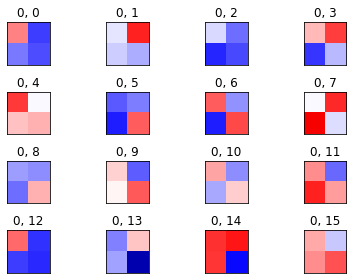

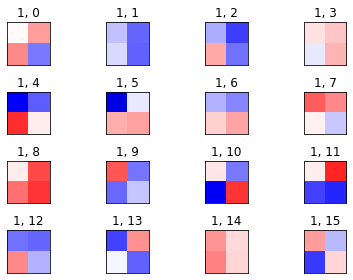

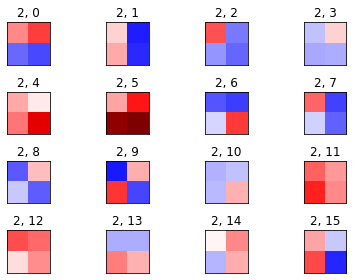

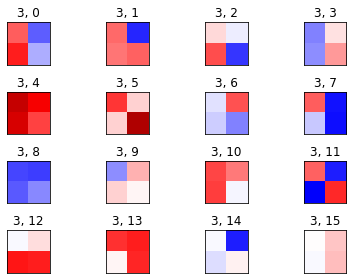

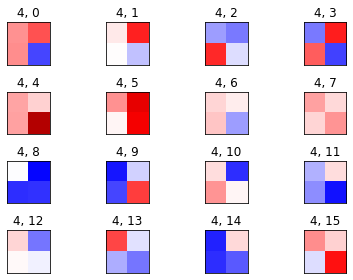

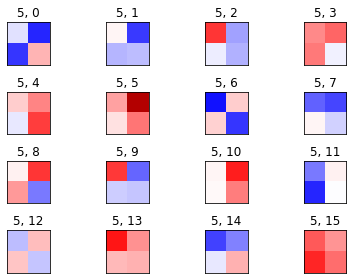

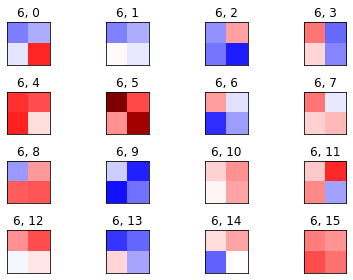

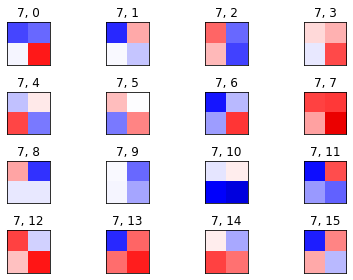

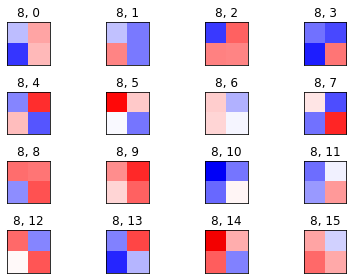

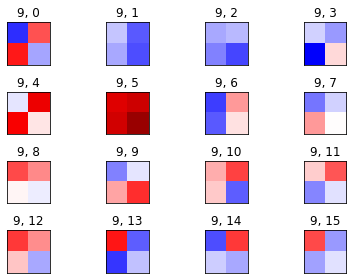

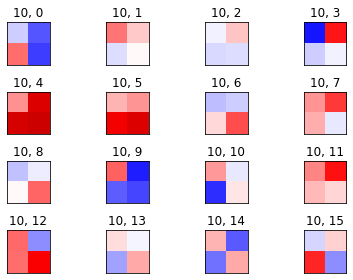

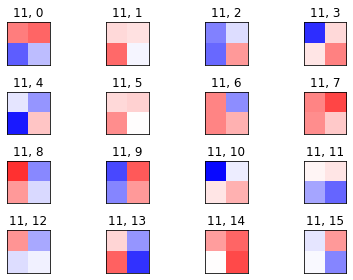

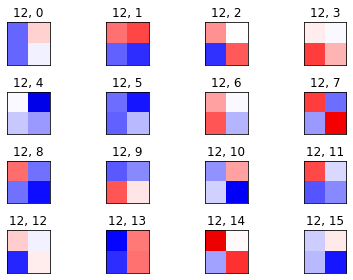

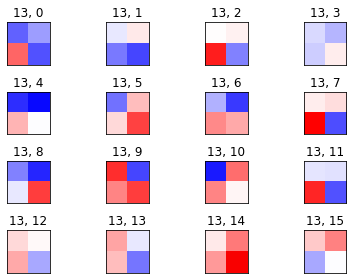

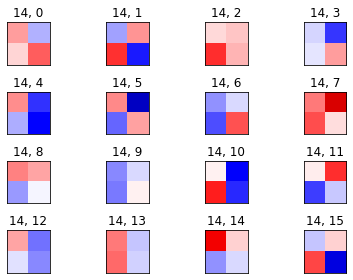

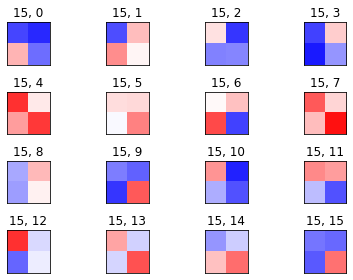

In [43]:
num_filters = conv_x2_kernel_np.shape[2]
channels = range(conv_x2_kernel_np.shape[2])
w_max = np.max(conv_x2_kernel_np)
w_min = np.min(conv_x2_kernel_np)

for channel in channels:
    # create figure and axes
    fig, axes = plt.subplots(4, 4)
    for idx, ax in enumerate(axes.flat):
        img = conv_x2_kernel_np[:, :, channel, idx]
        _ = ax.imshow(img, vmin=w_min, vmax=w_max, 
                      interpolation='nearest', cmap='seismic')
        _ = ax.set_xticks([])
        _ = ax.set_yticks([])
        _ = ax.set_title(f'{channel}, {idx}')
    fig.tight_layout()

In [ ]:

# iterate channels
for channel in channels:
    # iterate filters inside every channel
    for l, ax in enumerate(axes.flat):
        # get a single filter
        img = weights[:, :, channel, l]
        # put it on the grid
        ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
        # remove any labels from the axes
        ax.set_xticks([])
        ax.set_yticks([])
    # save figure
    plt.savefig(os.path.join(plot_dir, '{}-{}.png'.format(name, channel)), bbox_inches='tight')

[]

[]

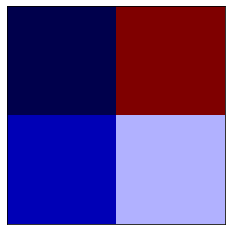

In [29]:
w0 = conv_x1_kernel_np[:, :, 0]
w_min = np.min(w0)
w_max = np.max(w0)

fig, ax = plt.subplots()
_ = ax.imshow(conv_x1_kernel_np[:, :, 0], vmin=w_min, vmax=w_max, 
          interpolation='nearest', cmap='seismic')
# remove any labels from the axes
_ = ax.set_xticks([])
_ = ax.set_yticks([])

In [ ]:
model.dynamics.position_fn.dense

In [39]:
import pickle

with open(model.files['parameters_pkl_file'], 'wb') as f:
    pickle.dump(model.params, f)

In [ ]:
model.sess.graph.collections

In [ ]:
model.sess.graph.get_collection

In [ ]:
model.dynamics.position_fn.summary()

In [ ]:
# Iterate over samples history and calculate observables for each sample.
# `lattice.calc_plaq_observables(samples)` calculates observables for each of
# the samples in the mini-batch.
actions_history = []
avg_plaquettes_history = []
top_charges_history = []
for idx, samples in enumerate(samples_history):
    t0 = time.time()
    observables = np.array(model.lattice.calc_plaq_observables(samples))
    actions, plaqs, charges = observables
    
    actions_history.append(actions)
    avg_plaquettes_history.append(plaqs)
    top_charges_history.append(charges)
    
    print(f'step: {idx}  '
          f'time / step: {time.time() - t0:^6.4g}  '
          f'avg action: {np.mean(actions):^6.4g}  '
          f'avg plaquette: {np.mean(plaqs):^6.4g} '
          f'top charge: {np.mean(charges):^6.4g}')

In [ ]:
_ = helpers.plot_run_data(model.data, 
                          model.params, 
                          model.steps_arr, 
                          model.figs_dir, 
                          skip_steps=1)

In [ ]:
#tf.reset_default_graph()
#model = GaugeModel(params=params,
#                   config=None,
#                   sess=None,
#                   conv_net=False,
#                   hmc=False,
#                   log_dir='../../gauge_logs_graph/run_25',
#                   restore=True)

In [ ]:
samples = np.random.randn(*model.samples.shape)
samples_history = []

In [ ]:
for i in range(500):
    t0 = time.time()
    samples = model.sess.run(model.x_out, feed_dict={model.x: samples})
    samples_history.append(samples)
    print(f'step: {i:^6.4g} time/step: {time.time() - t0:^6.4g}')

In [ ]:
samples_history_conv = np.array(samples_history_conv)
print(samples_history_conv.shape)

In [ ]:
import pickle
samples_history_file = os.path.join(model.info_dir, 'samples_history.pkl')
with open(samples_history_file, 'wb') as f:
    pickle.dump(samples_history_conv, f)